# This notebook performs all the analyses of the processed data

In [1]:
import mne
from mne.stats import permutation_cluster_1samp_test, combine_adjacency, permutation_cluster_test
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import pandas as pd
import pickle
import time
import re
import scipy.signal as signal
import nitime.timeseries as ts
import nitime.analysis as nta
from BBO_Analysis_Functions import Compute_coherence_multitaper, Compute_coherence_nitime, Load_EEG_EMG_Paths, Check_trial_match
from mne.time_frequency import psd_array_multitaper


In [ ]:
# Outline of the analysis
# EEG Channel selection: 
# Given that we are interested in activity in the beta band over the somatosensory cortex, 
# the following channels will be included in the analysis described below:
# Left channels  -> Fc1, C3, Cp1
# Right channels -> Fc2, C4, Cp2 

# Hypothesis 1: Beta suppression in the ipsilateral EMG and contralateral somatosensory cortex (EEG). 
# -	After pre-processing the EEG and EMG data, we will first examine the beta suppression in both the EEG and the EMG data. 

# -	EEG: We will first compute the time frequency representation of the epoched EEG data for the selected EEG channels 
# using a wavelet transform. We will then average the TFRs for all left channels and all right channels separately, 
# which will yield a single left channel TFR (epochs) and a single right channel TFR (epochs). 
# For these new left and right channels, we will then compute the mean for the trials where the stimulation 
# occurred contralateral to the channel (so for instance, on the right hand for the left channel) and a separate 
# average for the trials where the stimulation occurred ipsilateral to the channel. This will yield an average TFR for 
# the contralateral trials and one for the ipsilateral trials, for each channel (left and right). We will then compute a 
# lateralization index as the difference in power between the contralateral trials and the ipsilatreal trials as a percentage 
# of the power on the ipsilateral trials [((contralateral - ipsilateral)/ ipsilateral)  x 100] (see van Ede et al, 2011; 2013). 
# This will yield a separate lateralization index for the left and right channel. Finally, we will average this percentage 
# value for the two channels (left and right), thus yielding a single lateralization index (at each time point and each frequency) 
# for each participant. To test for a significant beta suppression effect, we will perform a cluster-based permutation test 
# using the one sample t-value as our test statistic, to test whether the lateralization index in the beta band frequencies 
# is significantly different from 0.

# -	EMG (Requires exclusion of trials with amplitude mismatch): To assess the lateralization of the EMG power in the beta band, we will compute a similar lateralization 
# measure as with the EEG data. This will first be done for each arm separately as follows: We will first compute 
# the time frequency representation of the epoched data for both arms. We will then compute the average TFR (for each 
# arm separately) for the trials where the stimulation was delivered on the same arm (ipsilateral trials), and the 
# trials where the stimulation was delivered on the other arm (contralateral trials). We will then compute the 
# lateralization measure, for each arm separately, as a percent change relative to the contralateral trials as follows: 
# ((ipsilateral-contralateral)/contralateral) x 100. Once this is computed for both arms, the values will be finally 
# pooled (averaged) thus yielding a single measure for EMG lateralization per participant (See van Ede et al., 2013). 

# -	For both the measures detailed above, we will evaluate statistical significance using a cluster-based permutation 
# test applied to the beta band (15 – 30 Hz). We will use the one sample t-test as our cluster statistic and evaluate 
# against the null hypothesis that the mean lateralization is not different from 0. 


# Hypothesis 2 (requires exclusion or normalisation of trials with amplitude mismatch): Coherence between EMG and the 
# contralateral EEG is larger during stimulus anticipation. 
# -	Step 1: We will first compute the coherence across all trials, between each EMG channel (left and right) and each 
# of the selected contralateral and ipsilateral EEG channels. This will be done for each arm separately. All the 
# contralateral spectra will then be averaged together to form a single contralateral coherence spectrum per participant. 
# Similarly, all the ipsilateral spectra will be averaged together to form a single ipsilateral spectrum per participant. 
# As was observed in van Ede et al., 2013, we expect that the coherence will be higher with contralateral EEG channels vs 
# ipsilateral channels. We will perform a cluster-based permutation test between the contralateral coherence spectra and 
# the ipsilateral coherence spectra to test this expected difference. We will use the one tailed dependent samples-t 
# statistic as our test statistic.

# -	Step 2 (requires exclusion/normalisation of trials with amplitude mismatch): To then test our hypothesis that the coherence 
# between EMG and contralateral EEG is larger during the anticipation of the nociceptive stimulus, we will compute the coherence 
# between each of the EMG channels and the selected contralateral EEG channels, but only for the trials when the stimulation 
# was delivered to the ipsilateral arm (the EMG arm). This will provide, for each participant, an estimate of the coherence 
# for each participant, an estimate of the coherence between muscular and contralateral EEG activity during the anticipation 
# of the nociceptive stimulus. This will be performed for each arm separately first. We will then average these coherence spectra 
# together to compute a single estimate of coherence during stimulus anticipation for each participant. Finally, to test our 
# hypothesis of increased coherence during the anticipation of a nociceptive stimulus, we will perform another cluster-based 
# permutation test where we will compare this spectrum with the overall coherence spectra computed in the previous step.

# -	We will further compare the coherence spectra computed in step 2, with two other conditions: 1) the coherence of the 
# EMG channels with the contralateral EEG channels on the trials where the stimulation/attention was on the contralateral arm 
# (the arm contralateral to the EMG), and 2) coherence between the EMG channels and the ipsilateral EEG channels for the trials 
# where the stimulation/attention was given to the arm ipsilateral to the EMG. 

# Exploratory analyses (requires exclusion/normalisation of trials with amplitude mismatch):
# -	To explore the concordance between the cortical and muscular beta lateralization at the trial level, we will 
# calculate trial-by-trial correlations between cortical and muscular beta lateralization during the anticipation 
# of the nociceptive stimulus. For this analysis, we will focus on the anticipatory modulations in a pre-stimulus 
# window that will be based on the time window within which there is a significant lateralization effect at the group 
# level in the EEG and EMG data as identified in the primary analysis. Per trial, we will calculate the normalized 
# difference in beta power between the left and right recording sites: for cortical lateralization, we will calculate 
# [(Right - Left)/(Right + Left)] and for muscular lateralization we will calculate [(Left - Right)/(Left + Right)]. 
# We will then sort the trials according to cortical lateralization (separately for left- and right-cued trials) 
# and place them into five consecutive bins. For each bin, we will then calculate both the average cortical and the 
# average muscular lateralization, before averaging the binned data across subjects (van Ede et al., 2013). Finally, 
# we will correlate the binned data for cortical lateralization with that of the muscular lateralization to examine 
# whether higher cortical lateralization co-occurs with higher muscular lateralization. 

# -	We will also measure the correlations across subjects 1) between the cortical lateralization measure and 
# cortico-muscular coherence during stimulus anticipation and 2) between the muscular lateralization measure and 
# cortico-muscular coherence during stimulus anticipation.



In [ ]:
# -	EEG: We will first compute the time frequency representation of the epoched EEG data for the selected EEG channels 
# using a wavelet transform. We will then average the TFRs for all left channels and all right channels separately, 
# which will yield a single left channel TFR (epochs) and a single right channel TFR (epochs). 
# For these new left and right channels, we will then compute the mean for the trials where the stimulation 
# occurred contralateral to the channel (so for instance, on the right hand for the left channel) and a separate 
# average for the trials where the stimulation occurred ipsilateral to the channel. This will yield an average TFR for 
# the contralateral trials and one for the ipsilateral trials, for each channel (left and right). We will then compute a 
# lateralization index as the difference in power between the contralateral trials and the ipsilatreal trials as a percentage 
# of the power on the ipsilateral trials [((contralateral - ipsilateral)/ ipsilateral)  x 100] (see van Ede et al, 2011; 2013). 
# This will yield a separate lateralization index for the left and right channel. Finally, we will average this percentage 
# value for the two channels (left and right), thus yielding a single lateralization index (at each time point and each frequency) 
# for each participant. To test for a significant beta suppression effect, we will perform a cluster-based permutation test 
# using the one sample t-value as our test statistic, to test whether the lateralization index in the beta band frequencies 
# is significantly different from 0.


# Define channels of interest:
Left_channels = ['FC1', 'C3', 'CP1']
Right_channels = ['FC2', 'C4', 'CP2']

def Extract_Lat_index(this_subject, channel = "Mean"):
    """
    Function to extract the lateralization index for a single participant
    Parameters:
    - this_subject: MNE TFR object with EEG data and events.
    - channel: str, the channel to extract the lateralization index for. Can be "FC", "C", "CP" or "Mean".
    Returns:
    - Mean_lat_index: float, average lateralization index across left and right arms.
    """
    # Construct the left and right chennels by averaging the TFR of the left and right channels respectively
    if channel == "Mean":
        left_data = np.zeros((this_subject.data.shape[0], len(Left_channels), this_subject.data.shape[2], this_subject.data.shape[3]))
        print(left_data.shape) 
        for idx, channel in enumerate(Left_channels):
            left_data[:, idx, :, :] = this_subject.data[:, this_subject.ch_names.index(channel), :, :]
        left_data = np.mean(left_data, axis=1)
        right_data = np.zeros((this_subject.data.shape[0], len(Right_channels), this_subject.data.shape[2], this_subject.data.shape[3]))
        for idx, channel in enumerate(Right_channels):
            right_data[:, idx, :, :] = this_subject.data[:, this_subject.ch_names.index(channel), :, :]
        right_data = np.mean(right_data, axis=1)
    elif channel == "FC":
        left_data = this_subject.data[:, this_subject.ch_names.index('FC1'), :, :]
        right_data = this_subject.data[:, this_subject.ch_names.index('FC2'), :, :]
    elif channel == "C":
        left_data = this_subject.data[:, this_subject.ch_names.index('C3'), :, :]
        right_data = this_subject.data[:, this_subject.ch_names.index('C4'), :, :]
    elif channel == "CP":
        left_data = this_subject.data[:, this_subject.ch_names.index('CP1'), :, :]
        right_data = this_subject.data[:, this_subject.ch_names.index('CP2'), :, :]
    else:
        raise ValueError("Invalid channel name")
    
    # Compute the contralateral and ipsilateral TFRs for the left and right channels
    events = this_subject.events
    event_id = {'Left':10002,'Invalid':10003, 'Right':10004}
    Left_contra = left_data[events[:, 2] == event_id['Right'],:,:]
    Left_ipsi = left_data[events[:, 2] == event_id['Left'],:,:]

    Right_contra = right_data[events[:, 2] == event_id['Left'],:,:]
    Right_ipsi = right_data[events[:, 2] == event_id['Right'],:,:]

    assert Left_contra.shape[0] == Left_ipsi.shape[0] == Right_contra.shape[0] == Right_ipsi.shape[0] == 45, "The number of trials for the contra and ipsi is incorrect"

    Left_contra_mean = Left_contra.mean(axis=0)
    Left_ipsi_mean = Left_ipsi.mean(axis=0)
    Right_contra_mean = Right_contra.mean(axis=0)
    Right_ipsi_mean = Right_ipsi.mean(axis=0)

    # Compute the lateralization index for the left and right channels - [((contralateral - ipsilateral)/ ipsilateral)  x 100]
    Left_lat_index = ((Left_contra_mean - Left_ipsi_mean)/Left_ipsi_mean)*100
    Right_lat_index = ((Right_contra_mean - Right_ipsi_mean)/Right_ipsi_mean)*100
    
    # average this percentage value for the two channels (left and right)
    Mean_lat_index = (Left_lat_index + Right_lat_index)/2
    return Mean_lat_index


# Extract the procesed TFR file names
EEG_path = "Path to processed data/Processed/"
EEG_folders = [f for f in os.listdir(EEG_path) if os.path.isdir(os.path.join(EEG_path, f))]
TFR_filenames = []
for idx, folder in enumerate(EEG_folders):
    TFR_file = [f for f in os.listdir(os.path.join(EEG_path, folder)) if f.endswith('.hdf5')]
    if len(TFR_file) == 0:
        continue
    TFR_filenames.append(os.path.join(EEG_path, EEG_folders[idx], TFR_file[0]))

# Load the TFR data
sample_subject = mne.time_frequency.read_tfrs(TFR_filenames[0])
numfreq = sample_subject.freqs.shape[0]
numtime = sample_subject.times.shape[0]
Frequencies = sample_subject.freqs
Times = sample_subject.times
Lateralisation_index_mean = np.zeros((len(TFR_filenames), numfreq, numtime))
Lateralisation_index_FC = np.zeros((len(TFR_filenames), numfreq, numtime))
Lateralisation_index_C = np.zeros((len(TFR_filenames), numfreq, numtime))
Lateralisation_index_CP = np.zeros((len(TFR_filenames), numfreq, numtime))
for subject_index in range(len(TFR_filenames)):
    this_subject = mne.time_frequency.read_tfrs(TFR_filenames[subject_index])
    Lateralisation_index_mean[subject_index, :, :] = Extract_Lat_index(this_subject)
    Lateralisation_index_FC[subject_index, :, :] = Extract_Lat_index(this_subject, channel = "FC")
    Lateralisation_index_C[subject_index, :, :] = Extract_Lat_index(this_subject, channel = "C")
    Lateralisation_index_CP[subject_index, :, :] = Extract_Lat_index(this_subject, channel = "CP")

# Create the save path if it doesn't exist
savepath = "Path to save data/Lateralisation_indices_EEG/"
if not os.path.exists(savepath):
    os.makedirs(savepath)
# Save all the indices
np.save(os.path.join(savepath, "Lateralisation_index_mean.npy"), Lateralisation_index_mean)
np.save(os.path.join(savepath, "Lateralisation_index_FC.npy"), Lateralisation_index_FC)
np.save(os.path.join(savepath, "Lateralisation_index_C.npy"), Lateralisation_index_C)
np.save(os.path.join(savepath, "Lateralisation_index_CP.npy"), Lateralisation_index_CP)


Outliers: [ 2 23]
Data shape after outlier removal: (28, 48, 4001)


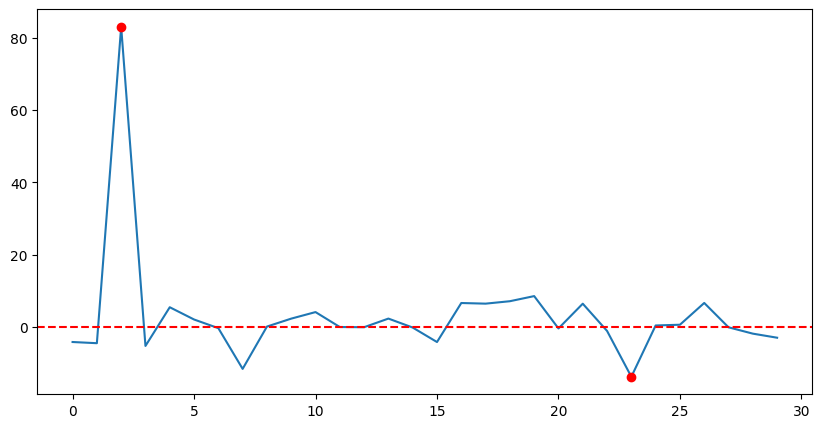

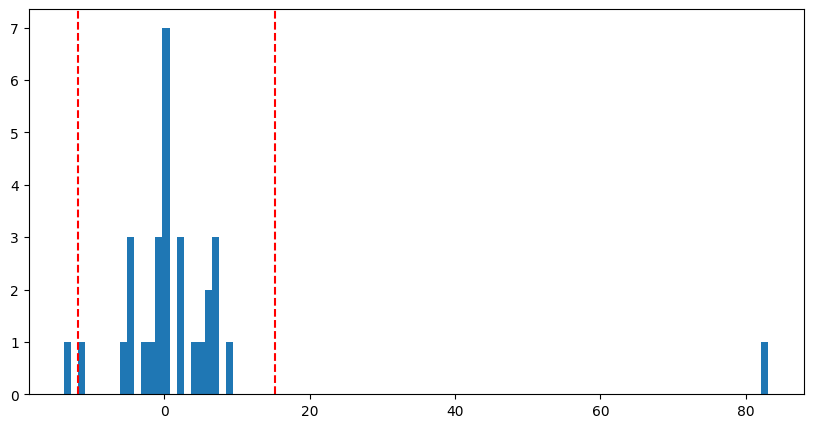

In [48]:

# Load the indices for plotting and outlier removal
savepath = "Path to saved data/Lateralisation_indices_EEG/"
Lateralisation_index_mean_loaded = np.load(os.path.join(savepath, "Lateralisation_index_mean.npy"))
Lateralisation_index_FC_loaded = np.load(os.path.join(savepath, "Lateralisation_index_FC.npy"))
Lateralisation_index_C_loaded = np.load(os.path.join(savepath, "Lateralisation_index_C.npy"))
Lateralisation_index_CP_loaded = np.load(os.path.join(savepath, "Lateralisation_index_CP.npy"))

numfreq = 48
Frequencies = np.arange(3,51,1)
Times = np.linspace(-3, 1, 4001)
data = Lateralisation_index_mean_loaded

# indices for beta band
freq10 = np.argmin(np.abs(Frequencies-10))
freq30 = np.argmin(np.abs(Frequencies-40))

index_mean = np.mean(data, axis=(1,2))

# Compute IQR
Q1 = np.percentile(index_mean, 25)
Q3 = np.percentile(index_mean, 75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = np.where((index_mean < lower_bound) | (index_mean > upper_bound))[0]
print(f'Outliers: {outliers}')

data = np.delete(data, outliers, axis=0)  # Remove outliers
print(f'Data shape after outlier removal: {data.shape}')

plt.figure(figsize=(10, 5))
plt.plot(index_mean)
plt.axhline(y=0, color='r', linestyle='--')
plt.plot(outliers, index_mean[outliers], 'ro')
plt.show()


# Draw a histogram and show the outliers
plt.figure(figsize=(10, 5))
plt.hist(index_mean, bins=100)
plt.axvline(x=lower_bound, color='r', linestyle='--')
plt.axvline(x=upper_bound, color='r', linestyle='--')
plt.show()


Outliers: [ 2 23 26]
Data shape after outlier removal: (27, 48, 3001)
Using a threshold of -1.705618
stat_fun(H1): min=-5.826033713231509 max=4.205697589615756
Running initial clustering …
Found 7 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Cluster p values shape: (7,)
Number of significant clusters: 1
Cluster times: -3.0, 0.0
Cluster frequencies: 7, 39


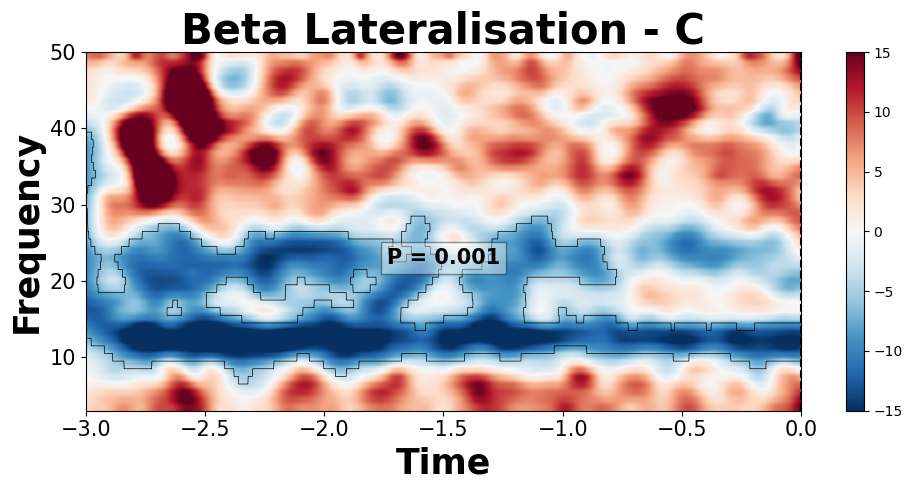

Cluster 1 significant with p-value: 0.001


In [214]:
# Load the saved indices and perform the cluster test
numfreq = 48
Frequencies = np.arange(3,51,1)
Times = np.linspace(-3, 1, 4001)

# Load the indices
savepath = "Path to saved data/Lateralisation_indices_EEG/"
Lateralisation_index_mean = np.load(os.path.join(savepath, "Lateralisation_index_mean.npy"))
Lateralisation_index_FC = np.load(os.path.join(savepath, "Lateralisation_index_FC.npy"))
Lateralisation_index_C = np.load(os.path.join(savepath, "Lateralisation_index_C.npy"))
Lateralisation_index_CP = np.load(os.path.join(savepath, "Lateralisation_index_CP.npy"))

data = Lateralisation_index_C
numfreq = 48
Frequencies = np.arange(3,51,1)
Times = np.linspace(-3, 1, 4001)


# Reduce to -3 to 0 seconds
data = data[:, :, Times <= 0]
Times = Times[Times <= 0]

# indices for beta band
freq10 = np.argmin(np.abs(Frequencies-10))
freq30 = np.argmin(np.abs(Frequencies-40))

index_mean = np.mean(data, axis=(1,2))

# Compute IQR
Q1 = np.percentile(index_mean, 25)
Q3 = np.percentile(index_mean, 75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = np.where((index_mean < lower_bound) | (index_mean > upper_bound))[0]
print(f'Outliers: {outliers}')

data = np.delete(data, outliers, axis=0)  # Remove outliers
print(f'Data shape after outlier removal: {data.shape}')


# Define your data (subjects x frequencies x time)
n_permutations = 1000
threshold = None

adjacency = mne.stats.combine_adjacency(
    data.shape[1], data.shape[2]
)

# Perform the one-sample cluster-based permutation t-test
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    data, n_permutations=n_permutations, threshold=threshold, tail=-1, out_type="indices"  # Testing if the data is less than 0
    )
print(f"Cluster p values shape: {cluster_p_values.shape}")

# Find significant clusters
significant_clusters = np.where(cluster_p_values < 0.05)[0]
print(f'Number of significant clusters: {len(significant_clusters)}')

# Create a mask to highlight significant clusters
cluster_mask = np.zeros_like(T_obs, dtype=bool)

# Plot the results
plt.figure(figsize=(10, 5))
plt.imshow(data.mean(axis=0), aspect='auto', origin='lower', cmap='RdBu_r', extent=[Times[0], Times[-1], Frequencies[0], Frequencies[-1]])
plt.colorbar()
plt.title('Beta Lateralisation - C', fontsize=30, fontweight='bold')
plt.xlabel('Time', fontsize=25, fontweight='bold')
plt.ylabel('Frequency', fontsize=25, fontweight='bold')
plt.axvline(0, color='black', linestyle='--')
plt.clim(-15, 15)
# increase font size of the x and y ticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Re-map flattened indices to 2D (frequencies, time) indices
for clu_idx in significant_clusters:
    # Get the indices for the current cluster
    cluster_indices = clusters[clu_idx]  # Tuple of (frequency indices, time indices)
    # Extract the corresponding time and frequency values
    freq_indices, time_indices = cluster_indices
    cluster_times = Times[time_indices]
    cluster_frequencies = Frequencies[freq_indices]
    cluster_mask[freq_indices, time_indices] = True
    print(f'Cluster times: {np.min(cluster_times)}, {np.max(cluster_times)}')
    print(f'Cluster frequencies: {np.min(cluster_frequencies)}, {np.max(cluster_frequencies)}')
    plt.contour(Times, Frequencies, cluster_mask, colors='black', linewidths=0.5, origin='lower', extent=[0, data.shape[2], 0, data.shape[1]])
    mid_time = (np.min(cluster_times) + np.max(cluster_times)) / 2
    mid_freq = (np.min(cluster_frequencies) + np.max(cluster_frequencies)) / 2
    plt.text(mid_time, mid_freq, f'P = {cluster_p_values[clu_idx]:.3f}', color='black', fontsize=15, 
             ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))
plt.tight_layout()
plt.savefig('Path to save figure/EEG_cluster_test_C_lateralisation.jpg', dpi=300) 
plt.show()

# List of significant clusters
for i_clu, clu_idx in enumerate(significant_clusters):
    print(f"Cluster {i_clu + 1} significant with p-value: {cluster_p_values[clu_idx]}")



In [ ]:
# Compute Grand Average TFR for the Stimulus related data
ERP_BBO_filenames, EMG_filenames, Behavioural_filenames = Load_EEG_EMG_Paths()
TFR_BBO_filenames = []
ERP_Stim_filenames = []
TFR_Stim_filenames = []
for i in range(len(ERP_BBO_filenames)):
    thisname = ERP_BBO_filenames[i].split('/')[:-1]
    thisname = '/'.join(thisname) + '/'
    Files = os.listdir(thisname)
    for File in Files:
        if File.endswith('-tfr.hdf5') and not File.startswith('._') and 'ERPs' not in File:
            TFR_file = os.path.join(thisname, File)
            TFR_BBO_filenames.append(TFR_file)
        if File.endswith('ERPs-epo.fif') and not File.startswith('._'):
            ERP_Stim_file = os.path.join(thisname, File)
            ERP_Stim_filenames.append(ERP_Stim_file)
        if File.endswith('ERPs-tfr.hdf5') and not File.startswith('._'):
            TFR_Stim_file = os.path.join(thisname, File)
            TFR_Stim_filenames.append(TFR_Stim_file)
            
tfr_list_left = []
tfr_list_right = []
# Loop through each participant
for filename in TFR_Stim_filenames:
    tfr = mne.time_frequency.read_tfrs(filename)

    tfr_left = tfr['Left'].average()
    tfr_right = tfr['Right'].average()

    tfr_list_right.append(tfr_right)
    tfr_list_left.append(tfr_left)

# Compute the grand average TFR
grand_avg_tfr_left = mne.grand_average(tfr_list_left)
grand_avg_tfr_right = mne.grand_average(tfr_list_right)
grand_avg_tfr_left.save('Path to save data/grand_average_left_Prestim-tfr.hdf5', overwrite=True)
grand_avg_tfr_right.save('Path to save data/grand_average_right_Prestim-tfr.hdf5', overwrite=True)

Reading /Volumes/KetanData2/BBO/grand_average_left_Prestim-tfr.hdf5 ...
Applying baseline correction (mode: mean)
Reading /Volumes/KetanData2/BBO/grand_average_right_Prestim-tfr.hdf5 ...
Applying baseline correction (mode: mean)
['FC1', 'C3', 'CP1', 'FC2', 'C4', 'CP2']
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'TP9', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP10', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
No baseline correction applied


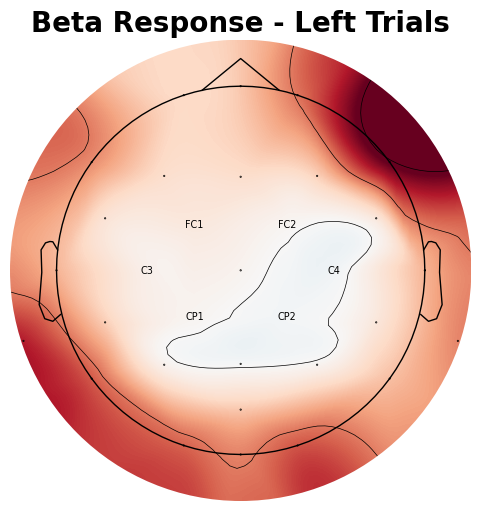

No baseline correction applied


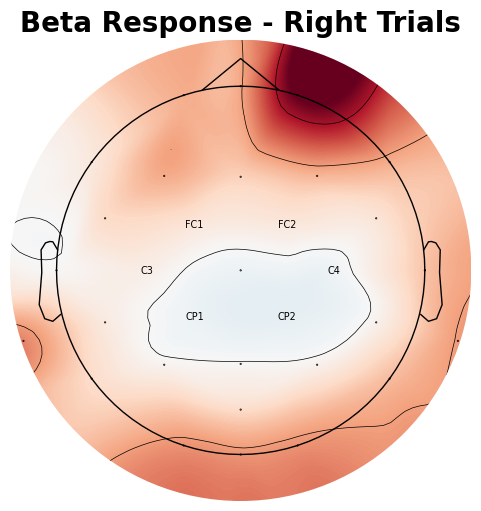

In [159]:
# Plot the grand average TFR data - Pre-stimulus
grand_avg_tfr_left = mne.time_frequency.read_tfrs('Path to save data/grand_average_left_Prestim-tfr.hdf5')
grand_avg_tfr_left.apply_baseline((-.5, -.2))

grand_avg_tfr_right = mne.time_frequency.read_tfrs('Path to save data/grand_average_right_Prestim-tfr.hdf5')
grand_avg_tfr_right.apply_baseline((-.5, -.2))

all_chans = Left_channels + Right_channels
mask = np.isin(grand_avg_tfr_left.ch_names, all_chans)


# Plot topography
tmin = .2
tmax = .35
fmin = 15
fmax = 28

# Define time-frequency window for topomap plotting
mne.viz.plot_tfr_topomap(grand_avg_tfr_left, tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, 
                         show=False, outlines='head', sphere='eeglab', baseline=None,
                         show_names=True, mask=mask, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                         linewidth=0, markersize=0), contours=4,
                         extrapolate='auto', size = 5, cmap=None, vlim=(None, None), 
                         cnorm=None, colorbar=False, cbar_fmt='%1.1e', units=None, axes=None)
plt.title('Beta Response - Left Trials', fontsize=20, fontweight='bold')
# plt.savefig('/Users/ketanjaltare1/Desktop/PhD docs/Experiments/BBO/Manuscript/Figures/Left_trials_EEG_Topo_Beta_Response.jpg', dpi=300)
plt.show()

mne.viz.plot_tfr_topomap(grand_avg_tfr_right, tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, 
                         show=False, outlines='head', sphere='eeglab', baseline=None, 
                         show_names=True, mask=mask, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                         linewidth=0, markersize=0), contours=4,
                         extrapolate='auto', size = 5, cmap=None, vlim=(None, None), 
                         cnorm=None, colorbar=False, cbar_fmt='%1.1e', units=None, axes=None)
plt.title('Beta Response - Right Trials', fontsize=20, fontweight='bold')
# plt.savefig('/Users/ketanjaltare1/Desktop/PhD docs/Experiments/BBO/Manuscript/Figures/Right_trials_EEG_Topo_Beta_Response.jpg', dpi=300)
plt.show()

Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_1_/BBO_1_ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_2_/BBO_2_ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_3_/BBO_3_ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_4_/BBO_4_ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_17/BBO_17ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_5_/BBO_5_ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_6_/BBO_6_ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_7_/BBO_7_ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_8_/BBO_8_ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_9_/BBO_9_ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_10/BBO_10ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_11/BBO_11ERPs-tfr.hdf5 ...
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_12/BBO_12ERPs-tfr.hdf5 ...

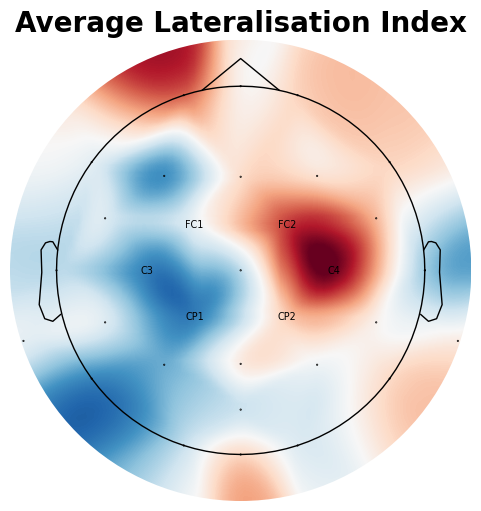

In [172]:
# Check the lateralisation post stimulation for the Beta band
# Compute Grand Average TFR for the Stimulus related data
ERP_BBO_filenames, EMG_filenames, Behavioural_filenames = Load_EEG_EMG_Paths()
TFR_BBO_filenames = []
ERP_Stim_filenames = []
TFR_Stim_filenames = []
for i in range(len(ERP_BBO_filenames)):
    thisname = ERP_BBO_filenames[i].split('/')[:-1]
    thisname = '/'.join(thisname) + '/'
    Files = os.listdir(thisname)
    for File in Files:
        if File.endswith('-tfr.hdf5') and not File.startswith('._') and 'ERPs' not in File:
            TFR_file = os.path.join(thisname, File)
            TFR_BBO_filenames.append(TFR_file)
        if File.endswith('ERPs-epo.fif') and not File.startswith('._'):
            ERP_Stim_file = os.path.join(thisname, File)
            ERP_Stim_filenames.append(ERP_Stim_file)
        if File.endswith('ERPs-tfr.hdf5') and not File.startswith('._'):
            TFR_Stim_file = os.path.join(thisname, File)
            TFR_Stim_filenames.append(TFR_Stim_file)
            
tfr_list_left = []
tfr_list_right = []
# Loop through each participant
for filename in TFR_Stim_filenames:
    tfr = mne.time_frequency.read_tfrs(filename)

    tfr_left = tfr['Left'].average()
    tfr_right = tfr['Right'].average()

    tfr_list_right.append(tfr_right)
    tfr_list_left.append(tfr_left)

# Save these lists
with open('Path to save data/tfr_list_left_stim_ERP.pkl', 'wb') as f:
    pickle.dump(tfr_list_left, f)
with open('Path to save data/tfr_list_right_stim_ERP.pkl', 'wb') as f:
    pickle.dump(tfr_list_right, f)


No baseline correction applied


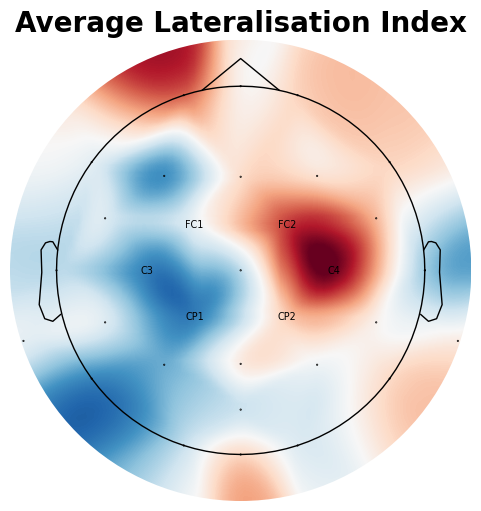

In [174]:
# Load the lists
with open('Path to save data/tfr_list_left_stim_ERP.pkl', 'rb') as f:
    tfr_list_left = pickle.load(f)
with open('Path to save data/tfr_list_right_stim_ERP.pkl', 'rb') as f:
    tfr_list_right = pickle.load(f)

All_lat_indices = []
for i in range(len(tfr_list_left)):
    tfr_left = tfr_list_left[i]
    tfr_right = tfr_list_right[i]
    lat_index = (tfr_right.data - tfr_left.data) / (tfr_right.data + tfr_left.data)
    All_lat_indices.append(lat_index)

All_lat_indices = np.array(All_lat_indices)
All_lat_indices = np.mean(All_lat_indices, axis=0)

# Put this in an average TFR object
Lat_index_tfr = tfr_left.copy()
Lat_index_tfr.data = All_lat_indices

all_chans = Left_channels + Right_channels
mask = np.isin(grand_avg_tfr_left.ch_names, all_chans)

tmin = .2
tmax = .35
fmin = 15
fmax = 28 

# Plot the average lateralisation index
mne.viz.plot_tfr_topomap(Lat_index_tfr, tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, 
                         show=False, outlines='head', sphere='eeglab', baseline=None, 
                         show_names=True, mask=mask, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                         linewidth=0, markersize=0), contours=0,
                         extrapolate='auto', size = 5, cmap=None, vlim=(None, None), 
                         cnorm=None, colorbar=False, cbar_fmt='%1.1e', units=None, axes=None)
plt.title('Beta Lateralisation - Post Stimulus', fontsize=20, fontweight='bold')
plt.savefig('Path to save figure/Averave_EEG_Norm_Lat_Index_Topo_Post_Stim.jpg', dpi=300)
plt.show()

In [ ]:
# Extract Alpha and Beta band activity and compute grand averages
# Compute Grand Average TFR for the Stimulus related data
ERP_BBO_filenames, EMG_filenames, Behavioural_filenames = Load_EEG_EMG_Paths()
TFR_BBO_filenames = []
ERP_Stim_filenames = []
TFR_Stim_filenames = []
for i in range(len(ERP_BBO_filenames)):
    thisname = ERP_BBO_filenames[i].split('/')[:-1]
    thisname = '/'.join(thisname) + '/'
    Files = os.listdir(thisname)
    for File in Files:
        if File.endswith('-tfr.hdf5') and not File.startswith('._') and 'ERPs' not in File:
            TFR_file = os.path.join(thisname, File)
            TFR_BBO_filenames.append(TFR_file)
        if File.endswith('ERPs-epo.fif') and not File.startswith('._'):
            ERP_Stim_file = os.path.join(thisname, File)
            ERP_Stim_filenames.append(ERP_Stim_file)
        if File.endswith('ERPs-tfr.hdf5') and not File.startswith('._'):
            TFR_Stim_file = os.path.join(thisname, File)
            TFR_Stim_filenames.append(TFR_Stim_file)
            
tfr_list_left = []
tfr_list_right = []
# Loop through each participant
for filename in ERP_BBO_filenames:
    epochs = mne.read_epochs(filename)

    epochs_left = epochs['Left']
    epochs_right = epochs['Right']

    freqs = np.arange(3, 51, 1)
    n_cycles = freqs / 2.0
    tfr_left = epochs_left.compute_tfr(method = 'morlet',
                                            freqs = freqs,
                                            n_cycles = n_cycles,
                                            output='power',
                                            average=True,
                                            return_itc=False,
                                            decim=1)
    
    tfr_right = epochs_right.compute_tfr(method = 'morlet',
                                            freqs = freqs,
                                            n_cycles = n_cycles,
                                            output='power',
                                            average=True,
                                            return_itc=False,
                                            decim=1)

    tfr_list_right.append(tfr_right)
    tfr_list_left.append(tfr_left)

# Save the TFR lists
with open('Path to save data/tfr_list_left_stim_BBO.pkl', 'wb') as f:
    pickle.dump(tfr_list_left, f)
with open('Path to save data/tfr_list_right_stim_BBO.pkl', 'wb') as f:
    pickle.dump(tfr_list_right, f)

# Compute the grand average TFR
grand_avg_tfr_left = mne.grand_average(tfr_list_left)
grand_avg_tfr_right = mne.grand_average(tfr_list_right)


Identifying common channels ...
Identifying common channels ...
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
No baseline correction applied


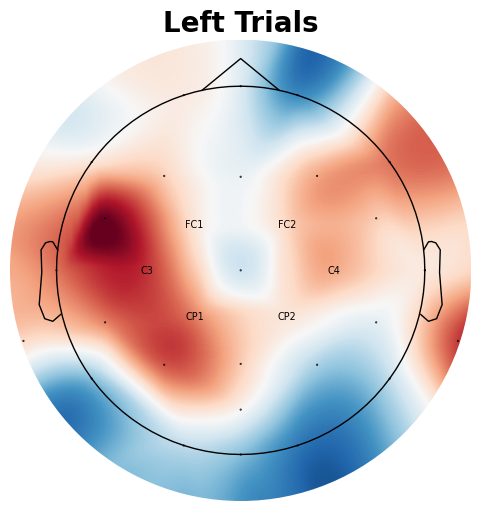

No baseline correction applied


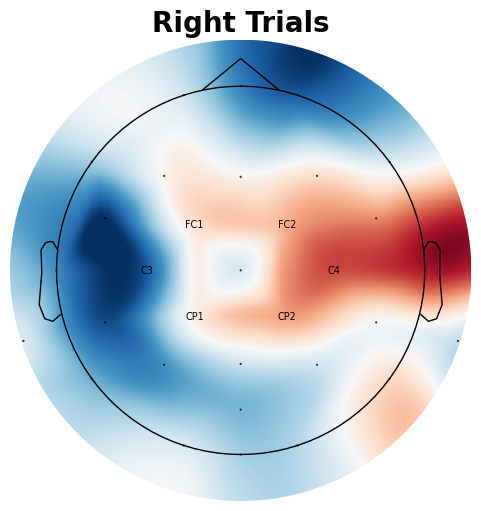

In [182]:
# Plot the grand average TFR data - BBO
# Load the TFR lists
with open('Path to save data/tfr_list_left_stim_BBO.pkl', 'rb') as f:
    tfr_list_left = pickle.load(f)
with open('Path to save data/tfr_list_right_stim_BBO.pkl', 'rb') as f:
    tfr_list_right = pickle.load(f)

# delete the outliers
for i in sorted(outliers, reverse=True):
    tfr_list_right.pop(i)
    tfr_list_left.pop(i)

# Compute the grand average TFR
Left_tfr = mne.grand_average(tfr_list_left)
Right_tfr = mne.grand_average(tfr_list_right)

Left_tfr.apply_baseline((-4,-3.2), mode='percent')
Right_tfr.apply_baseline((-4,-3.2),  mode='percent')

all_chans = Left_channels + Right_channels
mask = np.isin(Left_tfr.ch_names, all_chans)

# Define time-frequency window for topomap plotting
tmin = -3
tmax = -2
fmin = 15
fmax = 28 

mne.viz.plot_tfr_topomap(Left_tfr, tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, 
                         show=False, outlines='head', sphere='eeglab', baseline=None, 
                         show_names=True, mask=mask, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                         linewidth=0, markersize=0), contours=0,
                         extrapolate='auto', size = 5, cmap=None, vlim=(None, None), 
                         cnorm=None, colorbar=False, cbar_fmt='%1.1e', units=None, axes=None)
plt.title('Left Trials', fontsize=20, fontweight='bold')
plt.savefig('Path to save figure/Left_trials_EEG_Topo_Anticipation.jpg', dpi=300)
plt.show()

mne.viz.plot_tfr_topomap(Right_tfr, tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, 
                         show=False, outlines='head', sphere='eeglab', baseline=None, 
                         show_names=True, mask=mask, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                         linewidth=0, markersize=0), contours=0,
                         extrapolate='auto', size = 5, cmap=None, vlim=(None, None), 
                         cnorm=None, colorbar=False, cbar_fmt='%1.1e', units=None, axes=None)
plt.title('Right Trials', fontsize=20, fontweight='bold')
plt.savefig('Path to save figure/Right_trials_EEG_Topo_Anticipation.jpg', dpi=300)
plt.show()


No baseline correction applied


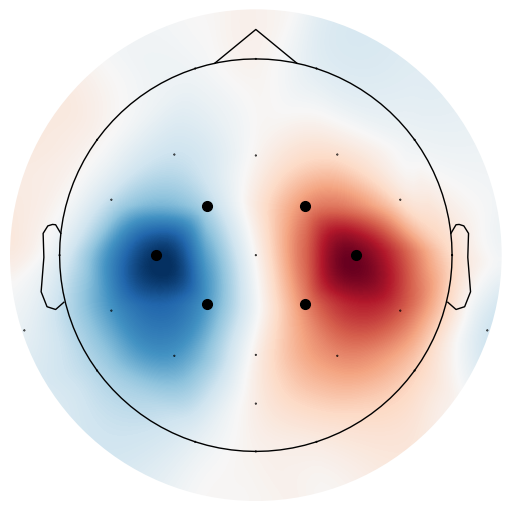

In [316]:
# Plot the lateralisation as the normalised difference between right and left trials: [(right - left)/(right + left)]. 
with open('Path to saved data/tfr_list_left_stim_BBO.pkl', 'rb') as f:
    tfr_list_left = pickle.load(f)
with open('Path to saved data/tfr_list_right_stim_BBO.pkl', 'rb') as f:
    tfr_list_right = pickle.load(f)

# delete the outliers
for i in sorted(outliers, reverse=True):
    tfr_list_right.pop(i)
    tfr_list_left.pop(i)

All_lat_indices = []
for i in range(len(tfr_list_left)):
    tfr_left = tfr_list_left[i]
    tfr_right = tfr_list_right[i]
    lat_index = (tfr_right.data - tfr_left.data) / (tfr_right.data + tfr_left.data)
    All_lat_indices.append(lat_index)

All_lat_indices = np.array(All_lat_indices)
All_lat_indices = np.mean(All_lat_indices, axis=0)

# Put this in an average TFR object
Lat_index_tfr = tfr_left.copy()
Lat_index_tfr.data = All_lat_indices

# Define time-frequency window for topomap plotting
tmin = -3
tmax = -.63
fmin = 15
fmax = 28

# Plot the average lateralisation index
mne.viz.plot_tfr_topomap(Lat_index_tfr, tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, 
                         show=False, outlines='head', sphere='eeglab', baseline=None, 
                         show_names=False, mask=mask, mask_params=dict(marker='o', markerfacecolor='k', markeredgecolor='k',
                         linewidth=0, markersize=7), contours=0,
                         extrapolate='auto', size = 5, cmap=None, vlim=(None, None), 
                         cnorm=None, colorbar=False, cbar_fmt='%1.1e', units=None, axes=None)
plt.title('Lateralisation Topography', fontsize=30, fontweight='bold')
plt.savefig('Path to save figure/Averave_EEG_Norm_Lat_Index_Topo_Anticipation.jpg', dpi=300)
plt.show()


No baseline correction applied


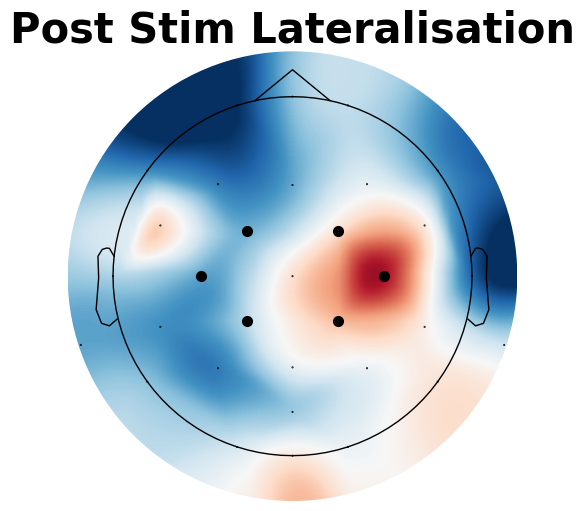

In [360]:
# Plot the post stim lateralisation as the normalised difference between right and left trials: [(right - left)/(right + left)]. 
with open('Path to saved data/tfr_list_left_stim_BBO.pkl', 'rb') as f:
    tfr_list_left = pickle.load(f)
with open('Path to saved data/tfr_list_right_stim_BBO.pkl', 'rb') as f:
    tfr_list_right = pickle.load(f)

# delete the outliers
for i in sorted(outliers, reverse=True):
    tfr_list_right.pop(i)
    tfr_list_left.pop(i)

All_lat_indices = []
for i in range(len(tfr_list_left)):
    tfr_left = tfr_list_left[i]
    tfr_right = tfr_list_right[i]
    lat_index = (tfr_right.data - tfr_left.data) / (tfr_right.data + tfr_left.data)
    All_lat_indices.append(lat_index)

All_lat_indices = np.array(All_lat_indices)
All_lat_indices = np.mean(All_lat_indices, axis=0)

# Put this in an average TFR object
Lat_index_tfr = tfr_left.copy()
Lat_index_tfr.data = All_lat_indices

# Define time-frequency window for topomap plotting
tmin = 0
tmax = .5
fmin = 15
fmax = 28

# Plot the average lateralisation index
mne.viz.plot_tfr_topomap(Lat_index_tfr, tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, 
                         show=False, outlines='head', sphere='eeglab', baseline=None, 
                         show_names=False, mask=mask, mask_params=dict(marker='o', markerfacecolor='k', markeredgecolor='k',
                         linewidth=0, markersize=7), contours=0,
                         extrapolate='auto', size = 5, cmap=None, vlim=(None, None), 
                         cnorm=None, colorbar=False, cbar_fmt='%1.1e', units=None, axes=None)
plt.title('Post Stim Lateralisation', fontsize=30, fontweight='bold')
plt.savefig('Path to save figure/Averave_EEG_Norm_Lat_Index_Topo_Post_Stim.jpg', dpi=300)
plt.show()


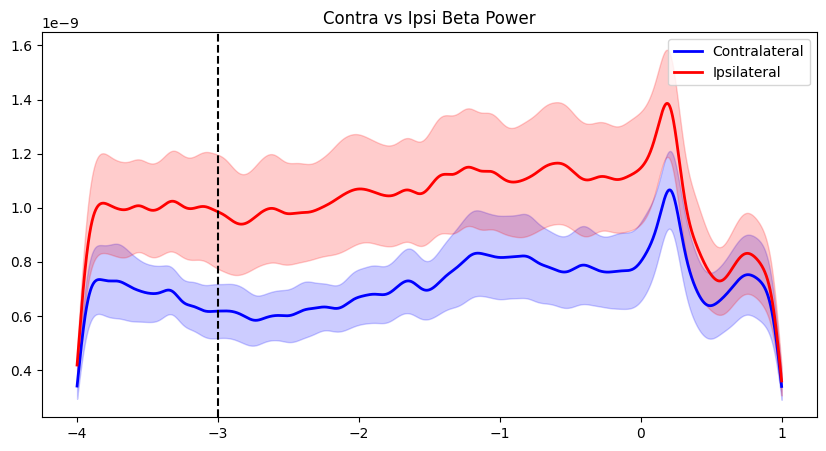

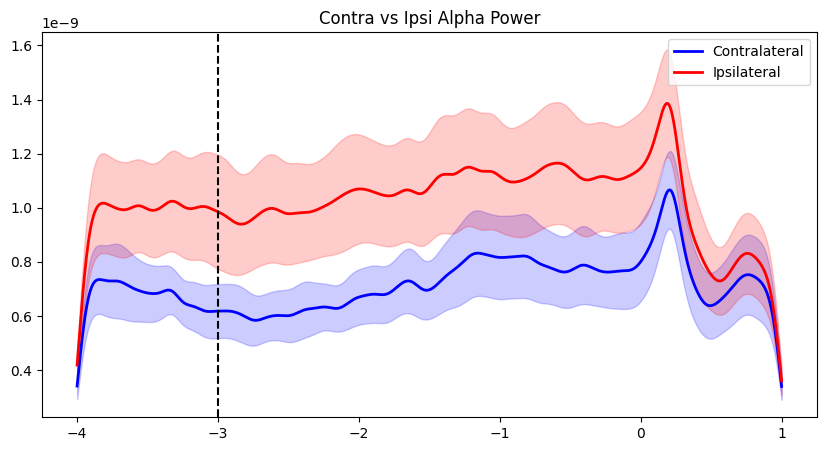

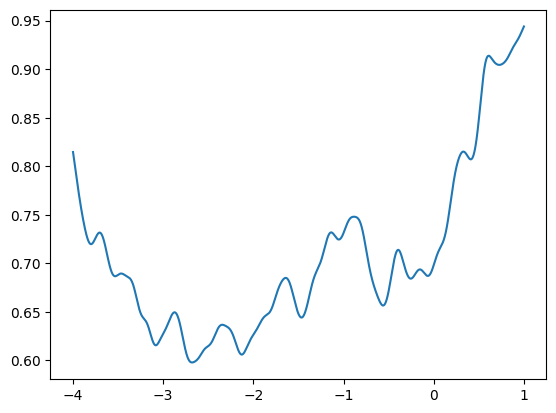

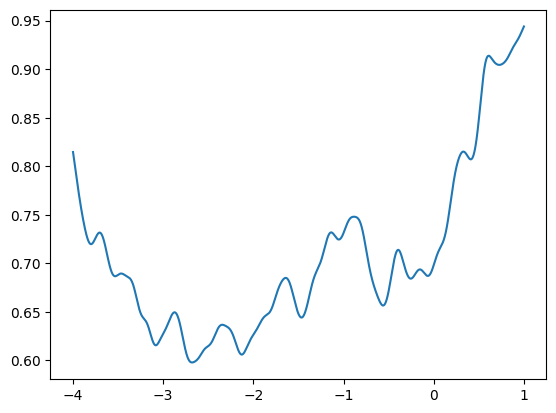

In [ ]:
# # # Create plot of the power time series for the left and right trials
with open('Path to saved data/tfr_list_left_stim_BBO.pkl', 'rb') as f:
    tfr_list_left = pickle.load(f)
with open('Path to saved data/tfr_list_right_stim_BBO.pkl', 'rb') as f:
    tfr_list_right = pickle.load(f)

# Define explicit channel lists
Left_channel = ['C3']    # Corresponds to C3
Right_channel = ['C4']   # Corresponds to C4

# Initialize lists to hold data extracted from each TFR object separately for each channel.
Alpha_power_left_C3 = []   # Left-stim: C3 (ipsilateral)
Alpha_power_left_C4 = []   # Left-stim: C4 (contralateral)
Alpha_power_right_C3 = []  # Right-stim: C3 (contralateral)
Alpha_power_right_C4 = []  # Right-stim: C4 (ipsilateral)

Beta_power_left_C3 = []
Beta_power_left_C4 = []
Beta_power_right_C3 = []
Beta_power_right_C4 = []

# Loop over all TFR objects (assumed to be in lists for left and right stimulation)
for i in range(len(tfr_list_left)):
    # For the alpha band: crop between 10 and 15 Hz
    tfr_left_alpha  = tfr_list_left[i].crop(fmin=10, fmax=12)
    tfr_right_alpha = tfr_list_right[i].crop(fmin=10, fmax=12)
    
    # Extract data explicitly for each channel and average across (e.g., frequency) dimensions.
    # (Assuming get_data returns an array of shape (n_epochs, n_channels, n_times); here we average over channels if needed.)
    temp_left_alpha_C3 = tfr_left_alpha.get_data(picks=Left_channel).mean(axis=1)
    temp_left_alpha_C4 = tfr_left_alpha.get_data(picks=Right_channel).mean(axis=1)
    temp_right_alpha_C3 = tfr_right_alpha.get_data(picks=Left_channel).mean(axis=1)
    temp_right_alpha_C4 = tfr_right_alpha.get_data(picks=Right_channel).mean(axis=1)
    
    Alpha_power_left_C3.append(temp_left_alpha_C3)
    Alpha_power_left_C4.append(temp_left_alpha_C4)
    Alpha_power_right_C3.append(temp_right_alpha_C3)
    Alpha_power_right_C4.append(temp_right_alpha_C4)
    
    # For the beta band: crop between 10 and 28 Hz
    tfr_left_beta  = tfr_list_left[i].crop(fmin=10, fmax=28)
    tfr_right_beta = tfr_list_right[i].crop(fmin=10, fmax=28)
    
    temp_left_beta_C3 = tfr_left_beta.get_data(picks=Left_channel).mean(axis=1)
    temp_left_beta_C4 = tfr_left_beta.get_data(picks=Right_channel).mean(axis=1)
    temp_right_beta_C3 = tfr_right_beta.get_data(picks=Left_channel).mean(axis=1)
    temp_right_beta_C4 = tfr_right_beta.get_data(picks=Right_channel).mean(axis=1)
    
    Beta_power_left_C3.append(temp_left_beta_C3)
    Beta_power_left_C4.append(temp_left_beta_C4)
    Beta_power_right_C3.append(temp_right_beta_C3)
    Beta_power_right_C4.append(temp_right_beta_C4)

# Convert the lists into arrays.
Alpha_power_left_C3  = np.array(Alpha_power_left_C3)
Alpha_power_left_C4  = np.array(Alpha_power_left_C4)
Alpha_power_right_C3 = np.array(Alpha_power_right_C3)
Alpha_power_right_C4 = np.array(Alpha_power_right_C4)

Beta_power_left_C3  = np.array(Beta_power_left_C3)
Beta_power_left_C4  = np.array(Beta_power_left_C4)
Beta_power_right_C3 = np.array(Beta_power_right_C3)
Beta_power_right_C4 = np.array(Beta_power_right_C4)

# Then compute the grand average across stimuli:
Contralateral_Alpha = ((Alpha_power_left_C4 + Alpha_power_right_C3) / 2).squeeze()
Ipsilateral_Alpha   = ((Alpha_power_left_C3 + Alpha_power_right_C4) / 2).squeeze()

Contralateral_Beta  = ((Beta_power_left_C4 + Beta_power_right_C3) / 2).squeeze()
Ipsilateral_Beta    = ((Beta_power_left_C3 + Beta_power_right_C4) / 2).squeeze()
times = tfr_list_left[0].times


# --- Beta Plot ---
# Compute means and SEMs for Beta power
contra_beta_mean = Contralateral_Beta.mean(axis=0)
contra_beta_sem  = Contralateral_Beta.std(axis=0) / np.sqrt(Contralateral_Beta.shape[0])
ipsi_beta_mean   = Ipsilateral_Beta.mean(axis=0)
ipsi_beta_sem    = Ipsilateral_Beta.std(axis=0) / np.sqrt(Ipsilateral_Beta.shape[0])

plt.figure(figsize=(10, 5))
# Fill patch for Contralateral Beta (red)
plt.fill_between(times, contra_beta_mean - contra_beta_sem, contra_beta_mean + contra_beta_sem,
                 color='b', alpha=0.2)
# Fill patch for Ipsilateral Beta (black)
plt.fill_between(times, ipsi_beta_mean - ipsi_beta_sem, ipsi_beta_mean + ipsi_beta_sem,
                 color='r', alpha=0.2)
# Plot the mean lines
plt.plot(times, contra_beta_mean, 'b-', linewidth=2, label='Contralateral')
plt.plot(times, ipsi_beta_mean, 'r-', linewidth=2, label='Ipsilateral')
plt.axvline(-3, color='black', linestyle='--')
plt.title('Contra vs Ipsi Beta Power')
plt.legend()
plt.show()

# --- Alpha Plot ---
# Compute means and SEMs for Alpha power
contra_alpha_mean = Contralateral_Alpha.mean(axis=0)
contra_alpha_sem  = Contralateral_Alpha.std(axis=0) / np.sqrt(Contralateral_Alpha.shape[0])
ipsi_alpha_mean   = Ipsilateral_Alpha.mean(axis=0)
ipsi_alpha_sem    = Ipsilateral_Alpha.std(axis=0) / np.sqrt(Ipsilateral_Alpha.shape[0])

plt.figure(figsize=(10, 5))
# Fill patch for Contralateral Alpha (red)
plt.fill_between(times, contra_alpha_mean - contra_alpha_sem, contra_alpha_mean + contra_alpha_sem,
                 color='b', alpha=0.2)
# Fill patch for Ipsilateral Alpha (black)
plt.fill_between(times, ipsi_alpha_mean - ipsi_alpha_sem, ipsi_alpha_mean + ipsi_alpha_sem,
                 color='r', alpha=0.2)
# Plot the mean lines
plt.plot(times, contra_alpha_mean, 'b-', linewidth=2, label='Contralateral')
plt.plot(times, ipsi_alpha_mean, 'r-', linewidth=2, label='Ipsilateral')
plt.axvline(-3, color='black', linestyle='--')
plt.title('Contra vs Ipsi Alpha Power')
plt.legend()
plt.show()

Beta_Ratio = contra_beta_mean/ipsi_beta_mean
plt.plot(times, Beta_Ratio)
plt.show()

Alpha_Ratio = contra_alpha_mean/ipsi_alpha_mean
plt.plot(times, Alpha_Ratio)
plt.show()


Now For EMG Lateralisation

In [ ]:
# -	EMG: To assess the lateralization of the EMG power in the beta band, we will compute a similar lateralization 
# measure as with the EEG data. This will first be done for each arm separately as follows: We will first compute 
# the time frequency representation of the epoched data for both arms. We will then compute the average TFR (for each 
# arm separately) for the trials where the stimulation was delivered on the same arm (ipsilateral trials), and the 
# trials where the stimulation was delivered on the other arm (contralateral trials). We will then compute the 
# lateralization measure, for each arm separately, as a percent change relative to the contralateral trials as follows: 
# ((ipsilateral-contralateral)/contralateral) x 100. Once this is computed for both arms, the values will be finally 
# pooled (averaged) thus yielding a single measure for EMG lateralization per participant (See van Ede et al., 2013). 

# Function to extract the lateralization index for the EMG data
def Extract_Lat_index_EMG(epochs, path,normalise_baseline = True):
    """
    Computes the EMG lateralization index for a given subject.

    Parameters:
    - sample_subject: mne.tfr object with EEG/EMG data and events.
    - event_id: dict mapping event names to IDs (e.g., {'Left': 1, 'Invalid': 3, 'Right': 2}).
    - expected_trials: int, expected number of trials for validation.

    Returns:
    - Mean_lat_index: float, average lateralization index across left and right arms.
    """

    left_data_time = epochs.get_data()[:, epochs.ch_names.index('EMG_left'), :]
    right_data_time = epochs.get_data()[:, epochs.ch_names.index('EMG_right'), :]

    # Normalise to the first second of each epoch
    if normalise_baseline:
        timebegin = np.argmin(np.abs(epochs.times - (-4)))
        timeend = np.argmin(np.abs(epochs.times - (-3)))
        right_mean = right_data_time[:,timebegin:timeend].mean(axis = 1, keepdims=True)
        right_std = right_data_time[:,timebegin:timeend].std(axis = 1, keepdims=True)
        right_data_time = (right_data_time - right_mean)/right_std

        left_mean = left_data_time[:,timebegin:timeend].mean(axis = 1, keepdims=True)
        left_std = left_data_time[:,timebegin:timeend].std(axis = 1, keepdims=True)
        left_data_time = (left_data_time - left_mean)/left_std

    # Compute RMS
    left_rms = np.sqrt(np.mean(left_data_time**2, axis=1))
    right_rms = np.sqrt(np.mean(right_data_time**2, axis=1))

    # Identify outliers using z-score
    z_thresh = 3  # Common threshold (adjustable)
    left_mean, left_std = np.mean(left_rms), np.std(left_rms)
    right_mean, right_std = np.mean(right_rms), np.std(right_rms)
    left_outliers = np.where((np.abs(left_rms - left_mean) / left_std) > z_thresh)[0]
    right_outliers = np.where((np.abs(right_rms - right_mean) / right_std) > z_thresh)[0]
    left_trials2use = np.ones(len(left_rms), dtype=bool)
    left_trials2use[left_outliers] = False
    right_trials2use = np.ones(len(right_rms), dtype=bool)
    right_trials2use[right_outliers] = False
    print(f'Number of outliers identified in left: {len(left_outliers)}')
    print(f'Number of outliers identified in right: {len(right_outliers)}')

    trials2use = {'Left': left_trials2use, 'Right': right_trials2use}
    # save to path
    source_path = path.split('/')[:-1]
    source_path = '/'.join(source_path) + '/'
    path = os.path.join(source_path, 'trials2use.npy')
    np.save(path, trials2use)

    # Then Z normalise both left and right data in the time domain, but without taking those outliers into consideration
    if not normalise_baseline:
        left_mean = left_data_time[left_trials2use,:].reshape(1,-1).mean(axis = 1)
        left_std = left_data_time[left_trials2use,:].reshape(1,-1).std(axis = 1)
        left_data_time = (left_data_time - left_mean)/left_std

        right_mean = right_data_time[right_trials2use,:].reshape(1,-1).mean(axis = 1)
        right_std = right_data_time[right_trials2use,:].reshape(1,-1).std(axis = 1)
        right_data_time = (right_data_time - right_mean)/right_std

    # Replace only the relevant channels with the normalized data
    left_data_time = np.expand_dims(left_data_time, axis=1)
    right_data_time = np.expand_dims(right_data_time, axis=1)

    new_data = np.concatenate([left_data_time, right_data_time], axis = 1)
    epochs_normalised = mne.EpochsArray(new_data, epochs.info, events=epochs.events, event_id=epochs.event_id, tmin=epochs.tmin)

    frequencies = np.arange(3, 51, 1)  # Define frequencies of interest
    n_cycles = frequencies/2
    sample_subject = epochs_normalised.compute_tfr(method = 'morlet', 
                                        freqs = frequencies,
                                        n_cycles = n_cycles,
                                        output='power',
                                        picks='emg',
                                        average=False, 
                                        return_itc=False)

    events = sample_subject.events
    event_id = {'Left': 1, 'Invalid':3, 'Right':2}

    left_data = sample_subject.data[:, sample_subject.ch_names.index('EMG_left'), :, :]
    right_data = sample_subject.data[:, sample_subject.ch_names.index('EMG_right'), :, :]

    assert left_data.shape[0] == right_data.shape[0], "Number of trials in the left and right hand data is not the same"

    Left_contra = left_data[events[:, 2] == event_id['Right'],:,:]
    left_contra_inclusions = left_trials2use[events[:, 2] == event_id['Right']]
    Left_ipsi = left_data[events[:, 2] == event_id['Left'],:,:]
    left_ipsi_inclusions = left_trials2use[events[:, 2] == event_id['Left']]

    Right_contra = right_data[events[:, 2] == event_id['Left'],:,:]
    right_contra_inclusions = right_trials2use[events[:, 2] == event_id['Left']]
    Right_ipsi = right_data[events[:, 2] == event_id['Right'],:,:]
    right_ipsi_inclusions = right_trials2use[events[:, 2] == event_id['Right']]

    assert Left_contra.shape[0] == Left_ipsi.shape[0] == Right_contra.shape[0] == Right_ipsi.shape[0] == 45, "The number of trials for the contra and ipsi is incorrect"

    Left_contra_mean = Left_contra[left_contra_inclusions,:,:].mean(axis=0)
    Left_ipsi_mean = Left_ipsi[left_ipsi_inclusions,:,:].mean(axis=0)
    Right_contra_mean = Right_contra[right_contra_inclusions,:,:].mean(axis=0)
    Right_ipsi_mean = Right_ipsi[right_ipsi_inclusions,:,:].mean(axis=0)

    # Compute the lateralization index for the left and right channels - ((ipsilateral-contralateral)/contralateral) x 100
    Left_lat_index = ((Left_ipsi_mean - Left_contra_mean)/Left_contra_mean)*100
    Right_lat_index = ((Right_ipsi_mean - Right_contra_mean)/Right_contra_mean)*100

    # average this percentage value for the two channels (left and right)
    Mean_lat_index = (Left_lat_index + Right_lat_index)/2
    return Mean_lat_index, Left_lat_index, Right_lat_index

EEG_filenames, EMG_filenames = Load_EEG_EMG_Paths()

# Load the EMG data
Lat_index_EMG = []
Left_lat_index_EMG = []
Right_lat_index_EMG = []
for idx, file in enumerate(EMG_filenames):
    This_subject = mne.read_epochs(file)
    Mean_lat_index, Left_lat_index, Right_lat_index = Extract_Lat_index_EMG(This_subject, file)
    Lat_index_EMG.append(Mean_lat_index)
    Left_lat_index_EMG.append(Left_lat_index)
    Right_lat_index_EMG.append(Right_lat_index)

# convert to numpy array
Lat_index_EMG = np.array(Lat_index_EMG)
Left_lat_index_EMG = np.array(Left_lat_index_EMG)
Right_lat_index_EMG = np.array(Right_lat_index_EMG)

# create a save path if it doesn't exist
savepath = "Path to save data/Processed/Lateralisation_indices_EMG/"
if not os.path.exists(savepath):
    os.makedirs(savepath)
# save the lateralization index for the EMG data
np.save(os.path.join(savepath, "Lat_index_EMG.npy"), Lat_index_EMG)
np.save(os.path.join(savepath, "Left_lat_index_EMG.npy"), Left_lat_index_EMG)
np.save(os.path.join(savepath, "Right_lat_index_EMG.npy"), Right_lat_index_EMG)


Outliers: [ 7 17 27]


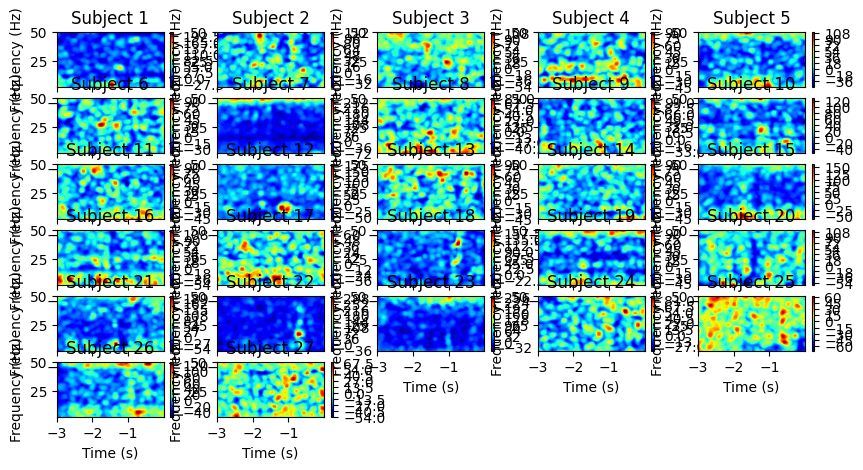

In [221]:
# Identify outliers in the lateralisation index before running the cluster based permutation test
savepath = "Path to save data/Processed/Lateralisation_indices_EMG/"
Lat_index_EMG = np.load(os.path.join(savepath, "Lat_index_EMG.npy"))
Left_lat_index_EMG = np.load(os.path.join(savepath, "Left_lat_index_EMG.npy"))
Right_lat_index_EMG = np.load(os.path.join(savepath, "Right_lat_index_EMG.npy"))

data = Lat_index_EMG
Frequencies = np.arange(3,51,1)
Times = np.linspace(-3, 1, 4001)

# limit the data to the time range of -3 to 0 seconds
data = data[:,:,np.argmin(np.abs(Times - -3)):np.argmin(np.abs(Times - 0))]
Times = Times[np.argmin(np.abs(Times - -3)):np.argmin(np.abs(Times - 0))]

freq10 = np.argmin(np.abs(Frequencies - 1))
freq30 = np.argmin(np.abs(Frequencies - 40))
timebegin = np.argmin(np.abs(Times - -4))
timeend = np.argmin(np.abs(Times - 0))


index_mean = np.mean(data[:,:,timebegin:timeend], axis=(1,2))

# Compute IQR
Q1 = np.percentile(index_mean, 25)
Q3 = np.percentile(index_mean, 75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = np.where((index_mean < lower_bound) | (index_mean > upper_bound))[0]
print(f'Outliers: {outliers}')
data = np.delete(data, outliers, axis=0)  # Remove outliers


# Visually inspect the data for strange values
plt.figure(figsize=(10, 5))
for i in range(data.shape[0]):
    plt.subplot(6,5,i+1)
    plt.contourf(Times, Frequencies, data[i,:,:].squeeze(), levels=100, cmap='jet')
    plt.colorbar()
    plt.title('Subject '+str(i+1))
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
plt.show()


Final shape of the data: (27, 48, 3000)
Using a threshold of -1.705618
stat_fun(H1): min=-3.3894022623665374 max=4.597702674706373
Running initial clustering …
Found 23 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

T_obs shape: (47, 3000)
Cluster p values shape: (23,)
H0 shape: (1000,)
Number of significant clusters: 0


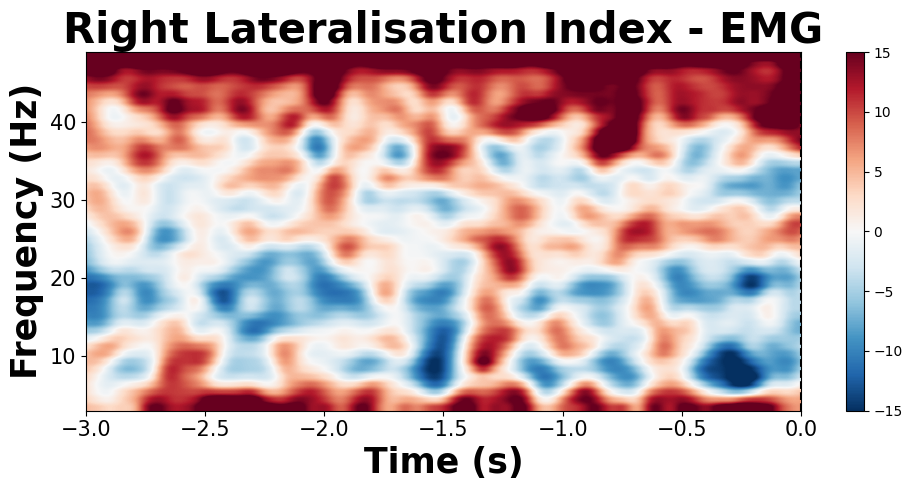

In [323]:
# Check the lat indices for EMG data
savepath = "Path to save data/Processed/Lateralisation_indices_EMG/"
Left_lat_index_EMG = np.load(os.path.join(savepath, "Left_lat_index_EMG.npy"))
Right_lat_index_EMG = np.load(os.path.join(savepath, "Right_lat_index_EMG.npy"))
Lat_index_EMG = np.load(os.path.join(savepath, "Lat_index_EMG.npy"))

data = Right_lat_index_EMG
Frequencies = np.arange(3,51,1)
Times = np.linspace(-3, 1, 4001)

# limit the data to the time range of -3 to 0 seconds
data = data[:,:,np.argmin(np.abs(Times - -3)):np.argmin(np.abs(Times - 0))]
Times = Times[np.argmin(np.abs(Times - -3)):np.argmin(np.abs(Times - 0)) + 1]

# remove the outliers
timebegin = np.argmin(np.abs(Times - -3))
timeend = np.argmin(np.abs(Times - 0))
index_mean = np.mean(data[:,:,timebegin:timeend], axis=(1,2))

# Compute IQR
Q1 = np.percentile(index_mean, 25)
Q3 = np.percentile(index_mean, 75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = np.where((index_mean < lower_bound) | (index_mean > upper_bound))[0]

data = np.delete(data, outliers, axis=0)  # Remove outliers

print(f'Final shape of the data: {data.shape}')

# Reduce the data to only include the time points between -3 and 0 seconds
timebegin = np.argmin(np.abs(Times - -3))
timeend = np.argmin(np.abs(Times - 0))
freqbegin = np.argmin(np.abs(Frequencies - 3))
freqend = np.argmin(np.abs(Frequencies - 50))
data = data[:,freqbegin:freqend,timebegin:timeend]
Times = Times[timebegin:timeend]
Frequencies = Frequencies[freqbegin:freqend]

# Perform a cluster-based permutation test to test for a significant beta suppression effect
# Define your data (subjects x frequencies x time)
n_permutations = 1000
threshold = None
# Reshape the data to be in the format expected by the cluster test (observations, space)
# In this case, space is (frequencies, time)
adjacency = mne.stats.combine_adjacency(
    data.shape[1], data.shape[2]
)

# Perform the one-sample cluster-based permutation t-test
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    data, n_permutations=n_permutations, threshold=threshold, tail=-1, out_type="indices"  # Testing if the data is less than 0
    )
print(f"T_obs shape: {T_obs.shape}")
print(f"Cluster p values shape: {cluster_p_values.shape}")
print(f"H0 shape: {H0.shape}")

# Find significant clusters
significant_clusters = np.where(cluster_p_values < 0.05)[0]
print(f'Number of significant clusters: {len(significant_clusters)}')

# Plot the T-values first
plt.figure(figsize=(10, 5))
plt.imshow(
    data.mean(axis=0), aspect='auto', origin='lower', cmap='RdBu_r', 
    extent=[Times[0], Times[-1] + (Times[1] - Times[0]), Frequencies[0], Frequencies[-1]]
)
plt.colorbar()
plt.title('Right Lateralisation Index - EMG', fontsize=30, fontweight='bold')
plt.xlabel('Time (s)', fontsize=25, fontweight='bold')
plt.ylabel('Frequency (Hz)', fontsize=25, fontweight='bold')
plt.axvline(0, color='black', linestyle='--')
plt.clim(-15, 15)

# Loop over each significant cluster and add masks with labels
for i_clu, clu_idx in enumerate(significant_clusters):
    cluster_indices = clusters[clu_idx]  # Tuple of (frequency indices, time indices)
    freq_indices, time_indices = cluster_indices
    cluster_times = Times[time_indices]
    cluster_frequencies = Frequencies[freq_indices]

    print(f"Cluster {i_clu + 1} significant with p-value: {cluster_p_values[clu_idx]}")
    print(f'Cluster time range: {np.min(cluster_times):.2f} - {np.max(cluster_times):.2f} s')
    print(f'Cluster frequency range: {np.min(cluster_frequencies):.2f} - {np.max(cluster_frequencies):.2f} Hz')

    # Create a mask for this cluster
    cluster_mask = np.zeros(T_obs.shape, dtype=bool)
    cluster_mask[freq_indices, time_indices] = True

    contour = plt.contour(cluster_mask, colors='black', linewidths=1, origin='lower', 
                           extent=[Times[0], Times[-1] + (Times[1] - Times[0]), Frequencies[0], Frequencies[-1]])

    # Add labels at the center of each cluster
    mid_time = (np.min(cluster_times) + np.max(cluster_times)) / 2
    mid_freq = (np.min(cluster_frequencies) + np.max(cluster_frequencies)) / 2
    plt.text(mid_time, mid_freq, f'P = {cluster_p_values[clu_idx]:.3f}', color='black', fontsize=20, 
             ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()   
plt.savefig('Path to save figure/EMG_cluster_test_Right_lateralisation.jpg', dpi=300) 
plt.show()

In [ ]:

# Hypothesis 2: Coherence between EMG and the contralateral EEG is larger during stimulus anticipation.
# Step 1: We will first compute the coherence across all trials, between each EMG channel (left and right) and each 
# of the selected contralateral and ipsilateral EEG channels. This will be done for each arm separately. All the 
# contralateral spectra will then be averaged together to form a single contralateral coherence spectrum per participant. 
# Similarly, all the ipsilateral spectra will be averaged together to form a single ipsilateral spectrum per participant. 
# As was observed in van Ede et al., 2013, we expect that the coherence will be higher with contralateral EEG channels vs 
# ipsilateral channels. We will perform a cluster-based permutation test between the contralateral coherence spectra and 
# the ipsilateral coherence spectra to test this expected difference. We will use the one tailed dependent samples-t 
# statistic as our test statistic.

# Function to compute coherence between EMG and each of the contralateral and ipsilateral EEG channels across all trials
def Compute_coherence_contra_ipsi(Subject_EEG, Subject_EMG, tmin, tmax, Left_channels, Right_channels, trials2use):
    fmin = 0
    fmax = 60
    fs = Subject_EEG.info['sfreq']
    bw = 4
    left_EMG = Subject_EMG.crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_left').squeeze()
    right_EMG = Subject_EMG.crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_right').squeeze()

    left_EEG = []
    right_EEG = []
    for chan in Left_channels:
        left_EEG.append(Subject_EEG.crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
    for chan in Right_channels:
        right_EEG.append(Subject_EEG.crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
    left_EEG = np.array(left_EEG)
    right_EEG = np.array(right_EEG)
    assert Subject_EEG.info['sfreq'] == Subject_EMG.info['sfreq'], "Sampling frequency is not 1000 Hz"

    # For the left arm
    left_contra_coherence = {}
    left_ipsi_coherence = {}
    for channel in range(left_EEG.shape[0]):
        contra_coherence = []
        ipsi_coherence = []
        for trial in range(left_EMG.shape[0]):
            if not trials2use['Left'][trial]:
                continue
            frequencies, coherence = Compute_coherence_multitaper(left_EMG[trial,:], left_EEG[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
            ipsi_coherence.append(coherence)

            frequencies, coherence = Compute_coherence_multitaper(left_EMG[trial,:], right_EEG[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
            contra_coherence.append(coherence)
        contra_coherence = np.array(contra_coherence)
        ipsi_coherence = np.array(ipsi_coherence)
        left_contra_coherence[Right_channels[channel]] = contra_coherence.mean(axis=0)
        left_ipsi_coherence[Left_channels[channel]] = ipsi_coherence.mean(axis=0)

    # Right Arm
    right_contra_coherence = {}
    right_ipsi_coherence = {}

    for channel in range(right_EEG.shape[0]):
        contra_coherence = []
        ipsi_coherence = []
        for trial in range(right_EMG.shape[0]):
            if not trials2use['Right'][trial]:
                continue
            frequencies, coherence = Compute_coherence_multitaper(right_EMG[trial,:], right_EEG[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
            ipsi_coherence.append(coherence)

            frequencies, coherence = Compute_coherence_multitaper(right_EMG[trial,:], left_EEG[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
            contra_coherence.append(coherence)
        contra_coherence = np.array(contra_coherence)
        ipsi_coherence = np.array(ipsi_coherence)
        right_contra_coherence[Left_channels[channel]] = contra_coherence.mean(axis=0)
        right_ipsi_coherence[Right_channels[channel]] = ipsi_coherence.mean(axis=0)

    return left_contra_coherence, left_ipsi_coherence, right_contra_coherence, right_ipsi_coherence, frequencies

# Parameters for the coherence calculation
tmin = -3.0
tmax = 0
All_contra_coherence = []
All_ipsi_coherence = []
All_right_contra_coherence = []
All_left_contra_coherence = []
All_right_ipsi_coherence = []
All_left_ipsi_coherence = []
EEG_filenames, EMG_filenames, Behavioural_filenames = Load_EEG_EMG_Paths()
# Load the EEG and EMG data
for sub2load in range(len(EEG_filenames)):
    EEG_path = EEG_filenames[sub2load]
    EMG_path = EMG_filenames[sub2load]
    Subject_EEG = mne.read_epochs(EEG_path)
    Subject_EMG = mne.read_epochs(EMG_path)
    # Define channels of interest:
    # Left_channels = ['FC1', 'C3', 'CP1']
    # Right_channels = ['FC2', 'C4', 'CP2']

    Left_channels = [ 'C3']
    Right_channels = ['C4']
    
    source_path = EMG_path.split('/')[:-1]
    source_path = '/'.join(source_path) + '/'
    path = os.path.join(source_path, 'trials2use.npy')
    trials2use = np.load(path, allow_pickle=True).item()
    
    assert Check_trial_match(Subject_EEG, Subject_EMG), "The trials order does not match in the EEG and EMG data"

    left_contra_coherence, left_ipsi_coherence, right_contra_coherence, right_ipsi_coherence, frequencies = Compute_coherence_contra_ipsi(Subject_EEG, Subject_EMG, 
                                                                                  tmin, tmax, Left_channels, Right_channels, 
                                                                                  trials2use)

    All_right_contra_coherence.append(right_contra_coherence)
    All_left_contra_coherence.append(left_contra_coherence)
    All_right_ipsi_coherence.append(right_ipsi_coherence)
    All_left_ipsi_coherence.append(left_ipsi_coherence)
Coherence_frequencies = frequencies

coherence_data = {
    "Coherence_frequencies": Coherence_frequencies,
    "All_right_contra_coherence": All_right_contra_coherence,
    "All_left_contra_coherence": All_left_contra_coherence,
    "All_right_ipsi_coherence": All_right_ipsi_coherence,
    "All_left_ipsi_coherence": All_left_ipsi_coherence
}

with open("Path to save data/H2_Step1_All_Trials_Contra_vs_Ipsi_Only_C.pkl", "wb") as f:
    pickle.dump(coherence_data, f)


Outlier participants for ipsi (Z-score method on mean coherence): [3]
Outlier participants for contra (Z-score method on mean coherence): [3]


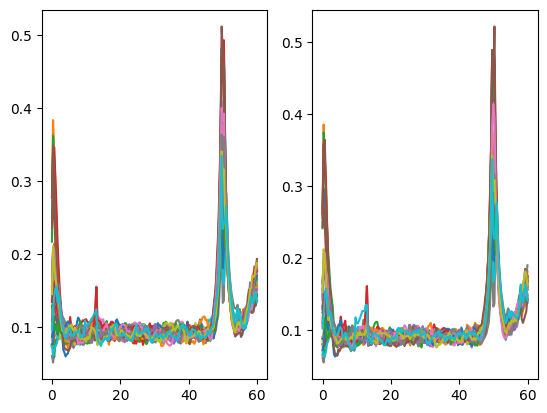

Using a threshold of 4.012973
stat_fun(H1): min=8.830210707749644e-05 max=11.186207414921737
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

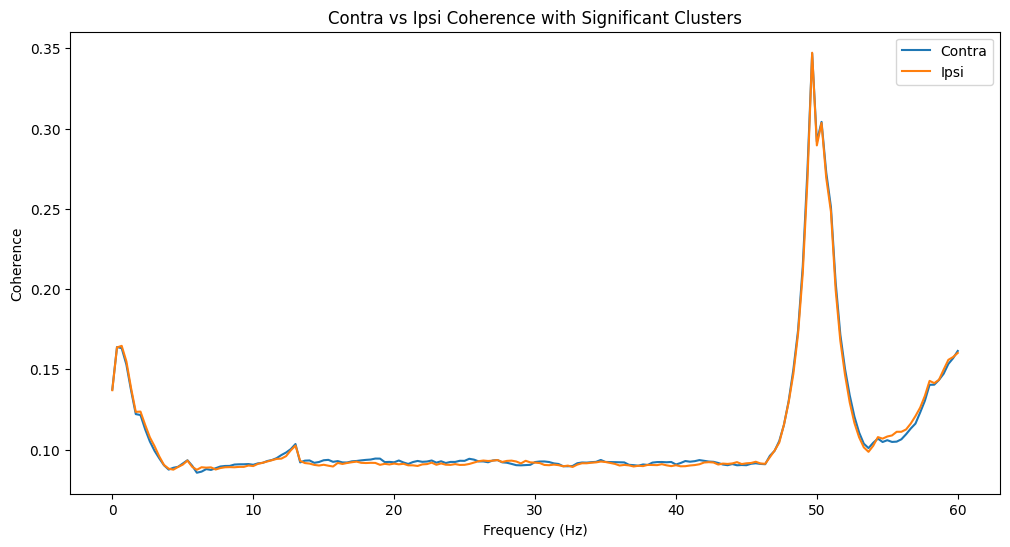

Cluster 1 p-value: 0.967
Cluster 2 p-value: 0.879
Cluster 3 p-value: 0.911
Cluster 4 p-value: 0.979
Cluster 5 p-value: 0.888
Cluster 6 p-value: 0.822
Cluster 7 p-value: 0.508
Cluster 8 p-value: 0.873


In [355]:
########################################## Perform the Cluster Based Permutation Test ################################ 
# Load the saved data
with open("Path to save data/H2_Step1_All_Trials_Contra_vs_Ipsi_Only_C.pkl", "rb") as f:
    coherence_data = pickle.load(f)

# Access the individual components
Coherence_frequencies = coherence_data["Coherence_frequencies"]
All_right_contra_coherence = coherence_data["All_right_contra_coherence"]
All_left_contra_coherence = coherence_data["All_left_contra_coherence"]
All_right_ipsi_coherence = coherence_data["All_right_ipsi_coherence"]
All_left_ipsi_coherence = coherence_data["All_left_ipsi_coherence"]
Left_channels = ['C3']
Right_channels = ['C4']

############ For the left arm #############
Right_Chan_of_interest = Right_channels
Left_Chan_of_interest = Left_channels
Left_contra = []
for index in range(len(All_left_contra_coherence)):
    temp = []
    for chan in Right_Chan_of_interest:
        temp.append(All_left_contra_coherence[index][chan])
    temp = np.array(temp)
    Left_contra.append(temp.mean(axis=0))
Left_contra = np.array(Left_contra)

Left_ipsi = []
for index in range(len(All_left_ipsi_coherence)):
    temp = []
    for chan in Left_Chan_of_interest:
        temp.append(All_left_ipsi_coherence[index][chan])
    temp = np.array(temp)
    Left_ipsi.append(temp.mean(axis=0))
Left_ipsi = np.array(Left_ipsi)

############ For the right arm #############
Right_contra = []
for index in range(len(All_right_contra_coherence)):
    temp = []
    for chan in Left_Chan_of_interest:
        temp.append(All_right_contra_coherence[index][chan])
    temp = np.array(temp)
    Right_contra.append(temp.mean(axis=0))
Right_contra = np.array(Right_contra)


Right_ipsi = []
for index in range(len(All_right_ipsi_coherence)):
    temp = []
    for chan in Right_Chan_of_interest:
        temp.append(All_right_ipsi_coherence[index][chan])
    temp = np.array(temp)
    Right_ipsi.append(temp.mean(axis=0))
Right_ipsi = np.array(Right_ipsi)

################################################### 
############ Choose which arms to use #############
################################################### 
Arms = 'Both'  # Either Right, Left or Both
if Arms == 'Both':
    All_contra = []
    All_ipsi = []
    for index in range(Right_ipsi.shape[0]):
        temp_contra = np.concatenate((np.expand_dims(Right_contra[index, :], axis=0),
                       np.expand_dims(Left_contra[index, :], axis=0)), axis=0)        
        All_contra.append(np.mean(temp_contra, axis=0))

        temp_ipsi = np.concatenate((np.expand_dims(Right_ipsi[index, :], axis=0),
                       np.expand_dims(Left_ipsi[index, :], axis=0)), axis=0)        
        All_ipsi.append(np.mean(temp_ipsi, axis=0))
    All_contra = np.array(All_contra)
    All_ipsi = np.array(All_ipsi)
elif Arms == 'Right':
    All_contra = Right_contra
    All_ipsi = Right_ipsi
elif Arms == 'Left':
    All_contra = Left_contra
    All_ipsi = Left_ipsi


from scipy.stats import zscore

# Compute mean coherence across frequencies for each participant
outlier_thresh = 2
participant_means = np.mean(All_ipsi, axis=1)
z_scores = zscore(participant_means)
outliers_ipsi = np.where(np.abs(z_scores) > outlier_thresh)[0]
print("Outlier participants for ipsi (Z-score method on mean coherence):", outliers_ipsi)

participant_means = np.mean(All_contra, axis=1)
z_scores = zscore(participant_means)
outliers_contra = np.where(np.abs(z_scores) > outlier_thresh)[0]
print("Outlier participants for contra (Z-score method on mean coherence):", outliers_contra)

# Put the contra and ipsi outliers in a single list without repetition
outliers = np.concatenate((outliers_ipsi, outliers_contra))
outliers = np.unique(outliers)

# plot all 30 spectra for the contra and ipsi in subplots
plt.subplot(1, 2, 1)
plt.plot(Coherence_frequencies, All_contra.T, label='Contra')
plt.subplot(1, 2, 2)
plt.plot(Coherence_frequencies, All_ipsi.T, label='Ipsi')
plt.show()

# Remove the outliers from the data
All_contra = np.delete(All_contra, outliers, axis=0)
All_ipsi = np.delete(All_ipsi, outliers, axis=0)


###########################################################
####### Extract only the beta range (13 - 35) #############
###########################################################
Limit_test = False
if Limit_test:
    minfreq = 13
    maxfreq = 38
    beta_idx = np.where((Coherence_frequencies >= minfreq) & (Coherence_frequencies <= maxfreq))[0]
    All_contra = All_contra[:, beta_idx]
    All_ipsi = All_ipsi[:, beta_idx]
    Coherence_frequencies = Coherence_frequencies[beta_idx]

# Prepare the data for the test
X = [All_contra, All_ipsi]

# Perform the cluster-based permutation test
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(X, n_permutations=1000, threshold=None, tail=1, n_jobs=1, verbose=True)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(Coherence_frequencies, All_contra.mean(axis=0), label='Contra')
plt.plot(Coherence_frequencies, All_ipsi.mean(axis=0), label='Ipsi')

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend()
plt.title('Contra vs Ipsi Coherence with Significant Clusters')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.show()

# Print the p-values of the clusters
for i, p_val in enumerate(cluster_p_values):
    print(f"Cluster {i+1} p-value: {p_val}")

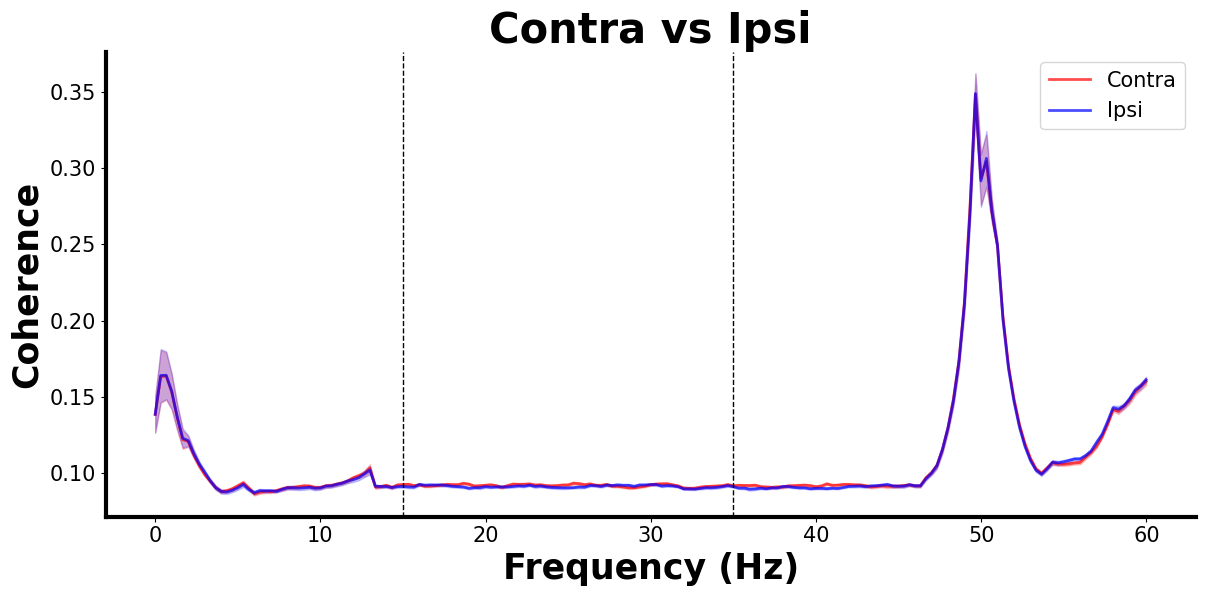

In [331]:
# Plotting
# Compute means and SEMs for coherence data
contra_mean = All_contra.mean(axis=0)
contra_sem = All_contra.std(axis=0) / np.sqrt(All_contra.shape[0])
ipsi_mean = All_ipsi.mean(axis=0)
ipsi_sem = All_ipsi.std(axis=0) / np.sqrt(All_ipsi.shape[0])

plt.figure(figsize=(12, 6))

# Plot patches for standard error
plt.fill_between(Coherence_frequencies, contra_mean - contra_sem, contra_mean + contra_sem,
                 color='red', alpha=0.2)
plt.fill_between(Coherence_frequencies, ipsi_mean - ipsi_sem, ipsi_mean + ipsi_sem,
                 color='blue', alpha=0.2)

# Plot mean lines (red for contra, blue for ipsi)
plt.plot(Coherence_frequencies, contra_mean, 'r-', linewidth=2, label='Contra', alpha = 0.7)
plt.plot(Coherence_frequencies, ipsi_mean, 'b-', linewidth=2, label='Ipsi', alpha = 0.7)

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend(fontsize=15)
plt.title('Contra vs Ipsi', fontsize=30, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
plt.axvline(x=15, color='black', linestyle='--', linewidth=1)
plt.axvline(x=35, color='black', linestyle='--', linewidth=1)
plt.ylabel('Coherence', fontsize=25, fontweight='bold')
plt.tight_layout()
# increase size of ticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('Path to save figure/Contra_Ipsi_Mean_Coherence_H2.jpg')
plt.show()

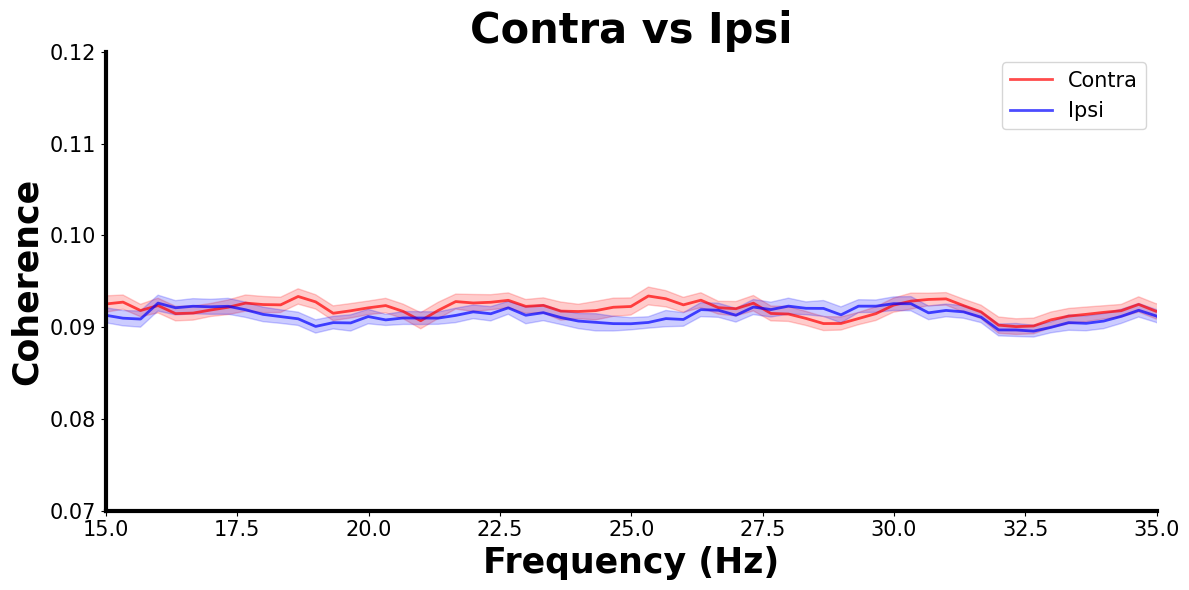

In [332]:
# Plotting
# Compute means and SEMs for coherence data
contra_mean = All_contra.mean(axis=0)
contra_sem = All_contra.std(axis=0) / np.sqrt(All_contra.shape[0])
ipsi_mean = All_ipsi.mean(axis=0)
ipsi_sem = All_ipsi.std(axis=0) / np.sqrt(All_ipsi.shape[0])

plt.figure(figsize=(12, 6))

# Plot patches for standard error
plt.fill_between(Coherence_frequencies, contra_mean - contra_sem, contra_mean + contra_sem,
                 color='red', alpha=0.2)
plt.fill_between(Coherence_frequencies, ipsi_mean - ipsi_sem, ipsi_mean + ipsi_sem,
                 color='blue', alpha=0.2)

# Plot mean lines (red for contra, blue for ipsi)
plt.plot(Coherence_frequencies, contra_mean, 'r-', linewidth=2, label='Contra', alpha = 0.7)
plt.plot(Coherence_frequencies, ipsi_mean, 'b-', linewidth=2, label='Ipsi', alpha = 0.7)

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend(fontsize=15)
plt.title('Contra vs Ipsi', fontsize=30, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
plt.xlim(15, 35)
plt.ylim(.07, 0.12)
plt.ylabel('Coherence', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Contra_Ipsi_Mean_Coherence_H2_inset.jpg')
plt.show()

In [ ]:
# -	Step 2: To then test our hypothesis that the coherence between EMG and contralateral EEG is larger during the anticipation 
# of the nociceptive stimulus, we will compute the coherence between each of the EMG channels and the selected contralateral 
# EEG channels, but only for the trials when the stimulation was delivered to the ipsilateral arm (the EMG arm). This will provide, 
# for each participant, an estimate of the coherence between muscular and contralateral EEG activity during the anticipation 
# of the nociceptive stimulus. This will be performed for each arm separately first. We will then average these coherence spectra 
# together to compute a single estimate of coherence during stimulus anticipation for each participant. Finally, to test our 
# hypothesis of increased coherence during the anticipation of a nociceptive stimulus, we will perform another cluster-based 
# permutation test where we will compare this spectrum with the overall coherence spectra computed in the previous step.

# Function to compute coherence between EMG and each of the contralateral and ipsilateral EEG channels across all trials
def Extract_Anticipatory_Coherence(Subject_EEG, Subject_EMG, tmin, tmax, Left_channels, Right_channels, trials2use):
    fmin = 0
    fmax = 60
    fs = Subject_EEG.info['sfreq']
    bw = 4
    left_EMG = Subject_EMG['Left'].crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_left').squeeze()
    left_trials2use = trials2use['Left'][Subject_EMG.events[:,2] == Subject_EMG.event_id['Left']]
    right_EMG = Subject_EMG['Right'].crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_right').squeeze()
    right_trials2use = trials2use['Right'][Subject_EMG.events[:,2] == Subject_EMG.event_id['Right']]

    left_EEG = []
    right_EEG = []
    for chan in Left_channels:
        left_EEG.append(Subject_EEG['Right'].crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
    for chan in Right_channels:
        right_EEG.append(Subject_EEG['Left'].crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
    left_EEG = np.array(left_EEG)
    right_EEG = np.array(right_EEG)
    assert Subject_EEG.info['sfreq'] == Subject_EMG.info['sfreq'], "Sampling frequency is not 1000 Hz"

    # For the left arm
    left_contra_coherence = {}
    for channel in range(right_EEG.shape[0]):
        contra_coherence = []
        for trial in range(left_EMG.shape[0]):
            if not left_trials2use[trial]:
                continue
            frequencies, coherence = Compute_coherence_multitaper(left_EMG[trial,:], right_EEG[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
            contra_coherence.append(coherence)
        contra_coherence = np.array(contra_coherence)
        left_contra_coherence[Right_channels[channel]] = contra_coherence.mean(axis=0)

    # Right Arm
    right_contra_coherence = {} 
    for channel in range(left_EEG.shape[0]):
        contra_coherence = []
        for trial in range(right_EMG.shape[0]):
            if not right_trials2use[trial]:
                continue
            frequencies, coherence = Compute_coherence_multitaper(right_EMG[trial,:], left_EEG[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
            contra_coherence.append(coherence)
        contra_coherence = np.array(contra_coherence)
        right_contra_coherence[Left_channels[channel]] = contra_coherence.mean(axis=0)

    return left_contra_coherence, right_contra_coherence, frequencies


# Parameters for the coherence calculation
tmin = -3.0
tmax = 0.0
All_anticipatory_coherence = []
Anticipatory_frequencies = []
All_right_anticipatory = []
All_left_anticipatory = []
EEG_filenames, EMG_filenames, Behaviour_filenames = Load_EEG_EMG_Paths()

# Load the EEG and EMG data
for sub2load in range(len(EEG_filenames)):
    EMG_path = EMG_filenames[sub2load]
    EEG_path = EEG_filenames[sub2load]
    Subject_EEG = mne.read_epochs(EEG_path)
    Subject_EMG = mne.read_epochs(EMG_path)
    # Define channels of interest:
    Left_channels = ['C3']
    Right_channels = ['C4']

    source_path = EMG_path.split('/')[:-1]
    source_path = '/'.join(source_path) + '/'
    path = os.path.join(source_path, 'trials2use.npy')
    trials2use = np.load(path, allow_pickle=True).item()

    assert Check_trial_match(Subject_EEG, Subject_EMG), "The trials order does not match in the EEG and EMG data"

    Left_coh, Right_coh, Anticipatory_frequencies = Extract_Anticipatory_Coherence(Subject_EEG, Subject_EMG, tmin, tmax, Left_channels, Right_channels, trials2use)
    All_right_anticipatory.append(Right_coh)
    All_left_anticipatory.append(Left_coh)

Anticipatory_coherences = {
    "Anticipatory_frequencies": Anticipatory_frequencies,
    "All_right_anticipatory": All_right_anticipatory,
    "All_left_anticipatory": All_left_anticipatory,
}

with open("Path to save data/H2_Step2_Anticipatory_Trials_Contra_Coherence.pkl", "wb") as f:
    pickle.dump(Anticipatory_coherences, f)

Outlier participants for anticipatory (Z-score method on mean coherence): [2 5]
Outlier participants for contra (Z-score method on mean coherence): [2 4]
Outlier participants for ipsi (Z-score method on mean coherence): [2 4]
Using a threshold of 4.009868
stat_fun(H1): min=1.1076124610255542e-05 max=9.785891854756763
Running initial clustering …
Found 11 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

No significant clusters found for Anticipatory vs Ipsi


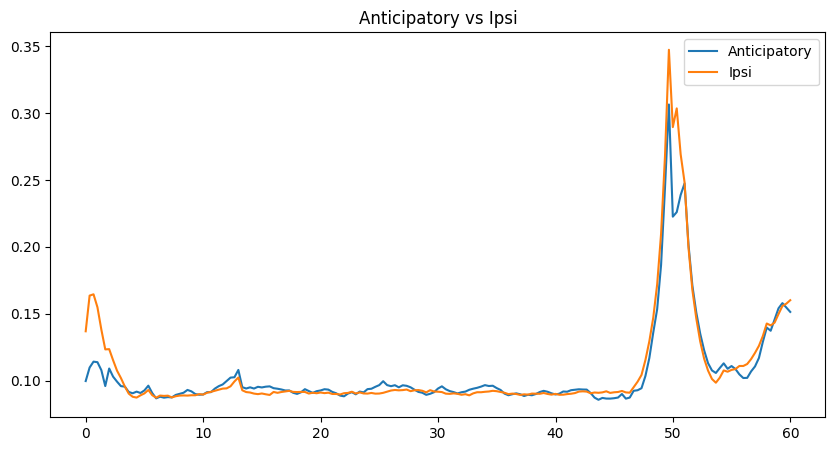

Using a threshold of 4.009868
stat_fun(H1): min=3.897912051989371e-05 max=8.45073639342203
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

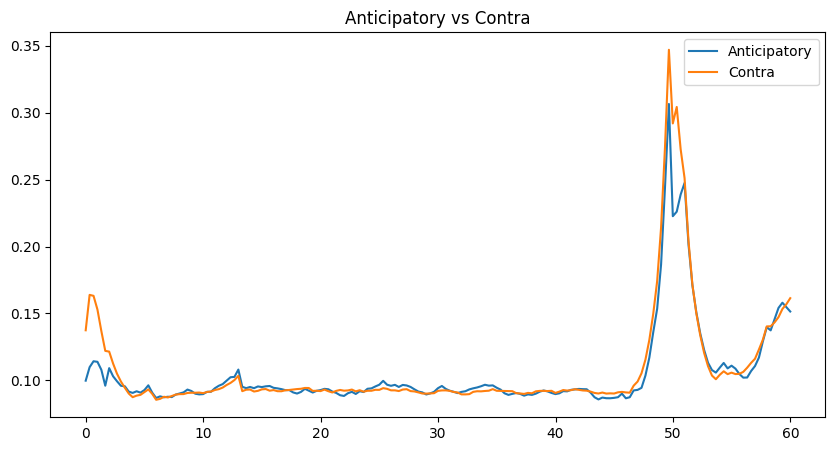

No significant clusters found for Anticipatory vs Contra


In [358]:

# Perform a cluster-based permutation test between the contralateral coherence spectra and the ipsilateral coherence spectra
# Contra and ipsi coherence spectra as input to the test

# Load the saved data
with open("Path to save data/H2_Step2_Anticipatory_Trials_Contra_Coherence.pkl", "rb") as f:
    Anticipatory_coherences = pickle.load(f)

Anticipatory_frequencies = Anticipatory_coherences["Anticipatory_frequencies"]
All_right_anticipatory = Anticipatory_coherences["All_right_anticipatory"]
All_left_anticipatory = Anticipatory_coherences["All_left_anticipatory"]
Left_channels = ['C3']
Right_channels = ['C4']


################### For the Left Arm ################ 
Chan_of_interest = Right_channels
Left_anticipatory = []
for index in range(len(All_left_anticipatory)):
    temp = []
    for chan in Chan_of_interest:
        temp.append(All_left_anticipatory[index][chan])
    temp = np.array(temp)
    Left_anticipatory.append(temp.mean(axis=0))
Left_anticipatory = np.array(Left_anticipatory)



################### For the Right Arm ################ 
Chan_of_interest = Left_channels
Right_anticipatory = []
for index in range(len(All_right_anticipatory)):
    temp = []
    for chan in Chan_of_interest:
        temp.append(All_right_anticipatory[index][chan])
    temp = np.array(temp)
    Right_anticipatory.append(temp.mean(axis=0))
Right_anticipatory = np.array(Right_anticipatory)

###########################################################
############## To combine or not to combine ################ 
###########################################################
Arms = 'Left' # Either Right, Left or Both
if Arms == 'Both':
    All_anticipatory = []
    for index in range(Right_anticipatory.shape[0]):
        temp = np.concatenate((np.expand_dims(Right_anticipatory[index, :], axis=0),
                       np.expand_dims(Left_anticipatory[index, :], axis=0)), axis=0)        
        All_anticipatory.append(np.mean(temp, axis=0))
    All_anticipatory = np.array(All_anticipatory)
elif Arms == 'Right':
    All_anticipatory = Right_anticipatory
elif Arms == 'Left':
    All_anticipatory = Left_anticipatory

# If you want to limit the test to some frequencies
Limit_test = False
if Limit_test:
    Start_idx = np.argmin(np.abs(Anticipatory_frequencies - minfreq))
    End_idx = np.argmin(np.abs(Anticipatory_frequencies - maxfreq))
    All_anticipatory = np.array(All_anticipatory)[:,Start_idx:End_idx]
    All_contra = np.array(All_contra)[:,Start_idx:End_idx]
    All_ipsi = np.array(All_ipsi)[:,Start_idx:End_idx]
    Anticipatory_frequencies = Anticipatory_frequencies[Start_idx:End_idx]

# Check outliers in the data
# All anticipatory
participant_means = np.mean(All_anticipatory, axis=1)
z_scores = zscore(participant_means)
Anticipatory_outliers = np.where(np.abs(z_scores) > 2)[0]
print("Outlier participants for anticipatory (Z-score method on mean coherence):", Anticipatory_outliers)

# All contra
participant_means = np.mean(All_contra, axis=1)
z_scores = zscore(participant_means)
Contra_outliers = np.where(np.abs(z_scores) > 2)[0]
print("Outlier participants for contra (Z-score method on mean coherence):", Contra_outliers)

# All ipsi
participant_means = np.mean(All_ipsi, axis=1)
z_scores = zscore(participant_means)
Ipsi_outliers = np.where(np.abs(z_scores) > 2)[0]
print("Outlier participants for ipsi (Z-score method on mean coherence):", Ipsi_outliers)

# Put all the outliers in a single list
Outliers = np.concatenate((Anticipatory_outliers, Contra_outliers, Ipsi_outliers))
Outliers = np.unique(Outliers)

# # remove the outliers from the data
# All_anticipatory = np.delete(All_anticipatory, Outliers, axis=0)
# All_contra = np.delete(All_contra, Outliers, axis=0)
# All_ipsi = np.delete(All_ipsi, Outliers, axis=0)

# Find the beta range
Limit_test = False
if Limit_test:
    minfreq = 15
    maxfreq = 30
    beta_idx = np.where((Anticipatory_frequencies >= minfreq) & (Anticipatory_frequencies <= maxfreq))[0]
    All_anticipatory = All_anticipatory[:, beta_idx]
    All_contra = All_contra[:, beta_idx]
    All_ipsi = All_ipsi[:, beta_idx]
    Anticipatory_frequencies = Anticipatory_frequencies[beta_idx]

# Perform the cluster-based permutation test
X = [All_anticipatory, All_ipsi]

T_obs, clusters, cluster_p_values, _ = permutation_cluster_test(
    X, n_permutations=1000, threshold=None, tail=1
)
if np.any(cluster_p_values < 0.05):
    print("Significant clusters found for Anticipatory vs Ipsi")
else:
    print("No significant clusters found for Anticipatory vs Ipsi")

plt.figure(figsize=(10, 5))
plt.plot(Anticipatory_frequencies,  All_anticipatory.mean(axis=0), label='Anticipatory')
plt.plot(Anticipatory_frequencies, All_ipsi.mean(axis=0), label='Ipsi')
plt.title('Anticipatory vs Ipsi')
plt.legend()
plt.show()

T_obs, clusters, cluster_p_values, _ = permutation_cluster_test(
    [All_anticipatory, All_contra], n_permutations=1000, threshold=None, tail=1
)

plt.figure(figsize=(10, 5))
plt.plot(Anticipatory_frequencies,All_anticipatory.mean(axis=0), label='Anticipatory')
plt.plot(Anticipatory_frequencies, All_contra.mean(axis=0), label='Contra')
plt.title('Anticipatory vs Contra')
plt.legend()
plt.show()

if np.any(cluster_p_values < 0.05):
    print("Significant clusters found for Anticipatory vs Contra")
else:
    print("No significant clusters found for Anticipatory vs Contra")
    
# Print the p-values of the clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        cluster_indices = clusters[i]  # Tuple of (frequency indices, time indices)
        freq_indices = cluster_indices
        cluster_frequencies = Anticipatory_frequencies[freq_indices]
        print(f"Cluster {i+1} p-value: {p_val}")
        print(f"Frequency range: {np.min(cluster_frequencies)} - {np.max(cluster_frequencies)}")


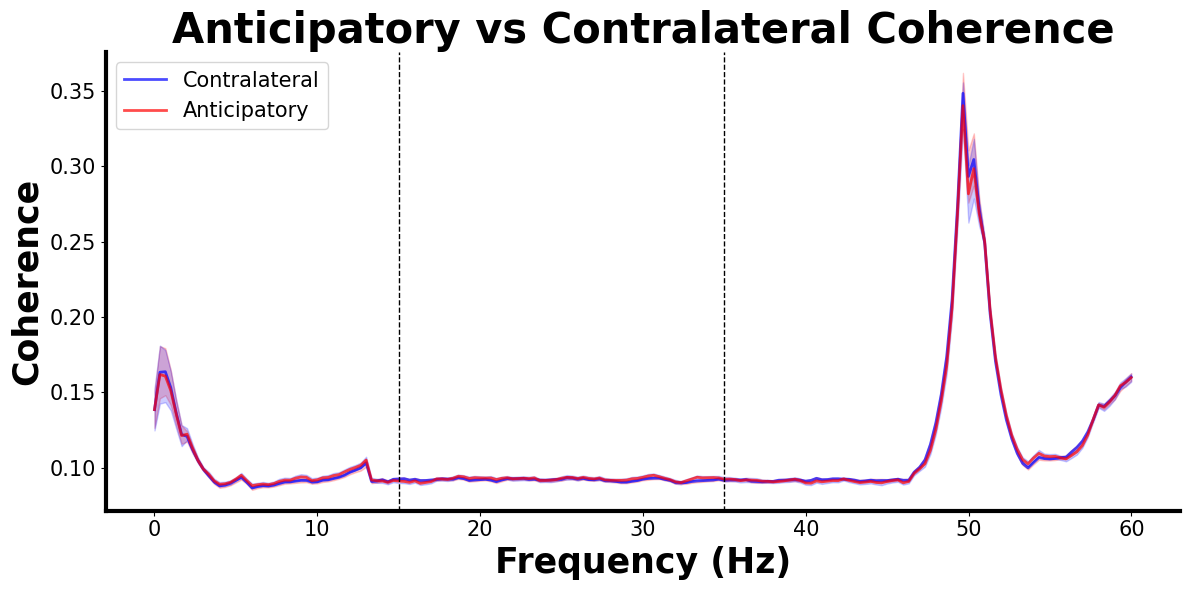

In [334]:
# Create plot for the Anticipatory vs Contra
# Compute means and SEMs for coherence data
contra_mean = All_contra.mean(axis=0)
contra_sem = All_contra.std(axis=0) / np.sqrt(All_contra.shape[0])
ipsi_mean = All_ipsi.mean(axis=0)
ipsi_sem = All_ipsi.std(axis=0) / np.sqrt(All_ipsi.shape[0])
Anticipatory_mean = All_anticipatory.mean(axis=0)
Anticipatory_sem = All_anticipatory.std(axis=0) / np.sqrt(All_anticipatory.shape[0])

plt.figure(figsize=(12, 6))

# Plot patches for standard error
plt.fill_between(Coherence_frequencies, contra_mean - contra_sem, contra_mean + contra_sem,
                 color='red', alpha=0.2)
plt.fill_between(Coherence_frequencies, Anticipatory_mean - Anticipatory_sem, Anticipatory_mean + Anticipatory_sem,
                 color='blue', alpha=0.2)

# Plot mean lines (red for contra, blue for ipsi)
plt.plot(Coherence_frequencies, contra_mean, 'b-', linewidth=2, label='Contralateral', alpha = 0.7)
plt.plot(Coherence_frequencies, Anticipatory_mean, 'r-', linewidth=2, label='Anticipatory', alpha = 0.7)

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend(fontsize=15)
plt.title('Anticipatory vs Contralateral Coherence', fontsize=30, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
# plt.xlim(0, 45)
# plt.ylim(.04, 0.12)
plt.axvline(x=15, color='black', linestyle='--', linewidth=1)
plt.axvline(x=35, color='black', linestyle='--', linewidth=1)
plt.ylabel('Coherence', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Anticipatory_Contra_Mean_Coherence_H2_Step2.jpg')
plt.show()

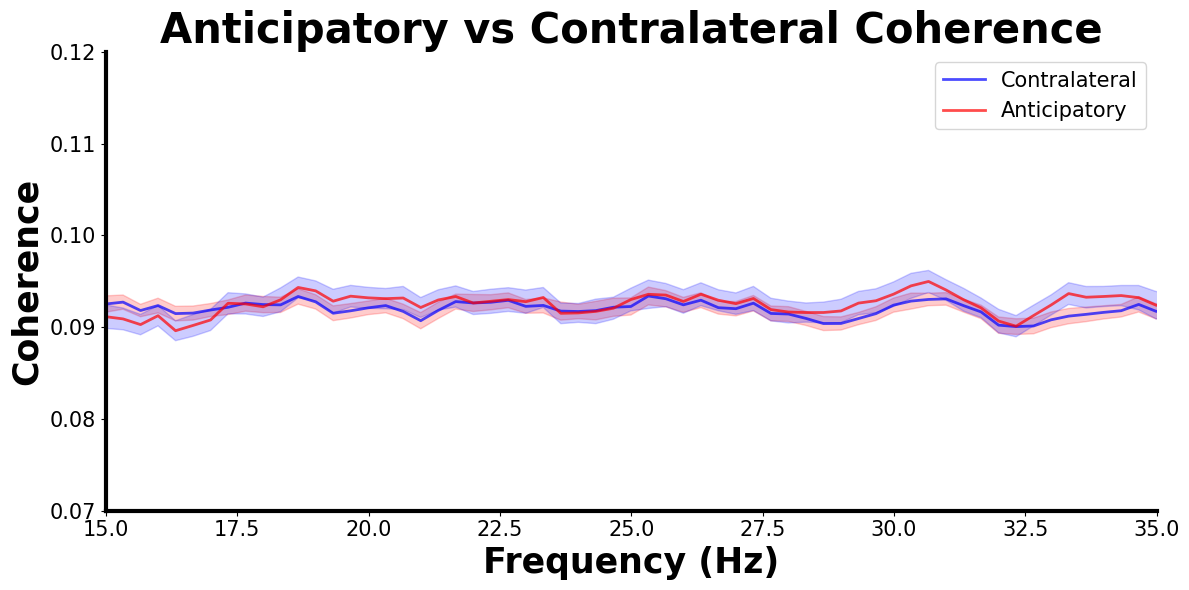

In [335]:
# Create plot for the Anticipatory vs Contra
# Compute means and SEMs for coherence data
contra_mean = All_contra.mean(axis=0)
contra_sem = All_contra.std(axis=0) / np.sqrt(All_contra.shape[0])
ipsi_mean = All_ipsi.mean(axis=0)
ipsi_sem = All_ipsi.std(axis=0) / np.sqrt(All_ipsi.shape[0])
Anticipatory_mean = All_anticipatory.mean(axis=0)
Anticipatory_sem = All_anticipatory.std(axis=0) / np.sqrt(All_anticipatory.shape[0])

plt.figure(figsize=(12, 6))

# Plot patches for standard error
plt.fill_between(Coherence_frequencies, contra_mean - contra_sem, contra_mean + contra_sem,
                 color='red', alpha=0.2)
plt.fill_between(Coherence_frequencies, Anticipatory_mean - Anticipatory_sem, Anticipatory_mean + Anticipatory_sem,
                 color='blue', alpha=0.2)

# Plot mean lines (red for contra, blue for ipsi)
plt.plot(Coherence_frequencies, contra_mean, 'b-', linewidth=2, label='Contralateral', alpha = 0.7)
plt.plot(Coherence_frequencies, Anticipatory_mean, 'r-', linewidth=2, label='Anticipatory', alpha = 0.7)

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend(fontsize=15)
plt.title('Anticipatory vs Contralateral Coherence', fontsize=30, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
plt.xlim(15, 35)
plt.ylim(.07, 0.12)
plt.ylabel('Coherence', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Anticipatory_Contra_Mean_Coherence_H2_Step2_inset.jpg')
plt.show()

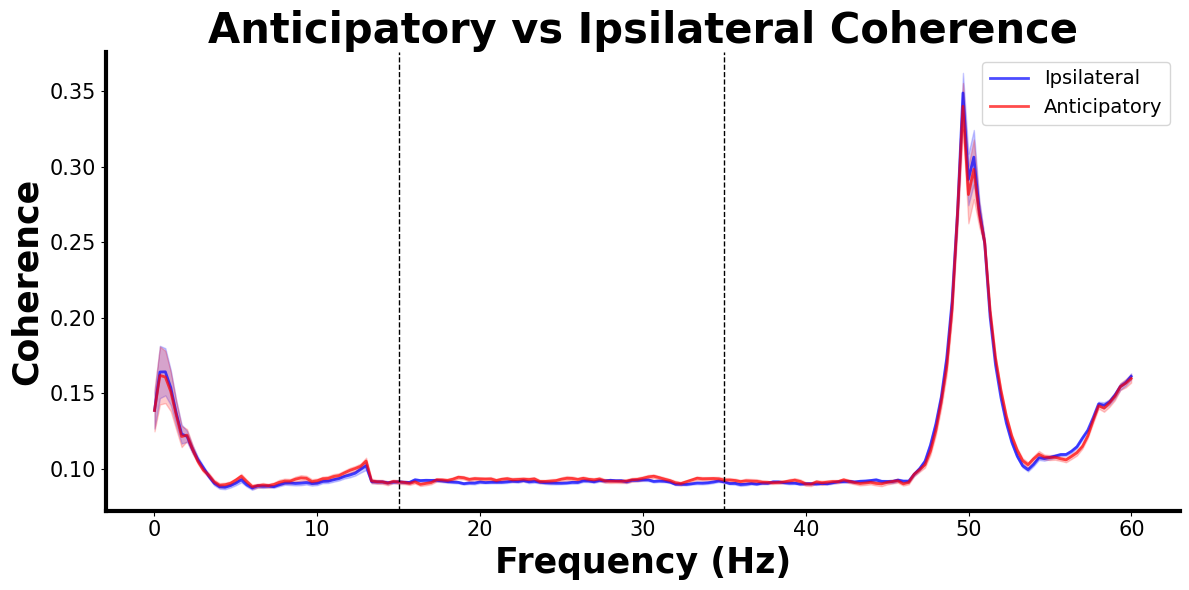

In [336]:
# Create plot for the Anticipatory vs Ipsilateral Coherence

plt.figure(figsize=(12, 6))

# Plot patches for standard error
plt.fill_between(Coherence_frequencies, ipsi_mean - ipsi_sem, ipsi_mean + ipsi_sem,
                 color='blue', alpha=0.2)
plt.fill_between(Coherence_frequencies, Anticipatory_mean - Anticipatory_sem, Anticipatory_mean + Anticipatory_sem,
                 color='red', alpha=0.2)

# Plot mean lines (red for contra, blue for ipsi)
plt.plot(Coherence_frequencies, ipsi_mean, 'b-', linewidth=2, label='Ipsilateral', alpha = 0.7)
plt.plot(Coherence_frequencies, Anticipatory_mean, 'r-', linewidth=2, label='Anticipatory', alpha = 0.7)

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend(fontsize=14)
plt.title('Anticipatory vs Ipsilateral Coherence', fontsize=30, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
plt.ylabel('Coherence', fontsize=25, fontweight='bold')
plt.axvline(x=15, color='black', linestyle='--', linewidth=1)
plt.axvline(x=35, color='black', linestyle='--', linewidth=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Anticipatory_Ipsi_Mean_Coherence_H2_Step2.jpg')
plt.show()

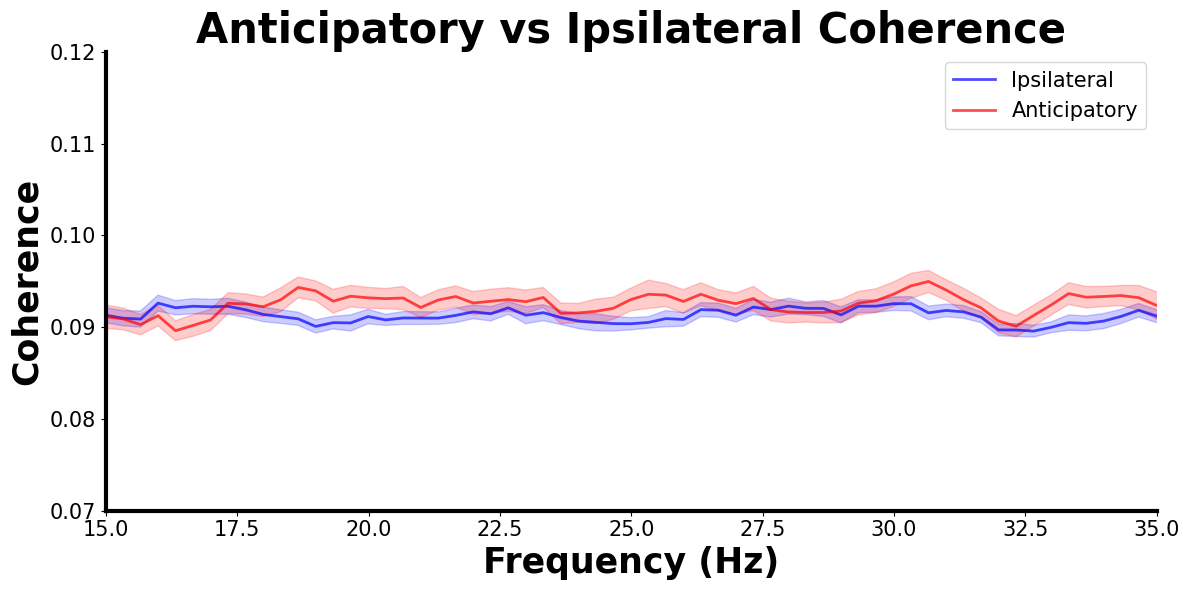

In [337]:
# Create plot for the Anticipatory vs Ipsilateral Coherence

plt.figure(figsize=(12, 6))

# Plot patches for standard error
plt.fill_between(Coherence_frequencies, ipsi_mean - ipsi_sem, ipsi_mean + ipsi_sem,
                 color='blue', alpha=0.2)
plt.fill_between(Coherence_frequencies, Anticipatory_mean - Anticipatory_sem, Anticipatory_mean + Anticipatory_sem,
                 color='red', alpha=0.2)

# Plot mean lines (red for contra, blue for ipsi)
plt.plot(Coherence_frequencies, ipsi_mean, 'b-', linewidth=2, label='Ipsilateral', alpha = 0.7)
plt.plot(Coherence_frequencies, Anticipatory_mean, 'r-', linewidth=2, label='Anticipatory', alpha = 0.7)

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend(fontsize=15)
plt.title('Anticipatory vs Ipsilateral Coherence', fontsize=30, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
plt.xlim(15, 35)
plt.ylim(.07, 0.12)
plt.ylabel('Coherence', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Anticipatory_Ipsi_Mean_Coherence_H2_Step2_inset.jpg')
plt.show()

In [ ]:
# -	We will further compare the coherence spectra computed in step 2, with two other conditions: 1) the coherence of the 
# EMG channels with the contralateral EEG channels on the trials where the stimulation/attention was on the contralateral arm 
# (the arm contralateral to the EMG), and 2) coherence between the EMG channels and the ipsilateral EEG channels for the trials 
# where the stimulation/attention was given to the arm ipsilateral to the EMG. 
# H3_Condition1 - Extraction of the data
# Condition 1: Compute the coherence between the EMG and contralateral EEG channels where stim was on contralateral arm
def Extract_Coherence_Condition1(Subject_EEG, Subject_EMG, tmin, tmax, Left_channels, Right_channels, trials2use):
    fmin = 0
    fmax = 60
    fs = Subject_EEG.info['sfreq']
    bw = 4
    left_EMG_left_stim = Subject_EMG['Left'].crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_left').squeeze()
    right_EMG_right_stim = Subject_EMG['Right'].crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_right').squeeze()
    left_EMG_right_stim = Subject_EMG['Right'].crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_left').squeeze()
    right_EMG_left_stim = Subject_EMG['Left'].crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_right').squeeze()

    # Extract the trials to be used
    Left_leftStim_trials = trials2use['Left'][Subject_EMG.events[:,2] == Subject_EMG.event_id['Left']]
    Left_rightStim_trials = trials2use['Left'][Subject_EMG.events[:,2] == Subject_EMG.event_id['Right']]
    Right_leftStim_trials = trials2use['Right'][Subject_EMG.events[:,2] == Subject_EMG.event_id['Left']]
    Right_rightStim_trials = trials2use['Right'][Subject_EMG.events[:,2] == Subject_EMG.event_id['Right']]

    left_EEG_left_stim = []
    right_EEG_right_stim = []
    left_EEG_right_stim = []
    right_EEG_left_stim = []
    for chan in Left_channels:
        left_EEG_left_stim.append(Subject_EEG['Left'].crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
        left_EEG_right_stim.append(Subject_EEG['Right'].crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
    for chan in Right_channels:
        right_EEG_right_stim.append(Subject_EEG['Right'].crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
        right_EEG_left_stim.append(Subject_EEG['Left'].crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
    left_EEG_left_stim = np.array(left_EEG_left_stim)
    left_EEG_right_stim = np.array(left_EEG_right_stim)
    right_EEG_right_stim = np.array(right_EEG_right_stim)
    right_EEG_left_stim = np.array(right_EEG_left_stim)
    assert Subject_EEG.info['sfreq'] == Subject_EMG.info['sfreq'], "Sampling frequency is not 1000 Hz"

    # Right Arm
    right_contra_right_stim = {} 
    right_contra_left_stim = {}
    for channel in range(left_EEG_right_stim.shape[0]):
        contra_coherence_right_stim = []
        contra_coherence_left_stim = []
        for trial in range(right_EMG_right_stim.shape[0]):
            if Right_rightStim_trials[trial]:
                frequencies, coherence = Compute_coherence_multitaper(right_EMG_right_stim[trial,:], left_EEG_right_stim[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
                contra_coherence_right_stim.append(coherence)
            if Right_leftStim_trials[trial]:
                frequencies, coherence = Compute_coherence_multitaper(right_EMG_left_stim[trial,:], left_EEG_left_stim[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
                contra_coherence_left_stim.append(coherence)
        contra_coherence_right_stim = np.array(contra_coherence_right_stim)
        contra_coherence_left_stim = np.array(contra_coherence_left_stim)
        right_contra_right_stim[Left_channels[channel]] = contra_coherence_right_stim.mean(axis=0)
        right_contra_left_stim[Left_channels[channel]] = contra_coherence_left_stim.mean(axis=0)

    # Left Arm
    left_contra_left_stim = {}
    left_contra_right_stim = {}
    for channel in range(right_EEG_left_stim.shape[0]):
        contra_coherence_left_stim = []
        contra_coherence_right_stim = []
        for trial in range(left_EMG_left_stim.shape[0]):
            if Left_leftStim_trials[trial]:
                frequencies, coherence = Compute_coherence_multitaper(left_EMG_left_stim[trial,:], right_EEG_left_stim[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
                contra_coherence_left_stim.append(coherence)
            if Left_rightStim_trials[trial]:
                frequencies, coherence = Compute_coherence_multitaper(left_EMG_right_stim[trial,:], right_EEG_right_stim[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
                contra_coherence_right_stim.append(coherence)
        contra_coherence_left_stim = np.array(contra_coherence_left_stim)
        contra_coherence_right_stim = np.array(contra_coherence_right_stim)
        left_contra_left_stim[Right_channels[channel]] = contra_coherence_left_stim.mean(axis=0)
        left_contra_right_stim[Right_channels[channel]] = contra_coherence_right_stim.mean(axis=0)

    return right_contra_right_stim, right_contra_left_stim, left_contra_left_stim, left_contra_right_stim, frequencies

tmin = -3.0
tmax = 0.0
All_right_contra_right_stim = []
All_right_contra_left_stim = []
All_left_contra_left_stim = []
All_left_contra_right_stim = []
EEG_filenames, EMG_filenames = Load_EEG_EMG_Paths()
for sub2load in range(len(EEG_filenames)):
    EMG_path = EMG_filenames[sub2load]
    EEG_path = EEG_filenames[sub2load]
    Subject_EEG = mne.read_epochs(EEG_path)
    Subject_EMG = mne.read_epochs(EMG_path)
    # Define channels of interest:
    Left_channels = ['FC1', 'C3', 'CP1']
    Right_channels = ['FC2', 'C4', 'CP2']

    source_path = EMG_path.split('/')[:-1]
    source_path = '/'.join(source_path) + '/'
    path = os.path.join(source_path, 'trials2use.npy')
    trials2use = np.load(path, allow_pickle=True).item()

    assert Check_trial_match(Subject_EEG, Subject_EMG), "The trials order does not match in the EEG and EMG data"

    right_contra_right_stim, right_contra_left_stim, left_contra_left_stim, left_contra_right_stim, frequencies = Extract_Coherence_Condition1(Subject_EEG, Subject_EMG, tmin, tmax, Left_channels, Right_channels, trials2use)

    All_right_contra_right_stim.append(right_contra_right_stim)
    All_right_contra_left_stim.append(right_contra_left_stim)
    All_left_contra_left_stim.append(left_contra_left_stim)
    All_left_contra_right_stim.append(left_contra_right_stim)

# Put it all in a single dictionary and save it
H3_Condition1 = {'Right_contra_right_stim': All_right_contra_right_stim, 'Right_contra_left_stim': All_right_contra_left_stim, 'Left_contra_left_stim': All_left_contra_left_stim, 'Left_contra_right_stim': All_left_contra_right_stim, 'frequencies': frequencies}

# Save the dictionary
with open("Path to save data/H3_Condition1.pkl", "wb") as f:
    pickle.dump(H3_Condition1, f)

Outlier participants for ipsi (Z-score method on mean coherence): [2 5]
Outlier participants for contra (Z-score method on mean coherence): [3]
Final data shape: (27, 181) (27, 181)
Using a threshold of 4.026631
stat_fun(H1): min=8.528969026767518e-07 max=7.136203805796625
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

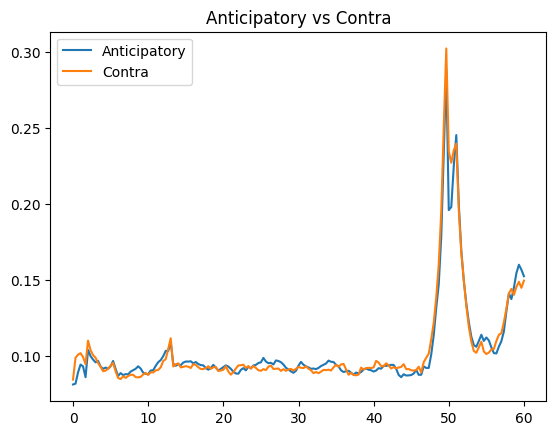

In [359]:
# H3_Condition1 - Analysis of the data
with open("Path to save data/H3_Condition1.pkl", "rb") as f:
    H3_Condition1 = pickle.load(f)
right_contra_right_stim = H3_Condition1['Right_contra_right_stim']
right_contra_left_stim = H3_Condition1['Right_contra_left_stim']
left_contra_left_stim = H3_Condition1['Left_contra_left_stim']
left_contra_right_stim = H3_Condition1['Left_contra_right_stim']
frequencies = H3_Condition1['frequencies']

# For each of the computed metrics, first average the chanels together and then average across the trials
# For the right arm
Left_right_stim = []
Right_left_stim = []
Left_left_stim = []
Right_right_stim = []
Left_Chan_of_interest = ['C3']
Right_Chan_of_interest = ['C4']
for participant in range(len(right_contra_right_stim)):
    temp_left_right_stim = []
    temp_right_left_stim = []
    temp_left_left_stim = []
    temp_right_right_stim = []
    for index in range(len(Left_Chan_of_interest)):
        temp_left_right_stim.append(left_contra_right_stim[participant][Right_Chan_of_interest[index]])
        temp_right_left_stim.append(right_contra_left_stim[participant][Left_Chan_of_interest[index]])
        temp_left_left_stim.append(left_contra_left_stim[participant][Right_Chan_of_interest[index]])
        temp_right_right_stim.append(right_contra_right_stim[participant][Left_Chan_of_interest[index]])
    Left_right_stim.append(np.array(temp_left_right_stim).mean(axis=0))
    Right_left_stim.append(np.array(temp_right_left_stim).mean(axis=0))
    Left_left_stim.append(np.array(temp_left_left_stim).mean(axis=0))
    Right_right_stim.append(np.array(temp_right_right_stim).mean(axis=0))

Arms = 'Left'
if Arms == 'Left':
    Ipsi_stim = np.array(Left_left_stim)
    Contra_stim = np.array(Left_right_stim)
elif Arms == 'Right':
    Ipsi_stim = np.array(Right_right_stim)
    Contra_stim = np.array(Right_left_stim)
elif Arms == 'Both':
    Ipsi_stim = []
    Contra_stim = []
    for participant in range(len(Right_left_stim)):
        Ipsi_stim.append(np.array(Left_left_stim[participant]) + np.array(Right_right_stim[participant]))
        Contra_stim.append(np.array(Left_right_stim[participant]) + np.array(Right_left_stim[participant]))
    Ipsi_stim = np.array(Ipsi_stim)/2
    Contra_stim = np.array(Contra_stim)/2


# Check for outliers in the data
# All anticipatory
participant_means = np.mean(Ipsi_stim, axis=1)
z_scores = zscore(participant_means)
Ipsi_outliers = np.where(np.abs(z_scores) > 2)[0]
print("Outlier participants for ipsi (Z-score method on mean coherence):", Ipsi_outliers)

participant_means = np.mean(Contra_stim, axis=1)
z_scores = zscore(participant_means)
Contra_outliers = np.where(np.abs(z_scores) > 2)[0]
print("Outlier participants for contra (Z-score method on mean coherence):", Contra_outliers)

# Put all the outliers in a single list
Outliers = np.concatenate((Ipsi_outliers, Contra_outliers))
Outliers = np.unique(Outliers)

# remove the outliers from the data
Ipsi_stim = np.delete(Ipsi_stim, Outliers, axis=0)
Contra_stim = np.delete(Contra_stim, Outliers, axis=0)

print('Final data shape:', Ipsi_stim.shape, Contra_stim.shape)

# Limit the data to the beta range
Limit_test = False
if Limit_test:
    minfreq = 15
    maxfreq = 30
    beta_idx = np.where((frequencies >= minfreq) & (frequencies <= maxfreq))[0]
    Ipsi_stim = Ipsi_stim[:, beta_idx]
    Contra_stim = Contra_stim[:, beta_idx]
    frequencies = frequencies[beta_idx]


data = [Ipsi_stim, Contra_stim]

T_obs, clusters, cluster_p_values, _ = permutation_cluster_test(
    data, n_permutations=1000, threshold=None, tail=1
)

plt.plot(frequencies, data[0].mean(axis = 0), label='Anticipatory')
plt.plot(frequencies, data[1].mean(axis = 0), label='Contra')
plt.title('Anticipatory vs Contra')
plt.legend()
plt.show()

for i in range(len(cluster_p_values)):
    if cluster_p_values[i] < 0.05:
        print(f'Cluster {i+1} p-value: {cluster_p_values[i]}')
        print(f'Frequency range: {frequencies[clusters[i][0][0]]} - {frequencies[clusters[i][0][-1]]}')


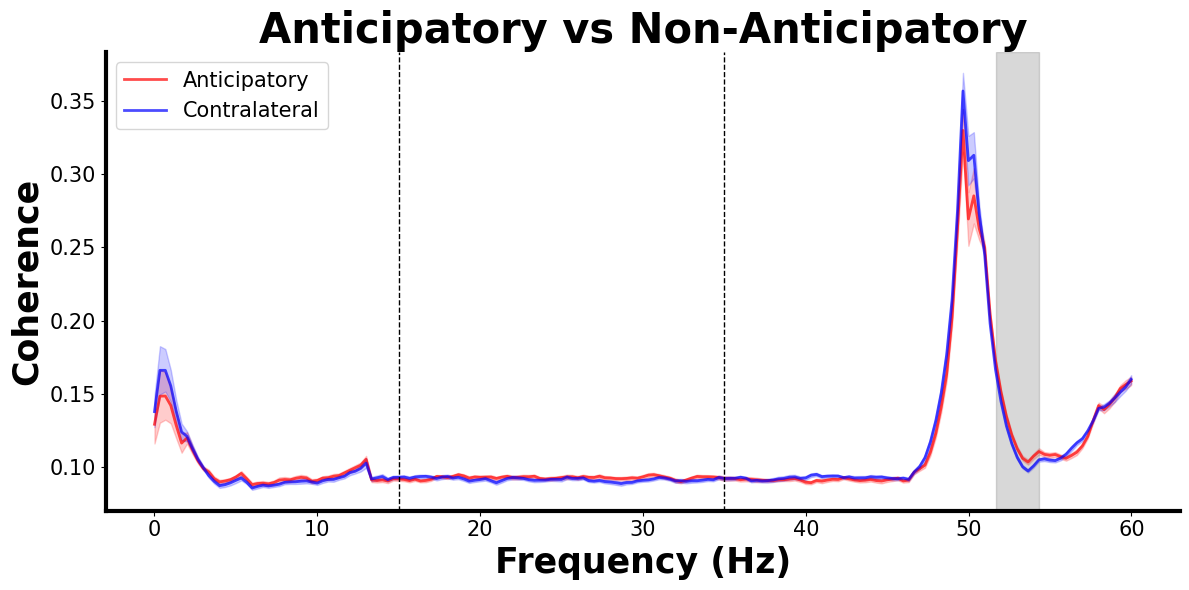

In [339]:
# Create plot for the Anticipatory vs Contra
# Compute means and SEMs for coherence data
contra_mean = Contra_stim.mean(axis=0)
contra_sem = Contra_stim.std(axis=0) / np.sqrt(Contra_stim.shape[0])
Ipsi_mean = Ipsi_stim.mean(axis=0)
Ipsi_sem = Ipsi_stim.std(axis=0) / np.sqrt(Ipsi_stim.shape[0])

plt.figure(figsize=(12, 6))

# Plot patches for standard error
plt.fill_between(Coherence_frequencies, Ipsi_mean - Ipsi_sem, Ipsi_mean + Ipsi_sem,
                 color='red', alpha=0.2)
plt.fill_between(Coherence_frequencies, contra_mean - contra_sem, contra_mean + contra_sem,
                 color='blue', alpha=0.2)
plt.plot(Coherence_frequencies, Ipsi_mean, 'r-', linewidth=2, label='Anticipatory', alpha = 0.7)
plt.plot(Coherence_frequencies, contra_mean, 'b-', linewidth=2, label='Contralateral', alpha = 0.7)

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend(fontsize=15)
plt.title('Anticipatory vs Non-Anticipatory', fontsize=30, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
# plt.xlim(15, 35)
# plt.ylim(.06, 0.12)
plt.axvline(x=15, color='black', linestyle='--', linewidth=1)
plt.axvline(x=35, color='black', linestyle='--', linewidth=1)
plt.ylabel('Coherence', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Anticipatory_vs_Non-Anticipatory_H2_Step3.1.jpg')
plt.show()

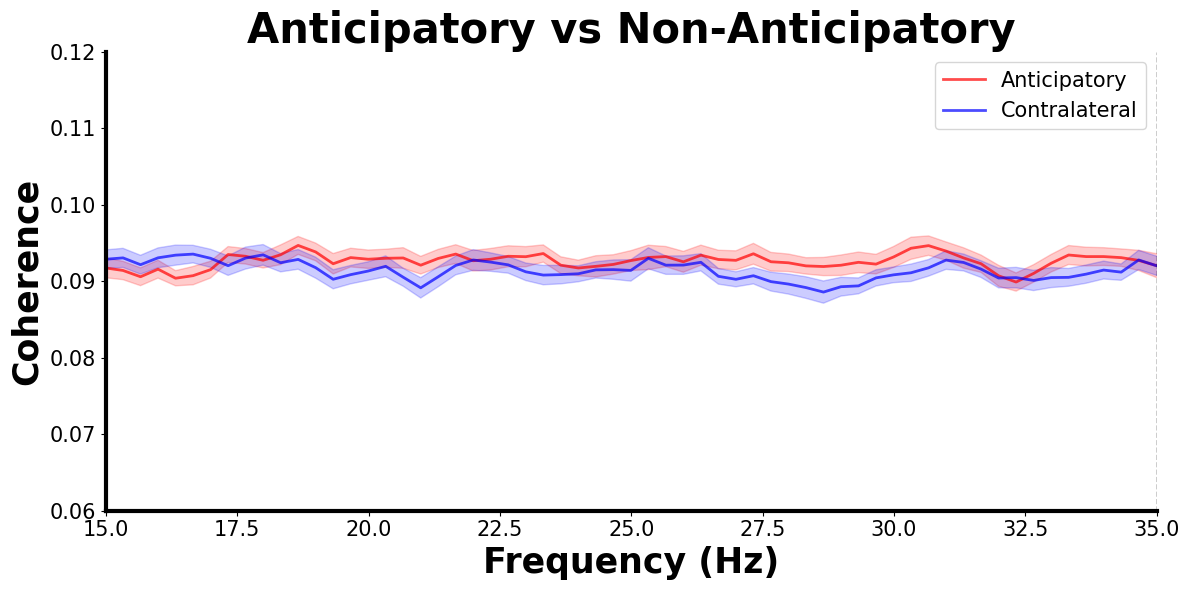

In [340]:
# Create plot for the Anticipatory vs Contra
# Compute means and SEMs for coherence data
contra_mean = Contra_stim.mean(axis=0)
contra_sem = Contra_stim.std(axis=0) / np.sqrt(Contra_stim.shape[0])
Ipsi_mean = Ipsi_stim.mean(axis=0)
Ipsi_sem = Ipsi_stim.std(axis=0) / np.sqrt(Ipsi_stim.shape[0])

plt.figure(figsize=(12, 6))

# Plot patches for standard error
plt.fill_between(Coherence_frequencies, Ipsi_mean - Ipsi_sem, Ipsi_mean + Ipsi_sem,
                 color='red', alpha=0.2)
plt.fill_between(Coherence_frequencies, contra_mean - contra_sem, contra_mean + contra_sem,
                 color='blue', alpha=0.2)
plt.plot(Coherence_frequencies, Ipsi_mean, 'r-', linewidth=2, label='Anticipatory', alpha = 0.7)
plt.plot(Coherence_frequencies, contra_mean, 'b-', linewidth=2, label='Contralateral', alpha = 0.7)

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend(fontsize=15)
plt.title('Anticipatory vs Non-Anticipatory', fontsize=30, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
plt.xlim(15, 35)
plt.ylim(.06, 0.12)
plt.axvline(x=15, color='black', linestyle='--', linewidth=1)
plt.axvline(x=35, color='black', linestyle='--', linewidth=1)
plt.ylabel('Coherence', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Anticipatory_vs_Non-Anticipatory_H2_Step3.1_inset.jpg')
plt.show()

In [ ]:
# H2_Step3.2
# 2) coherence between the EMG channels and the ipsilateral EEG channels for the trials 
# where the stimulation/attention was given to the arm ipsilateral to the EMG. 

def Extract_Coherence_Condition2(Subject_EEG, Subject_EMG, tmin, tmax, Left_channels, Right_channels, trials2use):
    fmin = 0
    fmax = 60
    fs = Subject_EEG.info['sfreq']
    bw = 4
    left_EMG_left_stim = Subject_EMG['Left'].crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_left').squeeze()
    right_EMG_right_stim = Subject_EMG['Right'].crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_right').squeeze()
    left_EMG_right_stim = Subject_EMG['Right'].crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_left').squeeze()
    right_EMG_left_stim = Subject_EMG['Left'].crop(tmin=tmin, tmax=tmax).get_data(picks='EMG_right').squeeze()

    # Extract the trials to be used
    Left_leftStim_trials = trials2use['Left'][Subject_EMG.events[:,2] == Subject_EMG.event_id['Left']]
    Left_rightStim_trials = trials2use['Left'][Subject_EMG.events[:,2] == Subject_EMG.event_id['Right']]
    Right_leftStim_trials = trials2use['Right'][Subject_EMG.events[:,2] == Subject_EMG.event_id['Left']]
    Right_rightStim_trials = trials2use['Right'][Subject_EMG.events[:,2] == Subject_EMG.event_id['Right']]

    left_EEG_left_stim = []
    right_EEG_right_stim = []
    left_EEG_right_stim = []
    right_EEG_left_stim = []
    for chan in Left_channels:
        left_EEG_left_stim.append(Subject_EEG['Left'].crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
        left_EEG_right_stim.append(Subject_EEG['Right'].crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
    for chan in Right_channels:
        right_EEG_right_stim.append(Subject_EEG['Right'].crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
        right_EEG_left_stim.append(Subject_EEG['Left'].crop(tmin=tmin, tmax=tmax).get_data(picks=chan).squeeze())
    left_EEG_left_stim = np.array(left_EEG_left_stim)
    left_EEG_right_stim = np.array(left_EEG_right_stim)
    right_EEG_right_stim = np.array(right_EEG_right_stim)
    right_EEG_left_stim = np.array(right_EEG_left_stim)
    assert Subject_EEG.info['sfreq'] == Subject_EMG.info['sfreq'], "Sampling frequency is not 1000 Hz"

    # Right Arm
    right_ipsi_right_stim = {} 
    right_ipsi_left_stim = {}
    for channel in range(len(Right_channels)):
        ipsi_coherence_right_stim = []
        ipsi_coherence_left_stim = []
        for trial in range(right_EMG_right_stim.shape[0]):
            if Right_rightStim_trials[trial]:
                frequencies, coherence = Compute_coherence_multitaper(right_EMG_right_stim[trial,:], right_EEG_right_stim[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
                ipsi_coherence_right_stim.append(coherence)
            if Right_leftStim_trials[trial]:
                frequencies, coherence = Compute_coherence_multitaper(right_EMG_left_stim[trial,:], right_EEG_left_stim[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
                ipsi_coherence_left_stim.append(coherence)
        ipsi_coherence_right_stim = np.array(ipsi_coherence_right_stim)
        ipsi_coherence_left_stim = np.array(ipsi_coherence_left_stim)
        right_ipsi_right_stim[Right_channels[channel]] = ipsi_coherence_right_stim.mean(axis=0)
        right_ipsi_left_stim[Right_channels[channel]] = ipsi_coherence_left_stim.mean(axis=0)

    # Left Arm
    left_ipsi_left_stim = {}
    left_ipsi_right_stim = {}
    for channel in range(len(Left_channels)):
        ipsi_coherence_left_stim = []
        ipsi_coherence_right_stim = []
        for trial in range(left_EMG_left_stim.shape[0]):
            if Left_leftStim_trials[trial]:
                frequencies, coherence = Compute_coherence_multitaper(left_EMG_left_stim[trial,:], left_EEG_left_stim[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
                ipsi_coherence_left_stim.append(coherence)
            if Left_rightStim_trials[trial]:
                frequencies, coherence = Compute_coherence_multitaper(left_EMG_right_stim[trial,:], left_EEG_right_stim[channel,trial,:], fmin=fmin, fmax=fmax, fs = fs, bw=bw)
                ipsi_coherence_right_stim.append(coherence)
        ipsi_coherence_left_stim = np.array(ipsi_coherence_left_stim)
        ipsi_coherence_right_stim = np.array(ipsi_coherence_right_stim)
        left_ipsi_left_stim[Left_channels[channel]] = ipsi_coherence_left_stim.mean(axis=0)
        left_ipsi_right_stim[Left_channels[channel]] = ipsi_coherence_right_stim.mean(axis=0)

    return right_ipsi_right_stim, right_ipsi_left_stim, left_ipsi_left_stim, left_ipsi_right_stim, frequencies


# Parameters for the coherence calculation
tmin = -3.0
tmax = 0.0
Right_ipsi_right_stim = []
Right_ipsi_left_stim = []
Left_ipsi_left_stim = []
Left_ipsi_right_stim = []
EEG_filenames, EMG_filenames = Load_EEG_EMG_Paths()
for sub2load in range(len(EEG_filenames)):
    EMG_path = EMG_filenames[sub2load]
    EEG_path = EEG_filenames[sub2load]
    Subject_EEG = mne.read_epochs(EEG_path)
    Subject_EMG = mne.read_epochs(EMG_path)
    # Define channels of interest:
    Left_channels = ['FC1', 'C3', 'CP1']
    Right_channels = ['FC2', 'C4', 'CP2']

    source_path = EMG_path.split('/')[:-1]
    source_path = '/'.join(source_path) + '/'
    path = os.path.join(source_path, 'trials2use.npy')
    trials2use = np.load(path, allow_pickle=True).item()

    assert Check_trial_match(Subject_EEG, Subject_EMG), "The trials order does not match in the EEG and EMG data"

    right_ipsi_right_stim, right_ipsi_left_stim, left_ipsi_left_stim, left_ipsi_right_stim, frequencies = Extract_Coherence_Condition2(Subject_EEG, Subject_EMG, tmin, tmax, Left_channels, Right_channels, trials2use)

    Right_ipsi_right_stim.append(right_ipsi_right_stim)
    Right_ipsi_left_stim.append(right_ipsi_left_stim)
    Left_ipsi_left_stim.append(left_ipsi_left_stim)
    Left_ipsi_right_stim.append(left_ipsi_right_stim)

# Save in a single dictionary
H3_Condition2 = {'Right_ipsi_right_stim': Right_ipsi_right_stim, 
                 'Right_ipsi_left_stim' : Right_ipsi_left_stim, 
                 'Left_ipsi_left_stim'  : Left_ipsi_left_stim, 
                 'Left_ipsi_right_stim' : Left_ipsi_right_stim, 
                 'frequencies'          : frequencies}


with open("Path to save data/H3_Condition2.pkl", "wb") as f:
    pickle.dump(H3_Condition2, f)


Outlier participants for ipsi (Z-score method on mean coherence): [3]
Outlier participants for contra (Z-score method on mean coherence): [3]
Outlier participants for All_Anticipatory (Z-score method on mean coherence): [3 5]
Final data shape: (28, 181) (28, 181)
Using a threshold of 4.019541
stat_fun(H1): min=6.632169795103774e-07 max=7.744485863642734
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

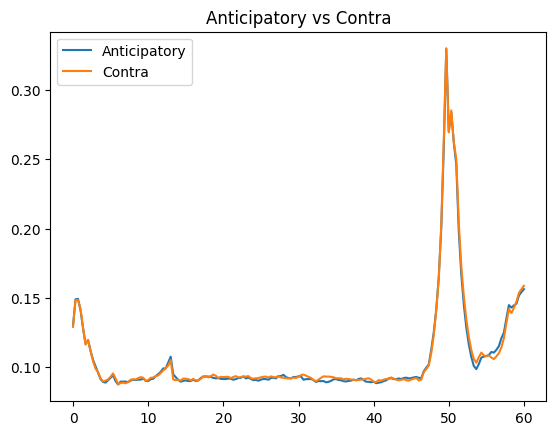

In [341]:

# Extract anticipatory coherence from Step 2
with open("Path to save data/H2_Step2_Anticipatory_Trials_Contra_Coherence.pkl", "rb") as f:
    Anticipatory_coherences = pickle.load(f)

Anticipatory_frequencies = Anticipatory_coherences["Anticipatory_frequencies"]
All_right_anticipatory = Anticipatory_coherences["All_right_anticipatory"]
All_left_anticipatory = Anticipatory_coherences["All_left_anticipatory"]
Left_channels = ['FC1', 'C3', 'CP1']
Right_channels = ['FC2', 'C4', 'CP2']


################### For the Left Arm ################ 
Chan_of_interest = ['FC2', 'C4', 'CP2']
Left_anticipatory = []
for index in range(len(All_left_anticipatory)):
    temp = []
    for chan in Chan_of_interest:
        temp.append(All_left_anticipatory[index][chan])
    temp = np.array(temp)
    Left_anticipatory.append(temp.mean(axis=0))
Left_anticipatory = np.array(Left_anticipatory)


################### For the Right Arm ################ 
Chan_of_interest = ['FC1', 'C3', 'CP1']
Right_anticipatory = []
for index in range(len(All_right_anticipatory)):
    temp = []
    for chan in Chan_of_interest:
        temp.append(All_right_anticipatory[index][chan])
    temp = np.array(temp)
    Right_anticipatory.append(temp.mean(axis=0))
Right_anticipatory = np.array(Right_anticipatory)

###########################################################
############## To combine or not to combine ################ 
###########################################################
Arms = 'Both' # Either Right, Left or Both
if Arms == 'Both':
    All_anticipatory = []
    for index in range(Right_anticipatory.shape[0]):
        temp = np.concatenate((np.expand_dims(Right_anticipatory[index, :], axis=0),
                       np.expand_dims(Left_anticipatory[index, :], axis=0)), axis=0)        
        All_anticipatory.append(np.mean(temp, axis=0))
    All_anticipatory = np.array(All_anticipatory)
elif Arms == 'Right':
    All_anticipatory = Right_anticipatory
elif Arms == 'Left':
    All_anticipatory = Left_anticipatory




# H3_Condition2
with open("Path to save data/H3_Condition2.pkl", "rb") as f:
    H3_Condition2 = pickle.load(f)

# Extract the coherence dictionaries and frequency vector
right_ipsi_right_stim = H3_Condition2['Right_ipsi_right_stim']
right_ipsi_left_stim  = H3_Condition2['Right_ipsi_left_stim']
left_ipsi_left_stim   = H3_Condition2['Left_ipsi_left_stim']
left_ipsi_right_stim  = H3_Condition2['Left_ipsi_right_stim']
frequencies           = H3_Condition2['frequencies']
Right_Chan_of_interest = ['FC2', 'C4', 'CP2']  # for the right arm
Left_Chan_of_interest  = ['FC1', 'C3', 'CP1']   # for the left arm


Right_right_stim_avg = [] 
Right_left_stim_avg  = []
Left_left_stim_avg   = []
Left_right_stim_avg  = []

# Loop over participants
num_participants = len(right_ipsi_right_stim)
for participant in range(num_participants):
    temp_right_right = []
    temp_right_left  = []
    temp_left_left  = []
    temp_left_right = []

    for chan in Right_Chan_of_interest:
        temp_right_right.append( right_ipsi_right_stim[participant][chan] )
        temp_right_left.append(  right_ipsi_left_stim[participant][chan] )
        
    for chan in Left_Chan_of_interest:
        temp_left_left.append( left_ipsi_left_stim[participant][chan] )
        temp_left_right.append( left_ipsi_right_stim[participant][chan] )
    
    Right_right_stim_avg.append( np.array(temp_right_right).mean(axis=0) )
    Right_left_stim_avg.append(  np.array(temp_right_left).mean(axis=0) )
    Left_left_stim_avg.append(  np.array(temp_left_left).mean(axis=0) )
    Left_right_stim_avg.append( np.array(temp_left_right).mean(axis=0) )

Arms = 'Both'  # or 'Left' or 'Right'
if Arms == 'Left':
    Ipsi_stim  = np.array(Left_left_stim_avg)
    Contra_stim = np.array(Left_right_stim_avg)
elif Arms == 'Right':
    Ipsi_stim  = np.array(Right_right_stim_avg)
    Contra_stim = np.array(Right_left_stim_avg)
elif Arms == 'Both':
    Ipsi_stim  = []
    Contra_stim = []
    for participant in range(len(Right_left_stim_avg)):
        Ipsi_stim.append( (np.array(Left_left_stim_avg[participant]) + np.array(Right_right_stim_avg[participant])) / 2 )
        Contra_stim.append( (np.array(Left_right_stim_avg[participant]) + np.array(Right_left_stim_avg[participant])) / 2 )
    Ipsi_stim  = np.array(Ipsi_stim)
    Contra_stim = np.array(Contra_stim)


# Check for outliers in the data
participant_means = np.mean(Ipsi_stim, axis=1)
z_scores = zscore(participant_means)
Ipsi_outliers = np.where(np.abs(z_scores) > 2)[0]
print("Outlier participants for ipsi (Z-score method on mean coherence):", Ipsi_outliers)

participant_means = np.mean(Contra_stim, axis=1)
z_scores = zscore(participant_means)
Contra_outliers = np.where(np.abs(z_scores) > 2)[0]
print("Outlier participants for contra (Z-score method on mean coherence):", Contra_outliers)

# Anticipatory coherence
participant_means = np.mean(All_anticipatory, axis=1)
z_scores = zscore(participant_means)
All_Anticipatory_outliers = np.where(np.abs(z_scores) > 2)[0]
print("Outlier participants for All_Anticipatory (Z-score method on mean coherence):", All_Anticipatory_outliers)

# Put all the outliers in a single list
Outliers = np.concatenate((Ipsi_outliers, All_Anticipatory_outliers))
Outliers = np.unique(Outliers)

Ipsi_stim = np.delete(Ipsi_stim, Outliers, axis=0)
All_anticipatory = np.delete(All_anticipatory, Outliers, axis=0)

print('Final data shape:', Ipsi_stim.shape, All_anticipatory.shape)

# Limit the data to the beta range
Limit_test = False
if Limit_test:
    minfreq = 15
    maxfreq = 30
    beta_idx = np.where((frequencies >= minfreq) & (frequencies <= maxfreq))[0]
    Ipsi_stim = Ipsi_stim[:, beta_idx]
    Contra_stim = Contra_stim[:, beta_idx]
    All_anticipatory = All_anticipatory[:, beta_idx]
    frequencies = frequencies[beta_idx]

data = [Ipsi_stim, All_anticipatory]

T_obs, clusters, cluster_p_values, _ = permutation_cluster_test(
    data, n_permutations=1000, threshold=None, tail=1
)

plt.plot(frequencies, data[0].mean(axis = 0), label='Anticipatory')
plt.plot(frequencies, data[1].mean(axis = 0), label='Contra')
plt.title('Anticipatory vs Contra')
plt.legend()
plt.show()


for i in range(len(cluster_p_values)):
    if cluster_p_values[i] < 0.05:  
        print(f'P values for the clusters: {cluster_p_values[i]}')
        print(f'Frequency range: {frequencies[clusters[i][0][0]]} - {frequencies[clusters[i][0][-1]]}')


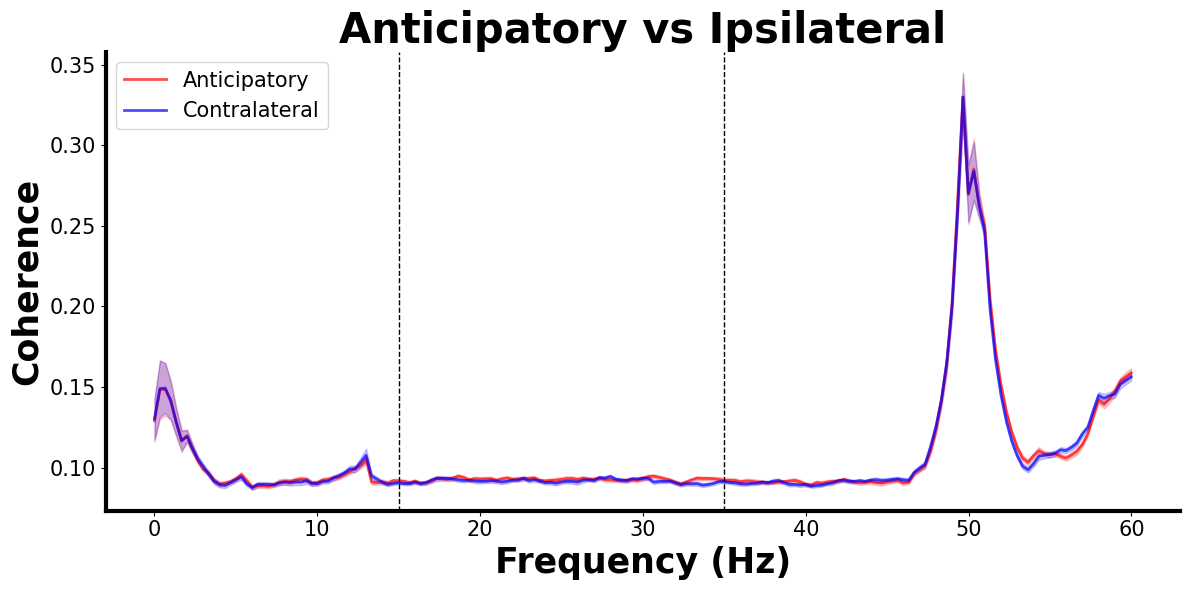

In [342]:
# Create plot for the Anticipatory vs Contra
# Compute means and SEMs for coherence data
ipsi_mean = Ipsi_stim.mean(axis=0)
ipsi_sem = Ipsi_stim.std(axis=0) / np.sqrt(All_contra.shape[0])
Anticipatory_mean = All_anticipatory.mean(axis=0)
Anticipatory_sem = All_anticipatory.std(axis=0) / np.sqrt(All_anticipatory.shape[0])

plt.figure(figsize=(12, 6))
# Plot patches for standard error
plt.fill_between(Coherence_frequencies, Anticipatory_mean - Anticipatory_sem, Anticipatory_mean + Anticipatory_sem,
                 color='red', alpha=0.2)
plt.fill_between(Coherence_frequencies, ipsi_mean - ipsi_sem, ipsi_mean + ipsi_sem,
                 color='blue', alpha=0.2)
plt.plot(Coherence_frequencies, Anticipatory_mean, 'r-', linewidth=2, label='Anticipatory', alpha = 0.7)
plt.plot(Coherence_frequencies, ipsi_mean, 'b-', linewidth=2, label='Contralateral', alpha = 0.7)

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend(fontsize=15)
plt.title('Anticipatory vs Ipsilateral', fontsize=30, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
plt.axvline(x=15, color='black', linestyle='--', linewidth=1)
plt.axvline(x=35, color='black', linestyle='--', linewidth=1)
plt.ylabel('Coherence', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Anticipatory_vs_Ipsilateral_H2_Step3.2.jpg')
plt.show()

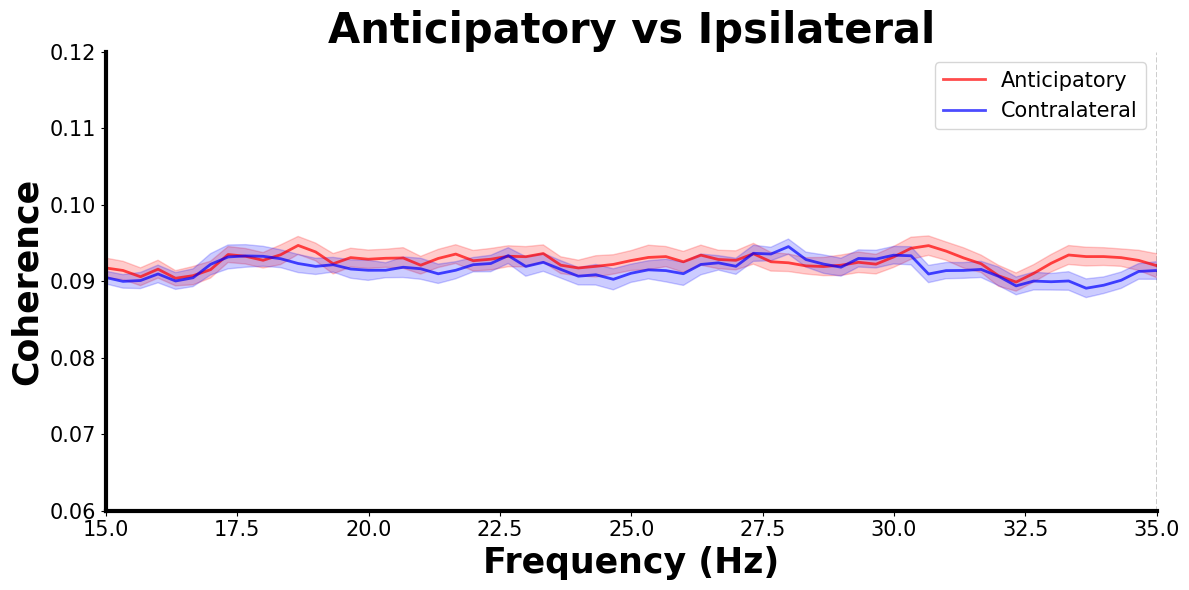

In [343]:
# Create plot for the Anticipatory vs Contra
# Compute means and SEMs for coherence data
ipsi_mean = Ipsi_stim.mean(axis=0)
ipsi_sem = Ipsi_stim.std(axis=0) / np.sqrt(All_contra.shape[0])
Anticipatory_mean = All_anticipatory.mean(axis=0)
Anticipatory_sem = All_anticipatory.std(axis=0) / np.sqrt(All_anticipatory.shape[0])

plt.figure(figsize=(12, 6))
# Plot patches for standard error
plt.fill_between(Coherence_frequencies, Anticipatory_mean - Anticipatory_sem, Anticipatory_mean + Anticipatory_sem,
                 color='red', alpha=0.2)
plt.fill_between(Coherence_frequencies, ipsi_mean - ipsi_sem, ipsi_mean + ipsi_sem,
                 color='blue', alpha=0.2)
plt.plot(Coherence_frequencies, Anticipatory_mean, 'r-', linewidth=2, label='Anticipatory', alpha = 0.7)
plt.plot(Coherence_frequencies, ipsi_mean, 'b-', linewidth=2, label='Contralateral', alpha = 0.7)

# Highlight significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        freq_range = Coherence_frequencies[clusters[i]]
        plt.axvspan(freq_range[0], freq_range[-1], color='gray', alpha=0.3)

plt.legend(fontsize=15)
plt.title('Anticipatory vs Ipsilateral', fontsize=30, fontweight='bold')
plt.xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
plt.xlim(15, 35)
plt.ylim(.06, 0.12)
plt.axvline(x=15, color='black', linestyle='--', linewidth=1)
plt.axvline(x=35, color='black', linestyle='--', linewidth=1)
plt.ylabel('Coherence', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Anticipatory_vs_Ipsilateral_H2_Step3.2_inset.jpg')
plt.show()

In [350]:
# Exploratory analyses:
# -	To explore the concordance between the cortical and muscular beta lateralization at the trial level, we will calculate 
# trial-by-trial correlations between cortical and muscular beta lateralization during the anticipation of the nociceptive stimulus. 
# For this analysis, we will focus on the anticipatory modulations in a pre-stimulus window that will be based on the time window 
# within which there is a significant lateralization effect at the group level in the EEG and EMG data as identified in the primary analysis. 
# Per trial, we will calculate the normalized difference in beta power between the left and right recording sites: for cortical lateralization, 
# we will calculate [(Right - Left)/(Right + Left)] and for muscular lateralization we will calculate [(Left - Right)/(Left + Right)]. 
# We will then sort the trials according to cortical lateralization (separately for left- and right-cued trials) and place them into five consecutive bins. 
# For each bin, we will then calculate both the average cortical and the average muscular lateralization, before averaging the binned data across subjects 
# (van Ede et al., 2013). Finally, we will correlate the binned data for cortical lateralization with that of the muscular lateralization to examine 
# whether higher cortical lateralization co-occurs with higher muscular lateralization.

def Extract_sorted_lateralization(Subject_EEG, Subject_EMG, tmin, tmax, fmin, fmax, Left_channels, Right_channels, trials2use, normalise_baseline = True, outlier_threshold = 3):
    # Extract average power for the left and right EEG channels and average together

    # Normalise to the first second of each epoch
    if normalise_baseline:
        left_data_time = Subject_EMG.get_data()[:, Subject_EMG.ch_names.index('EMG_left'), :]
        right_data_time = Subject_EMG.get_data()[:, Subject_EMG.ch_names.index('EMG_right'), :]

        timebegin = np.argmin(np.abs(Subject_EMG.times - (-4)))
        timeend = np.argmin(np.abs(Subject_EMG.times - (-3)))
        right_mean = right_data_time[:,timebegin:timeend].mean(axis = 1, keepdims=True)
        right_std = right_data_time[:,timebegin:timeend].std(axis = 1, keepdims=True)
        right_data_time = (right_data_time - right_mean)/right_std

        left_mean = left_data_time[:,timebegin:timeend].mean(axis = 1, keepdims=True)
        left_std = left_data_time[:,timebegin:timeend].std(axis = 1, keepdims=True)
        left_data_time = (left_data_time - left_mean)/left_std

        # Compute RMS
        left_rms = np.sqrt(np.mean(left_data_time**2, axis=1))
        right_rms = np.sqrt(np.mean(right_data_time**2, axis=1))

        # Identify outliers using z-score
        z_thresh = outlier_threshold  # Common threshold (adjustable)
        left_mean, left_std = np.mean(left_rms), np.std(left_rms)
        right_mean, right_std = np.mean(right_rms), np.std(right_rms)
        left_outliers = np.where((np.abs(left_rms - left_mean) / left_std) > z_thresh)[0]
        right_outliers = np.where((np.abs(right_rms - right_mean) / right_std) > z_thresh)[0]
        left_trials2use = np.ones(len(left_rms), dtype=bool)
        left_trials2use[left_outliers] = False
        right_trials2use = np.ones(len(right_rms), dtype=bool)
        right_trials2use[right_outliers] = False

        # Put the data back into the epochs
        Subject_EMG._data[:, Subject_EMG.ch_names.index('EMG_left'), :] = left_data_time
        Subject_EMG._data[:, Subject_EMG.ch_names.index('EMG_right'), :] = right_data_time

    Left_EEG_power = Subject_EEG.compute_psd(fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax, picks=Left_channels).get_data().mean(axis=1).mean(axis=1).squeeze()
    Right_EEG_power = Subject_EEG.compute_psd(fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax, picks=Right_channels).get_data().mean(axis=1).mean(axis=1).squeeze()

    # Extract average power for the left and right EMG channels and average together
    Left_EMG_power = Subject_EMG.compute_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, picks='EMG_left').get_data(picks='EMG_left').mean(axis=2).squeeze()
    Right_EMG_power = Subject_EMG.compute_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, picks='EMG_right').get_data(picks='EMG_right').mean(axis=2).squeeze()

    # Calculate the normalized difference in beta power between the left and right recording sites
    Cortical_lateralization = (Right_EEG_power - Left_EEG_power) / (Right_EEG_power + Left_EEG_power)
    Muscular_lateralization = (Left_EMG_power - Right_EMG_power) / (Left_EMG_power + Right_EMG_power)

    # Sort the trials according to cortical lateralization (separately for left- and right-cued trials) and place them into five consecutive bins.
    EEG_events = Subject_EEG.events
    EMG_events = Subject_EMG.events

    EEG_event_id = Subject_EEG.event_id
    EMG_event_id = Subject_EMG.event_id

    if not normalise_baseline:
        left_trials2use = trials2use['Left']
        right_trials2use = trials2use['Right']
    combined_trials2use = np.array([l and r for l, r in zip(left_trials2use, right_trials2use)])

    Cortical_lateralization_left = Cortical_lateralization[EEG_events[:,2] == EEG_event_id['Left']]
    Cortical_lateralization_right = Cortical_lateralization[EEG_events[:,2] == EEG_event_id['Right']]

    Muscular_lateralization_left = Muscular_lateralization[EMG_events[:,2] == EMG_event_id['Left']]
    Muscular_lateralization_right = Muscular_lateralization[EMG_events[:,2] == EMG_event_id['Right']]

    trials2use_left = combined_trials2use[EEG_events[:,2] == EEG_event_id['Left']]
    trials2use_right = combined_trials2use[EEG_events[:,2] == EEG_event_id['Right']]

    # Sort cortical lateralisation and get the sorting indices
    Cortical_lateralization_left_sortind = np.argsort(Cortical_lateralization_left)
    Cortical_lateralization_right_sortind = np.argsort(Cortical_lateralization_right)

    # Sort the cortical and muscular lateralisation
    Cortical_lateralization_left_sorted = Cortical_lateralization_left[Cortical_lateralization_left_sortind]
    Cortical_lateralization_right_sorted = Cortical_lateralization_right[Cortical_lateralization_right_sortind]

    Muscular_lateralization_left_sorted = Muscular_lateralization_left[Cortical_lateralization_left_sortind]
    Muscular_lateralization_right_sorted = Muscular_lateralization_right[Cortical_lateralization_right_sortind]

    trials2use_left_sorted = trials2use_left[Cortical_lateralization_left_sortind]
    trials2use_right_sorted = trials2use_right[Cortical_lateralization_right_sortind]

    # Bin the data into 5 consecutive bins
    bins = 5
    Cortical_lateralization_left_binned = np.array_split(Cortical_lateralization_left_sorted, bins)
    Cortical_lateralization_right_binned = np.array_split(Cortical_lateralization_right_sorted, bins)
    Muscular_lateralization_left_binned = np.array_split(Muscular_lateralization_left_sorted, bins)
    Muscular_lateralization_right_binned = np.array_split(Muscular_lateralization_right_sorted, bins)

    trials2use_left_sorted_binned = np.array_split(trials2use_left_sorted, bins)
    trials2use_right_sorted_binned = np.array_split(trials2use_right_sorted, bins)

    # Average the bins
    Cortical_lateralization_left_mean = np.array([np.mean(bin[trials2use_left_sorted_binned[i]]) for i, bin in enumerate(Cortical_lateralization_left_binned)])
    Cortical_lateralization_right_mean = np.array([np.mean(bin[trials2use_right_sorted_binned[i]]) for i, bin in enumerate(Cortical_lateralization_right_binned)])
    Muscular_lateralization_left_mean = np.array([np.mean(bin[trials2use_left_sorted_binned[i]]) for i, bin in enumerate(Muscular_lateralization_left_binned)])
    Muscular_lateralization_right_mean = np.array([np.mean(bin[trials2use_right_sorted_binned[i]]) for i, bin in enumerate(Muscular_lateralization_right_binned)])

    return Cortical_lateralization_left_mean, Cortical_lateralization_right_mean, Muscular_lateralization_left_mean, Muscular_lateralization_right_mean



EEG_filenames, EMG_filenames, Behavioural_filenames = Load_EEG_EMG_Paths()
tmin = -3.0
tmax = -.7
fmin = 12
fmax = 30
Cortical_lat_left_stim = np.zeros((len(EEG_filenames), 5))
Cortical_lat_right_stim = np.zeros((len(EEG_filenames), 5))
Muscular_lat_left_stim = np.zeros((len(EEG_filenames), 5))
Muscular_lat_right_stim = np.zeros((len(EEG_filenames), 5))

# Load the EEG and EMG data
for sub2load in range(len(EEG_filenames)):

    EMG_path = EMG_filenames[sub2load]
    EEG_path = EEG_filenames[sub2load]
    Subject_EEG = mne.read_epochs(EEG_path)
    Subject_EMG = mne.read_epochs(EMG_path)

    # Define channels of interest:
    Left_channels = ['C3']
    Right_channels = ['C4']

    source_path = EMG_path.split('/')[:-1]
    source_path = '/'.join(source_path) + '/'
    path = os.path.join(source_path, 'trials2use.npy')
    trials2use = np.load(path, allow_pickle=True).item()

    assert Check_trial_match(Subject_EEG, Subject_EMG), "The trials order does not match in the EEG and EMG data"

    # Define channels of interest:
    # Left_channels = ['FC1', 'C3', 'CP1']
    # Right_channels = ['FC2', 'C4', 'CP2']

    (Cortical_lateralization_left_mean,
    Cortical_lateralization_right_mean,
    Muscular_lateralization_left_mean,
    Muscular_lateralization_right_mean) = Extract_sorted_lateralization(
        Subject_EEG, Subject_EMG, tmin, tmax, fmin, fmax, Left_channels, Right_channels, trials2use
    )
    Cortical_lat_left_stim[sub2load, :] = Cortical_lateralization_left_mean
    Cortical_lat_right_stim[sub2load, :] = Cortical_lateralization_right_mean
    Muscular_lat_left_stim[sub2load, :] = Muscular_lateralization_left_mean
    Muscular_lat_right_stim[sub2load, :] = Muscular_lateralization_right_mean
    



Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_1_/BBO_1__for_BBO-epo.fif ...
    Found the data of interest:
        t =   -4000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/KetanData2/BBO/EMG/Processed/BBO1/BBO1_EMG-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -4000.00 ...       0.00 ms
        0 CTF compensation matrices available
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Volumes/KetanData2/BBO/EEG/Processed/BBO_2_/BBO_2__for_BBO-epo.fif ...
    Found the data of interest:
        t =   -4000.00

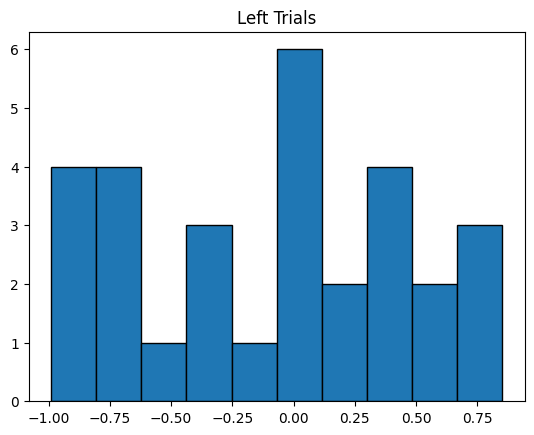

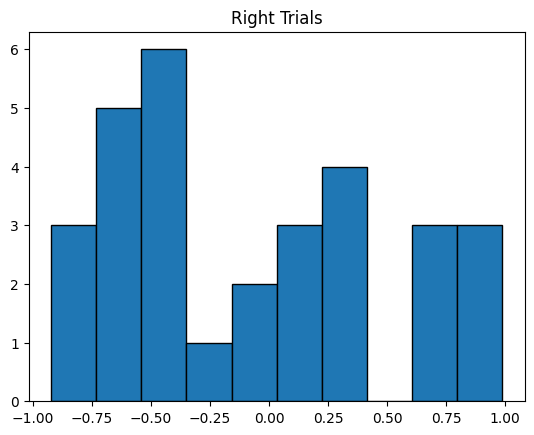

Left Mean: -0.08053384310044061, Right Mean: -0.09847018812206747
Left SEM: 0.10148675277271813, Right SEM: 0.10334870364211154
t-statistic: -0.78020, p-value: 0.2208, N = 30
t-statistic: -0.93678, p-value: 0.1783, N = 30
Correlation between cortical and muscular lateralisation for left stimulation: 0.01618, p-value: 0.9794
Correlation between cortical and muscular lateralisation for right stimulation: 0.27988, p-value: 0.6484


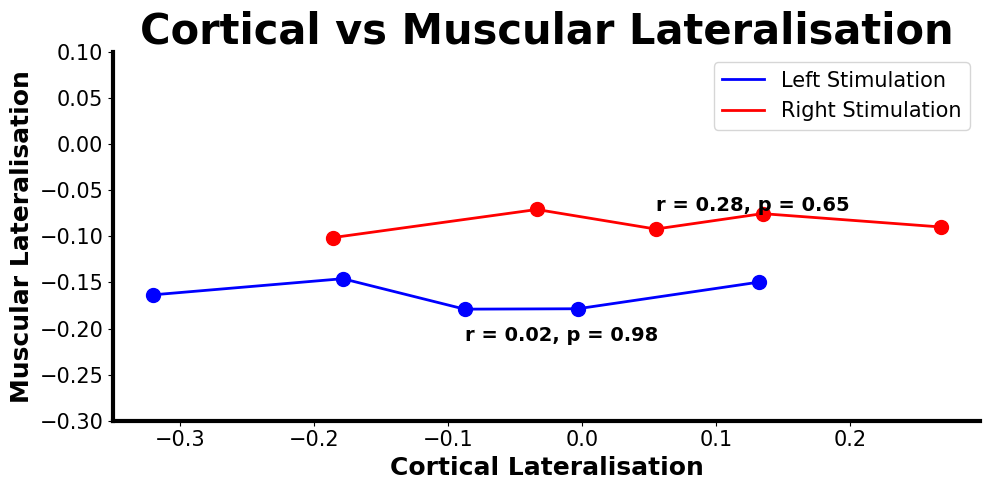

In [352]:
# Plot the cortical lateralisation by muscular lateralisation for the trial level correlations
from scipy.stats import pearsonr
from scipy.stats import ttest_1samp


Left_Rs = []
Left_Ps = []
Right_Rs = []
Right_Ps = []

for i in range(Cortical_lat_left_stim.shape[0]):
    Left_r, Left_p = pearsonr(Cortical_lat_left_stim[i,:], Muscular_lat_left_stim[i,:])
    Left_Rs.append(Left_r)
    Left_Ps.append(Left_p)
    Right_r, Right_p = pearsonr(Cortical_lat_right_stim[i,:], Muscular_lat_right_stim[i,:])
    Right_Rs.append(Right_r)
    Right_Ps.append(Right_p)

Left_Rs = np.array(Left_Rs)
Left_Ps = np.array(Left_Ps)
Right_Rs = np.array(Right_Rs)
Right_Ps = np.array(Right_Ps)

plt.hist(Left_Rs, bins = 10, edgecolor = 'black')
plt.title('Left Trials')
plt.show()

plt.hist(Right_Rs, bins = 10, edgecolor = 'black')
plt.title('Right Trials')
plt.show()

print(f"Left Mean: {np.mean(Left_Rs)}, Right Mean: {np.mean(Right_Rs)}")
print(f"Left SEM: {np.std(Left_Rs)/np.sqrt(len(Left_Rs))}, Right SEM: {np.std(Right_Rs)/np.sqrt(len(Right_Rs))}")

t_stat, p_value = ttest_1samp(Left_Rs, 0, alternative = 'less')
print(f"t-statistic: {t_stat:.5f}, p-value: {p_value:.4f}, N = {len(Left_Rs)}")

t_stat, p_value = ttest_1samp(Right_Rs, 0, alternative = 'less')
print(f"t-statistic: {t_stat:.5f}, p-value: {p_value:.4f}, N = {len(Right_Rs)}")

Cortical_lat_left_mean = np.mean(Cortical_lat_left_stim, axis=0)
Cortical_lat_right_mean = np.mean(Cortical_lat_right_stim, axis=0)
Muscular_lat_left_mean = np.mean(Muscular_lat_left_stim, axis=0)
Muscular_lat_right_mean = np.mean(Muscular_lat_right_stim, axis=0)

# Correlations between cortical and muscular lateralisation
Left_r, Left_p = pearsonr(Cortical_lat_left_mean, Muscular_lat_left_mean)
print(f"Correlation between cortical and muscular lateralisation for left stimulation: {Left_r:.5f}, p-value: {Left_p:.4f}")

Right_r, Right_p = pearsonr(Cortical_lat_right_mean, Muscular_lat_right_mean)
print(f"Correlation between cortical and muscular lateralisation for right stimulation: {Right_r:.5f}, p-value: {Right_p:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(Cortical_lat_left_mean, Muscular_lat_left_mean, 'b-', label='Left Stimulation', linewidth = 2)
plt.plot(Cortical_lat_right_mean, Muscular_lat_right_mean, 'r-', label='Right Stimulation', linewidth = 2)
plt.plot(Cortical_lat_left_mean, Muscular_lat_left_mean, 'bo', markersize = 10)
plt.plot(Cortical_lat_right_mean, Muscular_lat_right_mean, 'ro', markersize = 10)
plt.xlabel('Cortical Lateralisation', size = 18, fontweight = 'bold')
plt.ylabel('Muscular Lateralisation', size = 18, fontweight = 'bold')
plt.title('Cortical vs Muscular Lateralisation', size = 30, fontweight = 'bold')
# Add the correlation coefficients to the plot
plt.text(Cortical_lat_left_mean[2], Muscular_lat_left_mean[2]-.035, f'r = {Left_r:.2f}, p = {Left_p:.2f}', fontsize = 14, fontweight = 'bold')
plt.text(Cortical_lat_right_mean[2], Muscular_lat_right_mean[2]+.02, f'r = {Right_r:.2f}, p = {Right_p:.2f}', fontsize = 14, fontweight = 'bold')
plt.ylim(-.3, .1)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Lat_Correlations.jpg', dpi = 600) 
plt.show()


In [ ]:
# Now check the same trial level correlations for all frequencies
EEG_filenames, EMG_filenames, Behavioural_filenames = Load_EEG_EMG_Paths()
tmin = -3.0
tmax = 0.0
fmins = np.arange(1, 50, 1)
fmaxs = np.arange(2, 51, 1)

All_Cortical_lat_left_mean = []
All_Cortical_lat_right_mean = []
All_Muscular_lat_left_mean = []
All_Muscular_lat_right_mean = []

Cortical_lat_left_stim = np.zeros((len(EEG_filenames), len(fmins), 5))
Cortical_lat_right_stim = np.zeros((len(EEG_filenames), len(fmins), 5))
Muscular_lat_left_stim = np.zeros((len(EEG_filenames), len(fmins), 5))
Muscular_lat_right_stim = np.zeros((len(EEG_filenames), len(fmins), 5))


# Load the EEG and EMG data
for sub2load in range(len(EEG_filenames)):


    EMG_path = EMG_filenames[sub2load]
    EEG_path = EEG_filenames[sub2load]
    Subject_EEG = mne.read_epochs(EEG_path)
    Subject_EMG = mne.read_epochs(EMG_path)

    # Define channels of interest:
    Left_channels = ['FC1', 'C3', 'CP1']
    Right_channels = ['FC2', 'C4', 'CP2']

    source_path = EMG_path.split('/')[:-1]
    source_path = '/'.join(source_path) + '/'
    path = os.path.join(source_path, 'trials2use.npy')
    trials2use = np.load(path, allow_pickle=True).item()

    assert Check_trial_match(Subject_EEG, Subject_EMG), "The trials order does not match in the EEG and EMG data"

    # Define channels of interest:
    Left_channels = ['FC1', 'C3', 'CP1']
    Right_channels = ['FC2', 'C4', 'CP2']

    index = 0
    for fmin, fmax in zip(fmins, fmaxs):

        Cortical_lateralization_left_mean, Cortical_lateralization_right_mean, Muscular_lateralization_left_mean, Muscular_lateralization_right_mean = Extract_sorted_lateralization(Subject_EEG, Subject_EMG, tmin, tmax, fmin, fmax, Left_channels, Right_channels, trials2use)
        Cortical_lat_left_stim[sub2load, index, :] = Cortical_lateralization_left_mean
        Cortical_lat_right_stim[sub2load, index, :] = Cortical_lateralization_right_mean
        Muscular_lat_left_stim[sub2load, index, :] = Muscular_lateralization_left_mean
        Muscular_lat_right_stim[sub2load, index, :] = Muscular_lateralization_right_mean

        index += 1


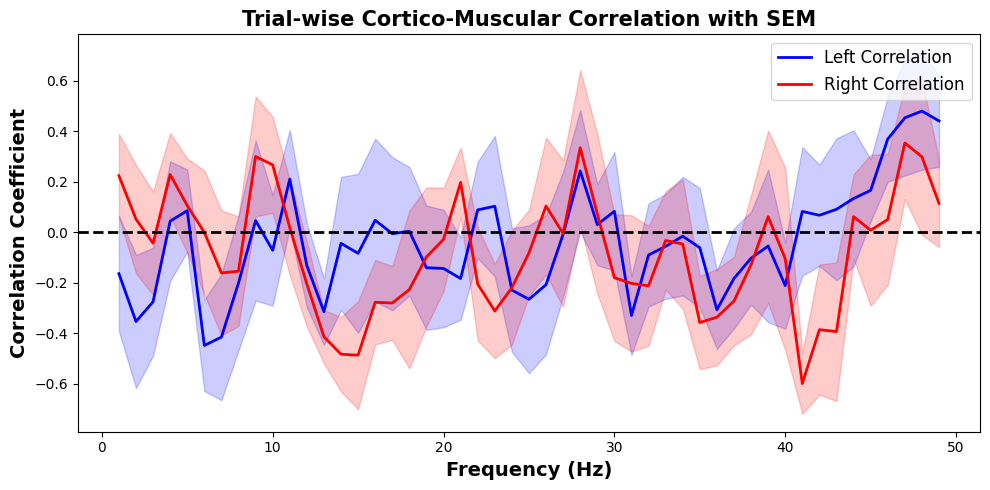

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, sem

# Compute mean (this is still useful if you want to compare to the group-level average later)
Cortical_lat_left_mean = np.mean(Cortical_lat_left_stim, axis=0)   # shape: [frequencies x subjects]
Cortical_lat_right_mean = np.mean(Cortical_lat_right_stim, axis=0)
Muscular_lat_left_mean = np.mean(Muscular_lat_left_stim, axis=0)
Muscular_lat_right_mean = np.mean(Muscular_lat_right_stim, axis=0)

n_freqs = len(fmins)
n_subjects = Cortical_lat_left_stim.shape[2]

# Store subject-level r-values
left_r_all = np.zeros((n_freqs, n_subjects))
right_r_all = np.zeros((n_freqs, n_subjects))

for i in range(n_freqs):
    for subj in range(n_subjects):
        # Extract per-subject lateralization values at frequency i
        cort_left = Cortical_lat_left_stim[subj,i, :]
        musc_left = Muscular_lat_left_stim[subj, i, :]
        cort_right = Cortical_lat_right_stim[subj, i, :]
        musc_right = Muscular_lat_right_stim[subj, i, :]
        
        # Correlations for each subject at frequency i
        left_r_all[i, subj], _ = pearsonr(cort_left, musc_left)
        right_r_all[i, subj], _ = pearsonr(cort_right, musc_right)

# Mean and SEM
left_r_mean = np.mean(left_r_all, axis=1)
left_r_sem = sem(left_r_all, axis=1)
right_r_mean = np.mean(right_r_all, axis=1)
right_r_sem = sem(right_r_all, axis=1)

# Plot with SEM patches
plt.figure(figsize=(10, 5))

# SEM shaded regions
plt.fill_between(fmins, left_r_mean - left_r_sem, left_r_mean + left_r_sem, color='blue', alpha=0.2)
plt.fill_between(fmins, right_r_mean - right_r_sem, right_r_mean + right_r_sem, color='red', alpha=0.2)

# Mean correlation lines
plt.plot(fmins, left_r_mean, 'b-', label='Left Correlation', linewidth=2)
plt.plot(fmins, right_r_mean, 'r-', label='Right Correlation', linewidth=2)
plt.axhline(0, color='black', linewidth=2, linestyle='--')
plt.xlabel('Frequency (Hz)', fontsize=14, fontweight='bold')
plt.ylabel('Correlation Coefficient', fontsize=14, fontweight='bold')
plt.title('Trial-wise Cortico-Muscular Correlation with SEM', fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('Path to save figure/Cortico_Muscular_Correlation_By_Frequency.jpg', dpi = 600)
plt.show()

In [ ]:

def Extract_Normalised_Beta_power(Subject_EEG, Subject_EMG, tmin, tmax, fmin, fmax, Left_channels, Right_channels, trials2use, normalise_baseline = True, outlier_threshold = 2):

    # Normalise to the first second of each epoch
    if normalise_baseline:
        left_data_time = Subject_EMG.get_data()[:, Subject_EMG.ch_names.index('EMG_left'), :]
        right_data_time = Subject_EMG.get_data()[:, Subject_EMG.ch_names.index('EMG_right'), :]

        timebegin = np.argmin(np.abs(Subject_EMG.times - (-4)))
        timeend = np.argmin(np.abs(Subject_EMG.times - (-3)))
        right_mean = right_data_time[:,timebegin:timeend].mean(axis = 1, keepdims=True)
        right_std = right_data_time[:,timebegin:timeend].std(axis = 1, keepdims=True)
        right_data_time = (right_data_time - right_mean)/right_std

        left_mean = left_data_time[:,timebegin:timeend].mean(axis = 1, keepdims=True)
        left_std = left_data_time[:,timebegin:timeend].std(axis = 1, keepdims=True)
        left_data_time = (left_data_time - left_mean)/left_std

        # Compute RMS
        left_rms = np.sqrt(np.mean(left_data_time**2, axis=1))
        right_rms = np.sqrt(np.mean(right_data_time**2, axis=1))

        # Identify outliers using z-score
        z_thresh = outlier_threshold  # Common threshold (adjustable)
        left_mean, left_std = np.mean(left_rms), np.std(left_rms)
        right_mean, right_std = np.mean(right_rms), np.std(right_rms)
        left_outliers = np.where((np.abs(left_rms - left_mean) / left_std) > z_thresh)[0]
        right_outliers = np.where((np.abs(right_rms - right_mean) / right_std) > z_thresh)[0]
        left_trials2use = np.ones(len(left_rms), dtype=bool)
        left_trials2use[left_outliers] = False
        right_trials2use = np.ones(len(right_rms), dtype=bool)
        right_trials2use[right_outliers] = False

        # # Put the data back into the epochs
        # Subject_EMG._data[:, Subject_EMG.ch_names.index('EMG_left'), :] = left_data_time
        # Subject_EMG._data[:, Subject_EMG.ch_names.index('EMG_right'), :] = right_data_time

    Left_EEG_power = Subject_EEG.compute_psd(fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax, picks=Left_channels).get_data().mean(axis=1).mean(axis=1).squeeze()
    Right_EEG_power = Subject_EEG.compute_psd(fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax, picks=Right_channels).get_data().mean(axis=1).mean(axis=1).squeeze()

    Left_EEG_power_baseline = Subject_EEG.compute_psd(fmin=fmin, fmax=fmax, tmin=-4, tmax=-3, picks=Left_channels).get_data().mean(axis=1).mean(axis=1).squeeze()
    Right_EEG_power_baseline = Subject_EEG.compute_psd(fmin=fmin, fmax=fmax, tmin=-4, tmax=-3, picks=Right_channels).get_data().mean(axis=1).mean(axis=1).squeeze()

    Left_EEG_power = ((Left_EEG_power - Left_EEG_power_baseline)/Left_EEG_power_baseline) * 100
    Right_EEG_power = ((Right_EEG_power - Right_EEG_power_baseline)/Right_EEG_power_baseline) * 100


    # Extract average power for the left and right EMG channels and average together
    Left_EMG_power = Subject_EMG.compute_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, picks='EMG_left').get_data(picks='EMG_left').mean(axis=2).squeeze()
    Right_EMG_power = Subject_EMG.compute_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, picks='EMG_right').get_data(picks='EMG_right').mean(axis=2).squeeze()

    Left_EMG_power_baseline = Subject_EMG.compute_psd(tmin=-4, tmax=-3, fmin=fmin, fmax=fmax, picks='EMG_left').get_data(picks='EMG_left').mean(axis=2).squeeze()
    Right_EMG_power_baseline = Subject_EMG.compute_psd(tmin=-4, tmax=-3, fmin=fmin, fmax=fmax, picks='EMG_right').get_data(picks='EMG_right').mean(axis=2).squeeze()

    # Calculate the Z-normalised power now as a percentage change from the baseline
    Left_EMG_power = ((Left_EMG_power - Left_EMG_power_baseline)/Left_EMG_power_baseline) * 100
    Right_EMG_power = ((Right_EMG_power - Right_EMG_power_baseline)/Right_EMG_power_baseline) * 100


    return  (Left_EMG_power, Right_EMG_power), (Left_EEG_power, Right_EEG_power)

EEG_filenames, EMG_filenames, Behavioural_filenames = Load_EEG_EMG_Paths()
tmin = -3.0
tmax = 0.0
fmin = 10
fmax = 30
All_EMG_power = {}
All_EEG_power = {}
# Load the EEG and EMG data

for sub2load in range(len(EEG_filenames)):

    EMG_path = EMG_filenames[sub2load]
    EEG_path = EEG_filenames[sub2load]
    Subject_EEG = mne.read_epochs(EEG_path)
    Subject_EMG = mne.read_epochs(EMG_path)

    # Define channels of interest:
    Left_channels = ['FC1', 'C3', 'CP1']
    Right_channels = ['FC2', 'C4', 'CP2']

    source_path = EMG_path.split('/')[:-1]
    source_path = '/'.join(source_path) + '/'
    path = os.path.join(source_path, 'trials2use.npy')
    trials2use = np.load(path, allow_pickle=True).item()

    assert Check_trial_match(Subject_EEG, Subject_EMG), "The trials order does not match in the EEG and EMG data"

    # Define channels of interest:
    Left_channels = ['FC1', 'C3', 'CP1']
    Right_channels = ['FC2', 'C4', 'CP2']

    EMG_power, EEG_power = Extract_Normalised_Beta_power(Subject_EEG, Subject_EMG, tmin, tmax, fmin, fmax, Left_channels, Right_channels, trials2use)

    All_EMG_power[sub2load] = EMG_power
    All_EEG_power[sub2load] = EEG_power


In [ ]:
# Use the trial level data to explore trial level correlations between EEG and EMG
# {'Left': 10002, 'Invalid': 10003, 'Right': 10004}
from scipy.stats import pearsonr

# Lists to store correlation coefficients and p-values
Left_correlations = []
Left_p_values = []
Right_correlations = []
Right_p_values = []
EEG_filenames, EMG_filenames, Behavioural_filenames = Load_EEG_EMG_Paths()
for sub2load in range(len(EEG_filenames)):
    EEG_data = mne.read_epochs(EEG_filenames[sub2load])
    events = EEG_data.events
    
    Left_EMG_power, Right_EMG_power = All_EMG_power[sub2load]
    Left_EEG_power, Right_EEG_power = All_EEG_power[sub2load]

    source_path = EMG_filenames[sub2load].split('/')[:-1]
    source_path = '/'.join(source_path) + '/'
    path = os.path.join(source_path, 'trials2use.npy')
    trials2use = np.load(path, allow_pickle=True).item()
    Left_trials2use = trials2use['Left']
    Right_trials2use = trials2use['Right']

    # Correlations at the trial level
    r, p = pearsonr(Left_EEG_power[Right_trials2use], Right_EMG_power[Right_trials2use])
    Right_correlations.append(r)
    Right_p_values.append(p)

    r, p = pearsonr(Right_EEG_power[Left_trials2use], Left_EMG_power[Left_trials2use])
    Left_correlations.append(r)
    Left_p_values.append(p)

plt.plot(Left_correlations, 'b-', label = 'Left Correlation')
plt.plot(Right_correlations, 'r-', label = 'Right Correlation')
plt.legend()
plt.show()
    

1.127440898474667 397.9574400536861 48.71926291543702


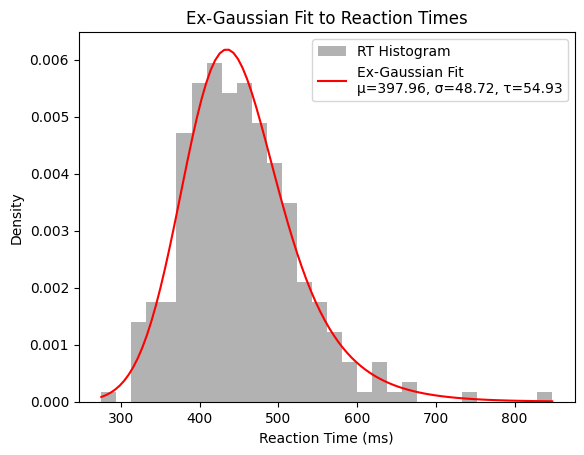

Fitted parameters:
μ = 397.96 ms
σ = 48.72 ms
τ = 54.93 ms


In [ ]:
# ExGaussian fitting Exploration
from scipy.stats import exponnorm

# Generate example reaction time data (simulated)
np.random.seed(42)
rt_data = np.random.normal(400, 50, 300) + np.random.exponential(50, 300)  # Simulated RTs

# Fit the ex-Gaussian using scipy's exponnorm
k, loc, scale = exponnorm.fit(rt_data)  # k = shape parameter (related to τ)

# Convert parameters to conventional ex-Gaussian form:
mu = loc
sigma = scale
tau = scale * k

# Generate fitted distribution for plotting
x_vals = np.linspace(min(rt_data), max(rt_data), 100)
y_vals = exponnorm.pdf(x_vals, k, loc, scale)

# Plot results
plt.hist(rt_data, bins=30, density=True, alpha=0.6, color='gray', label='RT Histogram')
plt.plot(x_vals, y_vals, 'r-', label=f'Ex-Gaussian Fit\nμ={mu:.2f}, σ={sigma:.2f}, τ={tau:.2f}')
plt.xlabel('Reaction Time (ms)')
plt.ylabel('Density')
plt.legend()
plt.title('Ex-Gaussian Fit to Reaction Times')
plt.show()

# Print fitted parameters
print(f"Fitted parameters:\nμ = {mu:.2f} ms\nσ = {sigma:.2f} ms\nτ = {tau:.2f} ms")


In [ ]:
# Possible measures to extract from the behavioural data:
#   1.	Mean RT – The average reaction time across all trials for each participant.
# 	2.	Median RT – More robust against outliers compared to the mean.
# 	3.	RT Variability – Standard deviation (SD) of reaction times, which could indicate inconsistency in response execution.
# 	4.	Coefficient of Variation (CV-RT) – Standard deviation divided by the mean RT. High CV-RT suggests more variable response patterns.
# 	5.	RT Variance – Variance of reaction times, which provides a measure of the spread of RTs.

# Function to clean reaction times (removing outliers)
def clean_rt(rts, threshold=3):
    """Removes reaction time (RT) outliers beyond ±threshold SD."""
    mean_rt = np.mean(rts)
    std_rt = np.std(rts)
    z_scores = (rts - mean_rt) / std_rt
    return rts[np.abs(z_scores) < threshold]

# Function to compute reaction time metrics
def compute_rt_metrics(rts):
    """Computes mean, median, variance, and skewness of RTs."""
    return {
        "Mean RT": np.nanmean(rts),
        "Median RT": np.nanmedian(rts),
        "RT Variability (SD)": np.nanstd(rts),
        "Coefficient of Variation (CV-RT)": np.nanstd(rts) / np.nanmean(rts) if np.nanmean(rts) > 0 else np.nan,
        "RT Variance": np.nanvar(rts),
    }

# Function to compute accuracy metrics
def compute_accuracy(matches, validity):
    """Computes overall accuracy and accuracy for valid/invalid trials."""
    accuracy_valid = np.mean(matches[validity == 'valid']) * 100
    accuracy_invalid = np.mean(matches[validity == 'invalid']) * 100
    return {
        "Total Accuracy": np.mean(matches) * 100,
        "Accuracy on Valid Trials": accuracy_valid,
        "Accuracy on Invalid Trials": accuracy_invalid
    }

# Function to visualize RT distribution
def plot_rt_distribution(rts):
    """Plots a histogram of the reaction time distribution."""
    plt.figure(figsize=(8,6))
    plt.hist(rts, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Reaction Time (ms)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Cleaned Reaction Times')
    plt.show()

# Analysis of the behavioural data
EEG_filenames, EMG_filenames, Behavioural_filenames = Load_EEG_EMG_Paths()
TFR_filenames = []
for i in range(len(EEG_filenames)):
    thisname = EEG_filenames[i].split('/')[:-1]
    thisname = '/'.join(thisname) + '/'
    Files = os.listdir(thisname)
    for File in Files:
        if File.endswith('.hdf5') and not File.startswith('._'):
            TFR_file = os.path.join(thisname, File)
            TFR_filenames.append(TFR_file)


numfreq = 48
Frequencies = np.arange(3,51,1)
Times = np.linspace(-3, 1, 4001)
Left_channels = ['FC1', 'C3', 'CP1']
Right_channels = ['FC2', 'C4', 'CP2']
Lateralisation_index_mean = np.zeros((len(EEG_filenames), numfreq, len(Times)))
Valid_RT_metrics = {}
Invalid_RT_metrics = {}
Accuracy_metrics = {}
for subject_index in range(len(EEG_filenames)):
    
    TFR_data = mne.time_frequency.read_tfrs(TFR_filenames[subject_index])
    behavioural_name = Behavioural_filenames[subject_index]
    if '._' in behavioural_name:
        behavioural_name = behavioural_name.replace('._', '')

    with open(behavioural_name, 'rb') as f:
        data = pickle.load(f)

    # Extract relevant data
    age = np.array(data['age'])
    gender = data['gender']
    participant_response = np.array(data['participant_response'])
    rts = np.array(data['rts'])
    correct_resp = np.array(data['correct_resp'])
    matches = np.array(data['matches'])
    validity = np.array(data['validity'])
    intensities = np.array(data['intensities'])

    # Separate RTs for valid & invalid trials
    valid_rts = rts[validity == 'valid']
    invalid_rts = rts[validity == 'invalid']

    # Compute RT metrics
    valid_rt_metrics = compute_rt_metrics(valid_rts)
    Valid_RT_metrics[subject_index] = valid_rt_metrics

    accuracy_metrics = compute_accuracy(matches, validity)
    Accuracy_metrics[subject_index] = accuracy_metrics

    Lateralisation_index_mean[subject_index, :, :] = Extract_Lat_index(TFR_data)

with open("Path to save data/Valid_RT_metrics.pkl", "wb") as f:
    pickle.dump(Valid_RT_metrics, f)

with open("Path to save data/Invalid_RT_metrics.pkl", "wb") as f:
    pickle.dump(Invalid_RT_metrics, f)

with open("Path to save data/Accuracy_metrics.pkl", "wb") as f:
    pickle.dump(Accuracy_metrics, f)

with open("Path to save data/Lateralisation_for_behaviour.pkl", "wb") as f:
    pickle.dump(Lateralisation_index_mean, f)

In [19]:
# Put everything in an excel sheet for analysis
with open("Path to save data/Valid_RT_metrics.pkl", "rb") as f:
    Valid_RT_metrics = pickle.load(f)

with open("Path to save data/Invalid_RT_metrics.pkl", "rb") as f:
    Invalid_RT_metrics = pickle.load(f)

with open("Path to save data/Accuracy_metrics.pkl", "rb") as f:
    Accuracy_metrics = pickle.load(f)

with open("Path to save data/Lateralisation_for_behaviour.pkl", "rb") as f:
    EEG_Lateralisation = pickle.load(f)


Valid_RTs = np.array(list(Valid_RT_metrics.values()))
Invalid_RTs = np.array(list(Invalid_RT_metrics.values()))
Accuracy = np.array(list(Accuracy_metrics.values()))


# Extract the relevant data and convert the data into a pandas dataframe
Avg_Lateralisation = np.zeros((EEG_Lateralisation.shape[0],1))
for i in range(EEG_Lateralisation.shape[0]):
    Avg_Lateralisation[i,0] = np.mean(EEG_Lateralisation[i, :, :][cluster_mask])

    # Convert the data to a pandas dataframe
    RT_valid = Valid_RT_metrics[i]
    if i == 0:
        RT_valid_data = pd.DataFrame(RT_valid, index=[0])
    else:
        RT_valid_data = pd.concat([RT_valid_data, pd.DataFrame(RT_valid, index=[0])], ignore_index=True)

    # For invalid RTs
    RT_invalid = Invalid_RT_metrics[i]
    if i == 0:
        RT_invalid_data = pd.DataFrame(RT_invalid, index=[0])
    else:
        RT_invalid_data = pd.concat([RT_invalid_data, pd.DataFrame(RT_invalid, index=[0])], ignore_index=True)

    # For accuracy
    Accuracy = Accuracy_metrics[i]
    if i == 0:
        Accuracy_data = pd.DataFrame(Accuracy, index=[0])
    else:
        Accuracy_data = pd.concat([Accuracy_data, pd.DataFrame(Accuracy, index=[0])], ignore_index=True)


# Horisontal concatenation of the dataframes
All_Behavioural_data = pd.concat([RT_valid_data, Accuracy_data], axis=1)
All_Behavioural_data['Lateralisation'] = Avg_Lateralisation

All_Behavioural_data.head(30)

# Save the data to excel
All_Behavioural_data.to_excel('Path to save data/Behavioural_data_averages.xlsx', index=False)


In [276]:
All_Behavioural_data = pd.read_excel('Path to save data/Behavioural_data_averages.xlsx')

# Rename the second set of RT columns to the invalid trials
All_Behavioural_data = All_Behavioural_data.rename(columns={'Mean RT': 'Mean RT on Valid Trials', 'Median RT': 'Median RT on Valid Trials', 'RT Variance': 'RT Variance on Valid Trials', 'Coefficient of Variation (CV-RT)': 'CV-RT on Valid Trials'})
All_Behavioural_data = All_Behavioural_data.rename(columns={'Mean RT.1': 'Mean RT on Invalid Trials', 'Median RT.1': 'Median RT on Invalid Trials', 'RT Variance.1': 'RT Variance on Invalid Trials', 'Coefficient of Variation (CV-RT).1': 'CV-RT on Invalid Trials'})

# Remove the following columns
All_Behavioural_data = All_Behavioural_data.drop(All_Behavioural_data.columns[[2, 3, 5, 6, 7, 8, 9, 12]], axis=1)
All_Behavioural_data.head()



Mean RT on Valid Trials  Median RT on Valid Trials  \
0                 0.737240                   0.637714   
1                 0.846569                   0.745735   
2                 0.511369                   0.431799   
3                 0.347723                   0.347723   
4                 0.645124                   0.627480   

   RT Variance on Valid Trials  Total Accuracy  Accuracy on Valid Trials  \
0                     0.098875       92.156863                 91.111111   
1                     0.165911       89.215686                 88.888889   
2                     0.047903       92.156863                 95.555556   
3                     0.118317       12.745098                  1.111111   
4                     0.021134       96.078431                 96.666667   

   Lateralisation  
0       -4.294442  
1      -17.642618  
2       -8.814477  
3       -9.238417  
4        0.065144

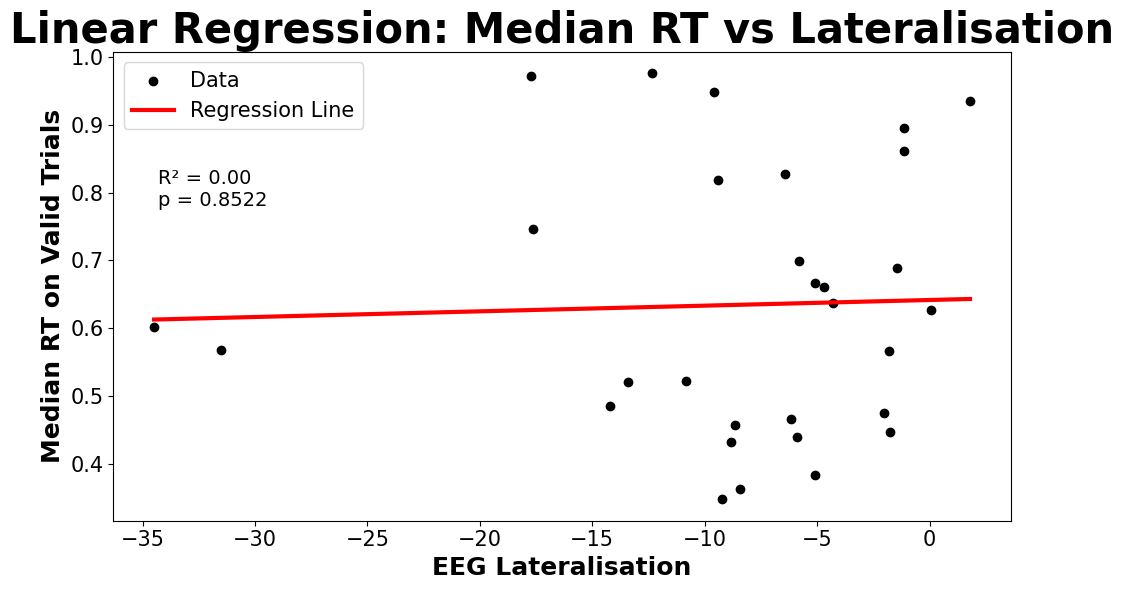

In [278]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Prepare data
X = All_Behavioural_data[['Lateralisation']]
y_median = All_Behavioural_data['Median RT on Valid Trials']

# Add constant for intercept
X_sm = sm.add_constant(X)

# Fit model with statsmodels
model = sm.OLS(y_median, X_sm).fit()

# Generate high-res prediction line
x_vals = np.linspace(X['Lateralisation'].min(), X['Lateralisation'].max(), 500)
x_vals_df = pd.DataFrame({'const': 1, 'Lateralisation': x_vals})
y_pred = model.predict(x_vals_df)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X['Lateralisation'], y_median, alpha=1, color='black', label='Data')
plt.plot(x_vals, y_pred, color='red', linewidth=3, linestyle='-', label='Regression Line')
plt.xlabel('EEG Lateralisation', fontsize=18, fontweight='bold')
plt.ylabel('Median RT on Valid Trials', fontsize=18, fontweight='bold')
plt.title('Linear Regression: Median RT vs Lateralisation', fontsize=30, fontweight='bold')
plt.legend(fontsize=15)
plt.text(0.05, 0.75, f'R² = {model.rsquared:.2f}\np = {model.pvalues["Lateralisation"]:.4f}', 
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.savefig('Path to save figure/Median_RT_vs_Lateralisation.jpg', dpi=600)
plt.show()

In [ ]:
# Function to compute trial level EEG lateralization
def Trial_Level_EEG_lateralization(Subject_EEG, tmin, tmax, fmin, fmax, Left_channels, Right_channels):

    Left_EEG_power = Subject_EEG.compute_psd(fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax, picks=Left_channels).get_data().mean(axis=1).mean(axis=1).squeeze()
    Right_EEG_power = Subject_EEG.compute_psd(fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax, picks=Right_channels).get_data().mean(axis=1).mean(axis=1).squeeze()

    # Calculate the normalized difference in beta power between the left and right recording sites
    Cortical_lateralization = (Right_EEG_power - Left_EEG_power) / (Right_EEG_power + Left_EEG_power)

    # Sort the trials according to cortical lateralization (separately for left- and right-cued trials) and place them into five consecutive bins.
    EEG_events = Subject_EEG.events

    EEG_event_id = Subject_EEG.event_id

    Cortical_lateralization_left = Cortical_lateralization[EEG_events[:,2] == EEG_event_id['Left']]
    Cortical_lateralization_right = Cortical_lateralization[EEG_events[:,2] == EEG_event_id['Right']]

    return Cortical_lateralization, Cortical_lateralization_left, Cortical_lateralization_right

# Extract all the relevant paths
ERP_BBO_filenames, EMG_filenames, Behavioural_filenames = Load_EEG_EMG_Paths()
TFR_BBO_filenames = []
ERP_Stim_filenames = []
TFR_Stim_filenames = []
for i in range(len(ERP_BBO_filenames)):
    thisname = ERP_BBO_filenames[i].split('/')[:-1]
    thisname = '/'.join(thisname) + '/'
    Files = os.listdir(thisname)
    for File in Files:
        if File.endswith('-tfr.hdf5') and not File.startswith('._') and 'ERPs' not in File:
            TFR_file = os.path.join(thisname, File)
            TFR_BBO_filenames.append(TFR_file)
        if File.endswith('ERPs-epo.fif') and not File.startswith('._'):
            ERP_Stim_file = os.path.join(thisname, File)
            ERP_Stim_filenames.append(ERP_Stim_file)
        if File.endswith('ERPs-tfr.hdf5') and not File.startswith('._'):
            TFR_Stim_file = os.path.join(thisname, File)
            TFR_Stim_filenames.append(TFR_Stim_file)

Extracted_data = {}
Left_channels = ['FC1', 'C3', 'CP1']
Right_channels = ['FC2', 'C4', 'CP2']

for subject_index in range(len(ERP_BBO_filenames)):
    behavioural_name = Behavioural_filenames[subject_index]
    if '._' in behavioural_name:
        behavioural_name = behavioural_name.replace('._', '')

    with open(behavioural_name, 'rb') as f:
        data = pickle.load(f)

    # Extract relevant behavioural data
    age = np.array(data['age'])
    gender = data['gender']
    participant_response = np.array(data['participant_response'])
    rts = np.array(data['rts'])
    correct_resp = np.array(data['correct_resp'])
    matches = np.array(data['matches'])
    validity = np.array(data['validity'])
    intensities = np.array(data['intensities'])

    # Load the ERP related data files
    TFR_Stim_data = mne.time_frequency.read_tfrs(TFR_Stim_filenames[subject_index])
    TFR_Stim_data = TFR_Stim_data.apply_baseline((None,0))

    ERP_BBO_data = mne.read_epochs(ERP_BBO_filenames[subject_index])
    ERP_BBO_data.apply_baseline((None,0))

    BBO_data = mne.read_epochs(ERP_BBO_filenames[subject_index])

    # Ensure the trials are in the correct order with the function you wrote
    assert np.all(ERP_BBO_data.events == TFR_Stim_data.events), "The events do not match in the EEG and EMG data"

    Stim_vec = ERP_BBO_data.events[:,2]
    Stim_side = []
    for stim in Stim_vec:
        if stim == 10002:
            Stim_side.append('Left')
        elif stim == 10004:
            Stim_side.append('Right')
        elif stim == 10003:
            Stim_side.append('Invalid')


    # Extract the trial level EEG lateralization at different time windows
    Full_Lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin = -3, tmax = 0, fmin = 7, fmax = 30, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    Full_Beta_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin = -3, tmax = -.8, fmin = 15, fmax = 30, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    Full_Alpha_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin = -3, tmax = 0, fmin = 8, fmax = 12, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    post_cue_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=-3, tmax=-1.5, fmin=15, fmax=30, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    pre_stim_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=-1.5, tmax=0, fmin=15, fmax=30, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    Low_Beta_post_cue_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=-3, tmax=-1.5, fmin=12, fmax=20, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    Low_Beta_pre_stim_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=-1.5, tmax=0, fmin=12, fmax=20, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    High_Beta_post_cue_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=-3, tmax=-1.5, fmin=21, fmax=30, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    High_Beta_pre_stim_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=-1.5, tmax=0, fmin=21, fmax=30, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    Pre_Response_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=.5, tmax=1, fmin=15, fmax=30, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    Pre_Response_lat_Low_Beta,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=.5, tmax=1, fmin=12, fmax=20, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    Pre_Response_lat_High_Beta,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=.5, tmax=1, fmin=21, fmax=30, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    post_stim_Beta_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=0, tmax=.5, fmin=15, fmax=30, Left_channels=Left_channels[1], Right_channels=Right_channels[1])
    post_stim_Alpha_lat,_,_ = Trial_Level_EEG_lateralization(ERP_BBO_data, tmin=0, tmax=.5, fmin=8, fmax=12, Left_channels=Left_channels[1], Right_channels=Right_channels[1])

    # Also extract raw power in the beta range
    Raw_Beta_post_cue_left = ERP_BBO_data.compute_psd(tmin=-3, tmax=-1.5, fmin=15, fmax=30, picks=['FC1', 'C3', 'CP1']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_Beta_post_cue_right = ERP_BBO_data.compute_psd(tmin=-3, tmax=-1.5, fmin=15, fmax=30, picks=['FC2', 'C4', 'CP2']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_Beta_pre_stim_left = ERP_BBO_data.compute_psd(tmin=-1.5, tmax=0, fmin=15, fmax=30, picks=['FC1', 'C3', 'CP1']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_Beta_pre_stim_right = ERP_BBO_data.compute_psd(tmin=-1.5, tmax=0, fmin=15, fmax=30, picks=['FC2', 'C4', 'CP2']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_Low_Beta_post_cue_left = ERP_BBO_data.compute_psd(tmin=-3, tmax=-1.5, fmin=12, fmax=20, picks=['FC1', 'C3', 'CP1']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_Low_Beta_post_cue_right = ERP_BBO_data.compute_psd(tmin=-3, tmax=-1.5, fmin=12, fmax=20, picks=['FC2', 'C4', 'CP2']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_Low_Beta_pre_stim_left = ERP_BBO_data.compute_psd(tmin=-1.5, tmax=0, fmin=12, fmax=20, picks=['FC1', 'C3', 'CP1']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_Low_Beta_pre_stim_right = ERP_BBO_data.compute_psd(tmin=-1.5, tmax=0, fmin=12, fmax=20, picks=['FC2', 'C4', 'CP2']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_High_Beta_post_cue_left = ERP_BBO_data.compute_psd(tmin=-3, tmax=-1.5, fmin=21, fmax=30, picks=['FC1', 'C3', 'CP1']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_High_Beta_post_cue_right = ERP_BBO_data.compute_psd(tmin=-3, tmax=-1.5, fmin=21, fmax=30, picks=['FC2', 'C4', 'CP2']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_High_Beta_pre_stim_left = ERP_BBO_data.compute_psd(tmin=-1.5, tmax=0, fmin=21, fmax=30, picks=['FC1', 'C3', 'CP1']).get_data().mean(axis=1).mean(axis=1).squeeze()
    Raw_High_Beta_pre_stim_right = ERP_BBO_data.compute_psd(tmin=-1.5, tmax=0, fmin=21, fmax=30, picks=['FC2', 'C4', 'CP2']).get_data().mean(axis=1).mean(axis=1).squeeze()

    # Extract the evoked power in the Cz channel for the stimulus related data
    time_min, time_max = .2, .35  # Time range in seconds
    freq_min, freq_max = 0, 5  # Frequency range in Hz
    time_mask = (TFR_Stim_data.times >= time_min) & (TFR_Stim_data.times <= time_max)
    freq_mask = (TFR_Stim_data.freqs >= freq_min) & (TFR_Stim_data.freqs <= freq_max)
    ch_index = TFR_Stim_data.info['ch_names'].index('Cz')
    Evoked_power_Cz = TFR_Stim_data.data[:, ch_index, freq_mask, :][:, :, time_mask]  # Shape: (n_epochs, n_freqs_selected, n_times_selected)
    Evoked_power_per_trial = np.mean(Evoked_power_Cz, axis=(1, 2))

    # Now put this all in a dataframe where each thing is a column and there is a column for the subject number
    # Store extracted data in a dictionary
    Temp_Extracted_data = {
        "subject_id": [subject_index] * len(rts),
        "Trial_number": np.arange(len(rts)),
        "rts": rts.tolist() if isinstance(rts, np.ndarray) else rts,
        "correct_resp": correct_resp.tolist() if isinstance(correct_resp, np.ndarray) else correct_resp,
        "matches": matches.tolist() if isinstance(matches, np.ndarray) else matches,
        "validity": validity.tolist() if isinstance(validity, np.ndarray) else validity,
        "Stim_side": Stim_side,
        "Full_Lat": Full_Lat.tolist() if isinstance(Full_Lat, np.ndarray) else Full_Lat,
        "Full_Beta_lat": Full_Beta_lat.tolist() if isinstance(Full_Beta_lat, np.ndarray) else Full_Beta_lat,
        "Full_Alpha_lat": Full_Alpha_lat.tolist() if isinstance(Full_Alpha_lat, np.ndarray) else Full_Alpha_lat,
        "post_cue_lat": post_cue_lat.tolist() if isinstance(post_cue_lat, np.ndarray) else post_cue_lat,
        "pre_stim_lat": pre_stim_lat.tolist() if isinstance(pre_stim_lat, np.ndarray) else pre_stim_lat,
        "Low_Beta_post_cue_lat": Low_Beta_post_cue_lat.tolist() if isinstance(Low_Beta_post_cue_lat, np.ndarray) else Low_Beta_post_cue_lat,
        "Low_Beta_pre_stim_lat": Low_Beta_pre_stim_lat.tolist() if isinstance(Low_Beta_pre_stim_lat, np.ndarray) else Low_Beta_pre_stim_lat,
        "High_Beta_post_cue_lat": High_Beta_post_cue_lat.tolist() if isinstance(High_Beta_post_cue_lat, np.ndarray) else High_Beta_post_cue_lat,
        "High_Beta_pre_stim_lat": High_Beta_pre_stim_lat.tolist() if isinstance(High_Beta_pre_stim_lat, np.ndarray) else High_Beta_pre_stim_lat,
        "Pre_Response_lat": Pre_Response_lat.tolist() if isinstance(Pre_Response_lat, np.ndarray) else Pre_Response_lat,
        "Pre_Response_lat_Low_Beta": Pre_Response_lat_Low_Beta.tolist() if isinstance(Pre_Response_lat_Low_Beta, np.ndarray) else Pre_Response_lat_Low_Beta,
        "Pre_Response_lat_High_Beta": Pre_Response_lat_High_Beta.tolist() if isinstance(Pre_Response_lat_High_Beta, np.ndarray) else Pre_Response_lat_High_Beta,
        "Evoked_power_per_trial": Evoked_power_per_trial.tolist() if isinstance(Evoked_power_per_trial, np.ndarray) else Evoked_power_per_trial,
        "post_stim_Beta_lat": post_stim_Beta_lat.tolist() if isinstance(post_stim_Beta_lat, np.ndarray) else post_stim_Beta_lat,
        "post_stim_Alpha_lat": post_stim_Alpha_lat.tolist() if isinstance(post_stim_Alpha_lat, np.ndarray) else post_stim_Alpha_lat,
        "Raw_Beta_post_cue_left": Raw_Beta_post_cue_left.tolist() if isinstance(Raw_Beta_post_cue_left, np.ndarray) else Raw_Beta_post_cue_left,
        "Raw_Beta_post_cue_right": Raw_Beta_post_cue_right.tolist() if isinstance(Raw_Beta_post_cue_right, np.ndarray) else Raw_Beta_post_cue_right,
        "Raw_Beta_pre_stim_left": Raw_Beta_pre_stim_left.tolist() if isinstance(Raw_Beta_pre_stim_left, np.ndarray) else Raw_Beta_pre_stim_left,
        "Raw_Beta_pre_stim_right": Raw_Beta_pre_stim_right.tolist() if isinstance(Raw_Beta_pre_stim_right, np.ndarray) else Raw_Beta_pre_stim_right,
        "Raw_Low_Beta_post_cue_left": Raw_Low_Beta_post_cue_left.tolist() if isinstance(Raw_Low_Beta_post_cue_left, np.ndarray) else Raw_Low_Beta_post_cue_left,
        "Raw_Low_Beta_post_cue_right": Raw_Low_Beta_post_cue_right.tolist() if isinstance(Raw_Low_Beta_post_cue_right, np.ndarray) else Raw_Low_Beta_post_cue_right,
        "Raw_Low_Beta_pre_stim_left": Raw_Low_Beta_pre_stim_left.tolist() if isinstance(Raw_Low_Beta_pre_stim_left, np.ndarray) else Raw_Low_Beta_pre_stim_left,
        "Raw_Low_Beta_pre_stim_right": Raw_Low_Beta_pre_stim_right.tolist() if isinstance(Raw_Low_Beta_pre_stim_right, np.ndarray) else Raw_Low_Beta_pre_stim_right,
        "Raw_High_Beta_post_cue_left": Raw_High_Beta_post_cue_left.tolist() if isinstance(Raw_High_Beta_post_cue_left, np.ndarray) else Raw_High_Beta_post_cue_left,
        "Raw_High_Beta_post_cue_right": Raw_High_Beta_post_cue_right.tolist() if isinstance(Raw_High_Beta_post_cue_right, np.ndarray) else Raw_High_Beta_post_cue_right,
        "Raw_High_Beta_pre_stim_left": Raw_High_Beta_pre_stim_left.tolist() if isinstance(Raw_High_Beta_pre_stim_left, np.ndarray) else Raw_High_Beta_pre_stim_left,
        "Raw_High_Beta_pre_stim_right": Raw_High_Beta_pre_stim_right.tolist() if isinstance(Raw_High_Beta_pre_stim_right, np.ndarray) else Raw_High_Beta_pre_stim_right
    }
    # Convert the dictionary to a DataFrame
    temp_df = pd.DataFrame(Temp_Extracted_data)

    if subject_index == 0: 
        Extracted_data = temp_df
    else:
        Extracted_data = pd.concat([Extracted_data, temp_df], ignore_index=True)

Extracted_data.to_excel('Path to save data/Behavioural_Analysis_BBO.xlsx', index=False)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: rts      
No. Observations: 2825    Method:             REML     
No. Groups:       30      Scale:              0.1086   
Min. group size:  14      Log-Likelihood:     -922.0724
Max. group size:  102     Converged:          Yes      
Mean group size:  94.2                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.751    0.029 26.211 0.000  0.695  0.808
Full_Beta_lat 0.016    0.033  0.489 0.625 -0.048  0.080
Group Var     0.023    0.020                           



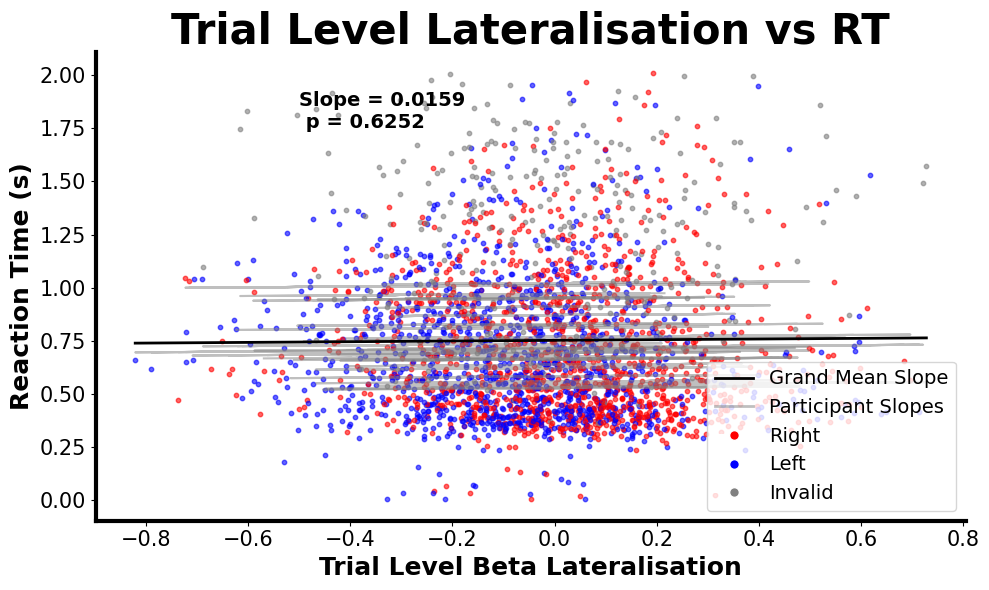

In [345]:
# Fit linear mixed effects model with subject as random intercept
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib.lines import Line2D

# Read the behavioural data
Extracted_data = pd.read_excel('Path to save data/Behavioural_Analysis_BBO.xlsx')
Extracted_data['subject_id'] = Extracted_data['subject_id'].astype('category')

Predictors = ['Full_Beta_lat', 'Full_Alpha_lat']
Predicted = ['rts', 'Evoked_power_per_trial', 'post_stim_Beta_lat']


# Subset only necessary columns to check for NaNs
cols_needed = ['rts', 'Full_Beta_lat', 'subject_id', 'Stim_side']
df_clean = Extracted_data.dropna(subset=cols_needed).copy()
df_clean.reset_index(drop=True, inplace=True)

model = smf.mixedlm("rts ~ Full_Beta_lat", 
                    data=df_clean, 
                    groups=df_clean["subject_id"])
result = model.fit()
print(result.summary())
p_value = result.pvalues['Full_Beta_lat']

# Random effects per subject (intercepts only, unless you added slopes)
random_effects = result.random_effects  # dict: {subject_id: params}

# Fixed effect (grand slope and intercept)
fixed_intercept = result.fe_params['Intercept']
fixed_slope = result.fe_params['Full_Beta_lat']


plt.figure(figsize=(10, 6))
subject_ids = df_clean['subject_id'].unique()
color_map = {'Right': 'red', 'Left': 'blue', 'Invalid': 'gray'}  

for subj in subject_ids:
    subj_data = df_clean[df_clean['subject_id'] == subj]
    x = subj_data['Full_Beta_lat']
    y = subj_data['rts']
    stim_sides = subj_data['Stim_side']

    # Random intercept (if model only includes random intercepts)
    re_intercept = random_effects[subj]['Group']
    
    # Predicted line: fixed slope + subject-specific intercept
    y_pred = fixed_intercept + re_intercept + fixed_slope * x
    
    # Plot data points and line
    plt.plot(x, y_pred, color='gray', alpha=0.5)
    for xi, yi, side in zip(x, y, stim_sides):
        plt.scatter(xi, yi, color=color_map.get(side, 'black'), s=10, alpha=0.6)

# Plot the grand (fixed effect) slope line
x_vals = np.linspace(df_clean['Full_Beta_lat'].min(), df_clean['Full_Beta_lat'].max(), 100)
y_grand = fixed_intercept + fixed_slope * x_vals
plt.plot(x_vals, y_grand, color='black', linewidth=2, label='Grand Mean Slope')

# Labels and legend
plt.xlabel('Trial Level Beta Lateralisation', fontsize=18, fontweight='bold')
plt.ylabel('Reaction Time (s)', fontsize=18, fontweight='bold')
plt.title('Trial Level Lateralisation vs RT', fontsize=30, fontweight='bold')
plt.text(-.5, 1.75, f'Slope = {fixed_slope:.4f} \n p = {p_value:.4f}', fontsize=14, fontweight='bold')
stim_legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=7)
    for label, color in color_map.items()
]
participant_line = Line2D([0], [0], color='gray', linewidth=2, alpha=0.5, label='Participant Slopes')
grand_mean_line = Line2D([0], [0], color='black', linewidth=2, label='Grand Mean Slope')
line_handles, line_labels = plt.gca().get_legend_handles_labels()
all_handles = [grand_mean_line, participant_line] + stim_legend_handles
plt.legend(handles=all_handles, fontsize=14, loc='lower right')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Trial_Level_Lateralisation_vs_RT.jpg', dpi=600)
plt.show()


         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: rts      
No. Observations:  1262    Method:             REML     
No. Groups:        30      Scale:              0.0687   
Min. group size:   1       Log-Likelihood:     -148.9571
Max. group size:   45      Converged:          Yes      
Mean group size:   42.1                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.702    0.033 21.134 0.000  0.637  0.768
Full_Beta_lat -0.034    0.041 -0.818 0.413 -0.115  0.047
Group Var      0.031    0.033                           



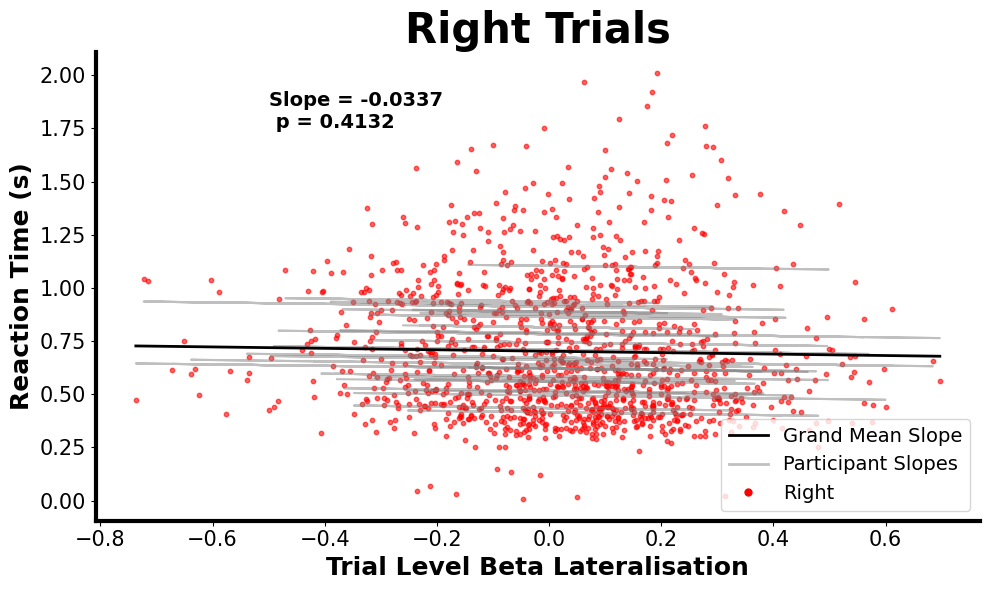

In [346]:
# Fit linear mixed effects model with subject as random intercept
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib.lines import Line2D

# Read the behavioural data
Extracted_data = pd.read_excel('Path to saved data/Behavioural_Analysis_BBO.xlsx')
Extracted_data['subject_id'] = Extracted_data['subject_id'].astype('category')

Predictors = ['Full_Beta_lat', 'Full_Alpha_lat']
Predicted = ['rts', 'Evoked_power_per_trial', 'post_stim_Beta_lat']


# Subset only necessary columns to check for NaNs
cols_needed = ['rts', 'Full_Beta_lat', 'subject_id', 'Stim_side']
df_clean = Extracted_data.dropna(subset=cols_needed).copy()
df_clean = df_clean[df_clean['Stim_side'] == 'Right']
df_clean.reset_index(drop=True, inplace=True)

model = smf.mixedlm("rts ~ Full_Beta_lat", 
                    data=df_clean, 
                    groups=df_clean["subject_id"])
result = model.fit()
print(result.summary())
p_value = result.pvalues['Full_Beta_lat']

# Random effects per subject (intercepts only, unless you added slopes)
random_effects = result.random_effects  # dict: {subject_id: params}

# Fixed effect (grand slope and intercept)
fixed_intercept = result.fe_params['Intercept']
fixed_slope = result.fe_params['Full_Beta_lat']


plt.figure(figsize=(10, 6))
subject_ids = df_clean['subject_id'].unique()
color_map = {'Right': 'red'}  

for subj in subject_ids:
    subj_data = df_clean[df_clean['subject_id'] == subj]
    x = subj_data['Full_Beta_lat']
    y = subj_data['rts']
    stim_sides = subj_data['Stim_side']

    # Random intercept (if model only includes random intercepts)
    re_intercept = random_effects[subj]['Group']
    
    # Predicted line: fixed slope + subject-specific intercept
    y_pred = fixed_intercept + re_intercept + fixed_slope * x
    
    # Plot data points and line
    plt.plot(x, y_pred, color='gray', alpha=0.5)
    for xi, yi, side in zip(x, y, stim_sides):
        plt.scatter(xi, yi, color=color_map.get(side, 'black'), s=10, alpha=0.6)

# Plot the grand (fixed effect) slope line
x_vals = np.linspace(df_clean['Full_Beta_lat'].min(), df_clean['Full_Beta_lat'].max(), 100)
y_grand = fixed_intercept + fixed_slope * x_vals
plt.plot(x_vals, y_grand, color='black', linewidth=2, label='Grand Mean Slope')

# Labels and legend
plt.xlabel('Trial Level Beta Lateralisation', fontsize=18, fontweight='bold')
plt.ylabel('Reaction Time (s)', fontsize=18, fontweight='bold')
plt.title('Right Trials', fontsize=30, fontweight='bold')
plt.text(-.5, 1.75, f'Slope = {fixed_slope:.4f} \n p = {p_value:.4f}', fontsize=14, fontweight='bold')
stim_legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=7)
    for label, color in color_map.items()
]
participant_line = Line2D([0], [0], color='gray', linewidth=2, alpha=0.5, label='Participant Slopes')
grand_mean_line = Line2D([0], [0], color='black', linewidth=2, label='Grand Mean Slope')
line_handles, line_labels = plt.gca().get_legend_handles_labels()
all_handles = [grand_mean_line, participant_line] + stim_legend_handles
plt.legend(handles=all_handles, fontsize=14, loc='lower right')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Trial_Level_Lateralisation_vs_RT_Right.jpg', dpi=600)
plt.show()


         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: rts      
No. Observations:  1261    Method:             REML     
No. Groups:        30      Scale:              0.0726   
Min. group size:   1       Log-Likelihood:     -179.9700
Max. group size:   45      Converged:          Yes      
Mean group size:   42.0                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.673    0.030 22.112 0.000  0.613  0.732
Full_Beta_lat -0.024    0.043 -0.573 0.567 -0.108  0.059
Group Var      0.025    0.028                           



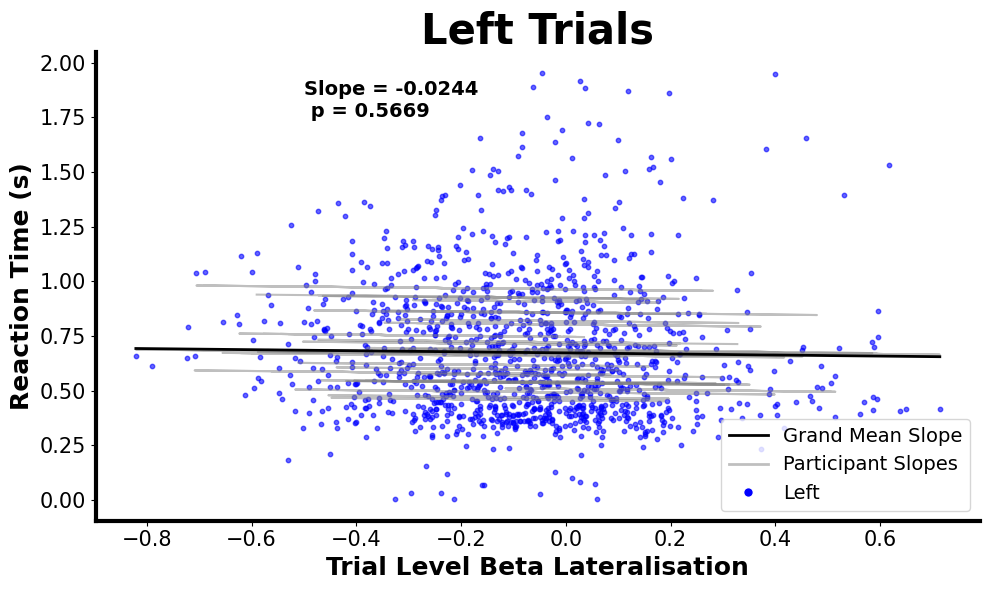

In [347]:
# Fit linear mixed effects model with subject as random intercept
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib.lines import Line2D

# Read the behavioural data
Extracted_data = pd.read_excel('Path to saved data/Behavioural_Analysis_BBO.xlsx')
Extracted_data['subject_id'] = Extracted_data['subject_id'].astype('category')

Predictors = ['Full_Beta_lat', 'Full_Alpha_lat']
Predicted = ['rts', 'Evoked_power_per_trial', 'post_stim_Beta_lat']


# Subset only necessary columns to check for NaNs
cols_needed = ['rts', 'Full_Beta_lat', 'subject_id', 'Stim_side']
df_clean = Extracted_data.dropna(subset=cols_needed).copy()
df_clean = df_clean[df_clean['Stim_side'] == 'Left']
df_clean.reset_index(drop=True, inplace=True)

model = smf.mixedlm("rts ~ Full_Beta_lat", 
                    data=df_clean, 
                    groups=df_clean["subject_id"])
result = model.fit()
print(result.summary())
p_value = result.pvalues['Full_Beta_lat']

# Random effects per subject (intercepts only, unless you added slopes)
random_effects = result.random_effects  # dict: {subject_id: params}

# Fixed effect (grand slope and intercept)
fixed_intercept = result.fe_params['Intercept']
fixed_slope = result.fe_params['Full_Beta_lat']


plt.figure(figsize=(10, 6))
subject_ids = df_clean['subject_id'].unique()
color_map = {'Left': 'blue'}  

for subj in subject_ids:
    subj_data = df_clean[df_clean['subject_id'] == subj]
    x = subj_data['Full_Beta_lat']
    y = subj_data['rts']
    stim_sides = subj_data['Stim_side']

    # Random intercept (if model only includes random intercepts)
    re_intercept = random_effects[subj]['Group']
    
    # Predicted line: fixed slope + subject-specific intercept
    y_pred = fixed_intercept + re_intercept + fixed_slope * x
    
    # Plot data points and line
    plt.plot(x, y_pred, color='gray', alpha=0.5)
    for xi, yi, side in zip(x, y, stim_sides):
        plt.scatter(xi, yi, color=color_map.get(side, 'black'), s=10, alpha=0.6)

# Plot the grand (fixed effect) slope line
x_vals = np.linspace(df_clean['Full_Beta_lat'].min(), df_clean['Full_Beta_lat'].max(), 100)
y_grand = fixed_intercept + fixed_slope * x_vals
plt.plot(x_vals, y_grand, color='black', linewidth=2, label='Grand Mean Slope')

# Labels and legend
plt.xlabel('Trial Level Beta Lateralisation', fontsize=18, fontweight='bold')
plt.ylabel('Reaction Time (s)', fontsize=18, fontweight='bold')
plt.title('Left Trials', fontsize=30, fontweight='bold')
plt.text(-.5, 1.75, f'Slope = {fixed_slope:.4f} \n p = {p_value:.4f}', fontsize=14, fontweight='bold')
stim_legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=7)
    for label, color in color_map.items()
]
participant_line = Line2D([0], [0], color='gray', linewidth=2, alpha=0.5, label='Participant Slopes')
grand_mean_line = Line2D([0], [0], color='black', linewidth=2, label='Grand Mean Slope')
line_handles, line_labels = plt.gca().get_legend_handles_labels()
all_handles = [grand_mean_line, participant_line] + stim_legend_handles
plt.legend(handles=all_handles, fontsize=14, loc='lower right')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Trial_Level_Lateralisation_vs_RT_Left.jpg', dpi=600)
plt.show()


/Users/ketanjaltare1/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: post_stim_Beta_lat
No. Observations: 3060    Method:             REML              
No. Groups:       30      Scale:              0.0589            
Min. group size:  102     Log-Likelihood:     -49.0542          
Max. group size:  102     Converged:          Yes               
Mean group size:  102.0                                         
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.020     0.014  -1.402  0.161  -0.048   0.008
Full_Beta_lat      0.433     0.023  18.919  0.000   0.388   0.478
Group Var          0.005     0.007                               



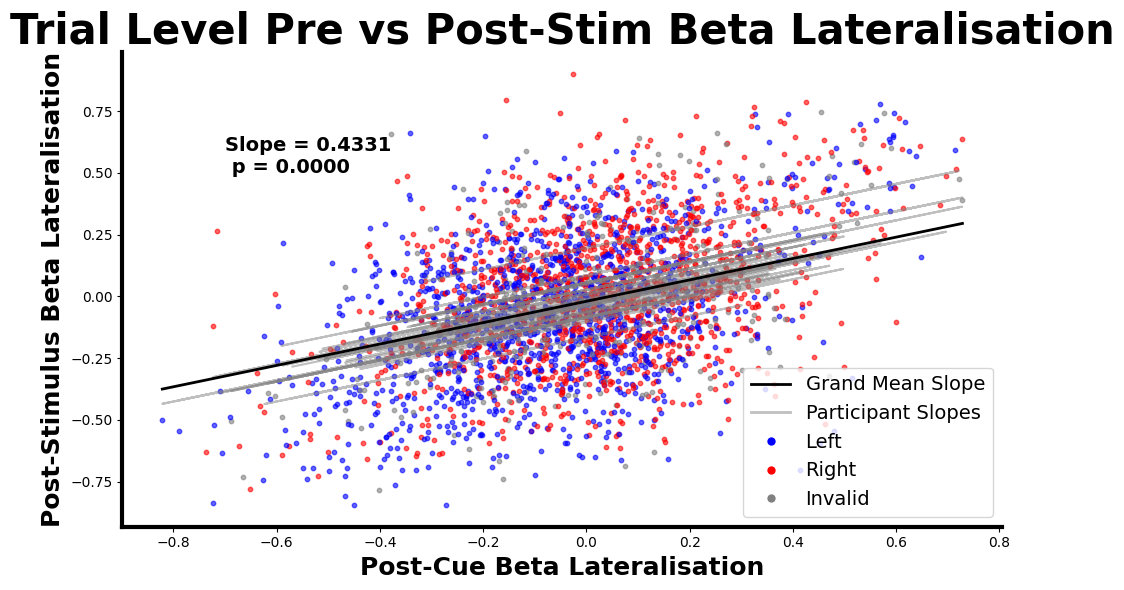

In [348]:
# Lateralisation vs Post-stimulus Beta Lateralisation
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


# Read the behavioural data
Extracted_data = pd.read_excel('Path to saved data/Behavioural_Analysis_BBO.xlsx')
Extracted_data['subject_id'] = Extracted_data['subject_id'].astype('category')
Predictors = ['Full_Beta_lat', 'Full_Alpha_lat']
Predicted = ['rts', 'Evoked_power_per_trial', 'post_stim_Beta_lat']


# Subset only necessary columns to check for NaNs
cols_needed = ['post_stim_Beta_lat', 'Full_Beta_lat', 'subject_id', 'Stim_side']
df_clean = Extracted_data.dropna(subset=cols_needed).copy()
df_clean.reset_index(drop=True, inplace=True)

model = smf.mixedlm("post_stim_Beta_lat ~ Full_Beta_lat", 
                    data=df_clean, 
                    groups=df_clean["subject_id"])
result = model.fit()
print(result.summary())
p_value = result.pvalues['Full_Beta_lat']

# Random effects per subject (intercepts only, unless you added slopes)
random_effects = result.random_effects  # dict: {subject_id: params}

# Fixed effect (grand slope and intercept)
fixed_intercept = result.fe_params['Intercept']
fixed_slope = result.fe_params['Full_Beta_lat']


plt.figure(figsize=(10, 6))
subject_ids = df_clean['subject_id'].unique()
color_map = {'Left': 'blue', 'Right': 'red', 'Invalid': 'gray'}  

for subj in subject_ids:
    subj_data = df_clean[df_clean['subject_id'] == subj]
    x = subj_data['Full_Beta_lat']
    y = subj_data['post_stim_Beta_lat']
    stim_sides = subj_data['Stim_side']

    # Random intercept
    re_intercept = random_effects[subj]['Group']
    
    # Predicted line
    y_pred = fixed_intercept + re_intercept + fixed_slope * x
    
    # Plot regression line
    plt.plot(x, y_pred, color='gray', alpha=0.5)
    
    # Plot data points with color according to Stim_side
    for xi, yi, side in zip(x, y, stim_sides):
        plt.scatter(xi, yi, color=color_map.get(side, 'black'), s=10, alpha=0.6)

# Plot the grand (fixed effect) slope line
x_vals = np.linspace(df_clean['Full_Beta_lat'].min(), df_clean['Full_Beta_lat'].max(), 100)
y_grand = fixed_intercept + fixed_slope * x_vals
plt.plot(x_vals, y_grand, color='black', linewidth=2, label='Grand Mean Slope')

# Labels and legend
plt.xlabel('Post-Cue Beta Lateralisation', fontsize=18, fontweight='bold')
plt.ylabel('Post-Stimulus Beta Lateralisation', fontsize=18, fontweight='bold')
plt.title('Trial Level Pre vs Post-Stim Beta Lateralisation', fontsize=30, fontweight='bold')
plt.text(-.7, .5, f'Slope = {fixed_slope:.4f} \n p = {p_value:.4f}', fontsize=14, fontweight='bold')

stim_legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=7)
    for label, color in color_map.items()
]
participant_line = Line2D([0], [0], color='gray', linewidth=2, alpha=0.5, label='Participant Slopes')
grand_mean_line = Line2D([0], [0], color='black', linewidth=2, label='Grand Mean Slope')
line_handles, line_labels = plt.gca().get_legend_handles_labels()
all_handles = [grand_mean_line, participant_line] + stim_legend_handles
plt.legend(handles=all_handles, fontsize=14, title_fontsize=14, loc='lower right')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Trial_Level_Lateralisation_vs_Post_stim_Beta_Lateralisation.jpg', dpi=600, bbox_inches='tight')
plt.show()


/Users/ketanjaltare1/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Evoked_power_per_trial
No. Observations: 2466    Method:             REML                  
No. Groups:       30      Scale:              1.7148                
Min. group size:  58      Log-Likelihood:     -4233.2674            
Max. group size:  94      Converged:          Yes                   
Mean group size:  82.2                                              
---------------------------------------------------------------------
                   Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
---------------------------------------------------------------------
Intercept         -19.599     0.261  -74.959  0.000  -20.111  -19.086
Full_Beta_lat       0.005     0.140    0.039  0.969   -0.269    0.280
Group Var           2.029     0.414                                  



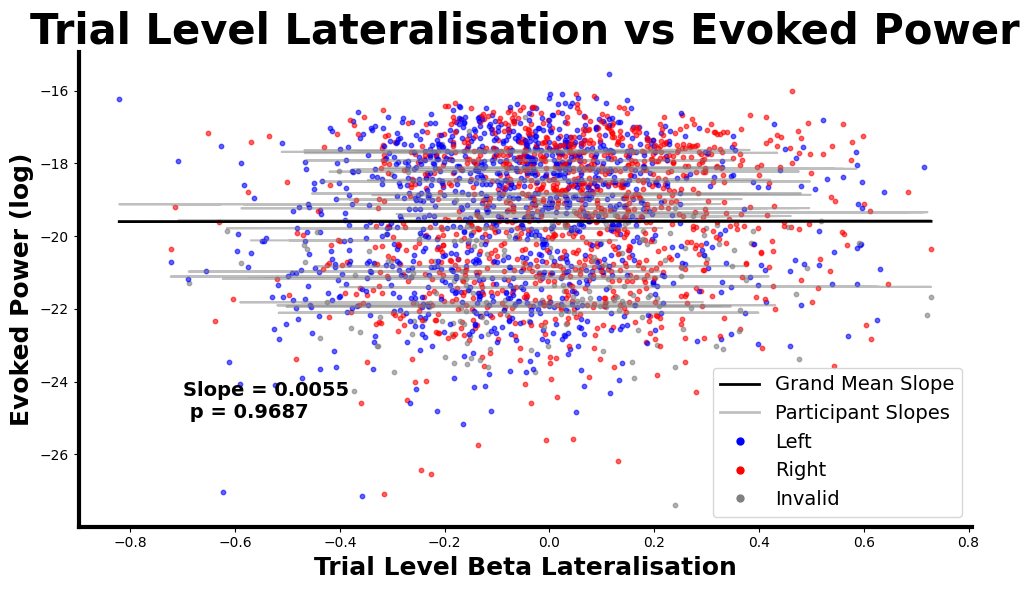

In [349]:
# Lateralisation vs Post-stimulus Beta Lateralisation
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

# Read the behavioural data
Extracted_data = pd.read_excel('Path to saved data/Behavioural_Analysis_BBO.xlsx')
Extracted_data['subject_id'] = Extracted_data['subject_id'].astype('category')
Extracted_data['Evoked_power_per_trial'] = np.log(Extracted_data['Evoked_power_per_trial'] + 1e-10)
Predictors = ['Full_Beta_lat', 'Full_Alpha_lat']
Predicted = ['rts', 'Evoked_power_per_trial', 'post_stim_Beta_lat']


# Subset only necessary columns to check for NaNs
cols_needed = ['Evoked_power_per_trial', 'Full_Beta_lat', 'subject_id', 'Stim_side']
df_clean = Extracted_data.dropna(subset=cols_needed).copy()
df_clean.reset_index(drop=True, inplace=True)

model = smf.mixedlm("Evoked_power_per_trial ~ Full_Beta_lat", 
                    data=df_clean, 
                    groups=df_clean["subject_id"].copy())
result = model.fit()
print(result.summary())
p_value = result.pvalues['Full_Beta_lat']

# Random effects per subject (intercepts only, unless you added slopes)
random_effects = result.random_effects  # dict: {subject_id: params}

# Fixed effect (grand slope and intercept)
fixed_intercept = result.fe_params['Intercept']
fixed_slope = result.fe_params['Full_Beta_lat']


plt.figure(figsize=(10, 6))

# Plot each subject's data and regression line
subject_ids = df_clean['subject_id'].unique()
color_map = {'Left': 'blue', 'Right': 'red', 'Invalid': 'gray'}  

for subj in subject_ids:
    subj_data = df_clean[df_clean['subject_id'] == subj]
    x = subj_data['Full_Beta_lat']
    y = subj_data['Evoked_power_per_trial']
    stim_sides = subj_data['Stim_side']

    # Random intercept (if model only includes random intercepts)
    re_intercept = random_effects[subj]['Group']
    
    # Predicted line: fixed slope + subject-specific intercept
    y_pred = fixed_intercept + re_intercept + fixed_slope * x
    
    # Plot data points and line
    plt.plot(x, y_pred, color='gray', alpha=0.5)
    for xi, yi, side in zip(x, y, stim_sides):
        plt.scatter(xi, yi, color=color_map.get(side, 'black'), s=10, alpha=0.6)

# Plot the grand (fixed effect) slope line
x_vals = np.linspace(df_clean['Full_Beta_lat'].min(), df_clean['Full_Beta_lat'].max(), 100)
y_grand = fixed_intercept + fixed_slope * x_vals
plt.plot(x_vals, y_grand, color='black', linewidth=2, label='Grand Mean Slope')

# Labels and legend
plt.xlabel('Trial Level Beta Lateralisation', fontsize=18, fontweight='bold')
plt.ylabel('Evoked Power (log)', fontsize=18, fontweight='bold')
plt.title('Trial Level Lateralisation vs Evoked Power', fontsize=30, fontweight='bold')
plt.text(-.7, -25, f'Slope = {fixed_slope:.4f} \n p = {p_value:.4f}', fontsize=14, fontweight='bold')
stim_legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=7)
    for label, color in color_map.items()
]
participant_line = Line2D([0], [0], color='gray', linewidth=2, alpha=0.5, label='Participant Slopes')
grand_mean_line = Line2D([0], [0], color='black', linewidth=2, label='Grand Mean Slope')
line_handles, line_labels = plt.gca().get_legend_handles_labels()
all_handles = [grand_mean_line, participant_line] + stim_legend_handles
plt.legend(handles=all_handles, fontsize=14, title_fontsize=14, loc='lower right')
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3)   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Path to save figure/Trial_Level_Lateralisation_vs_Evoked_Power.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
##################################### Comparison of the three methods of coherence #####################################


# Load the EEG and corrosponding EMG data
# Extract the procesed TFR file names

EEG_path = "Path to EEG data/EEG/Processed/"
EMG_path = "Path to EMG data/EMG/Processed/"
EMG_filenames = []
EMG_folder_names = []
EEG_filenames = []
behaviour_filenames = []
EMG_folders = [f for f in os.listdir(EMG_path) if os.path.isdir(os.path.join(EMG_path, f))]
EEG_folders = [f for f in os.listdir(EEG_path) if os.path.isdir(os.path.join(EEG_path, f))]
print(EEG_folders)
for idx, folder in enumerate(EEG_folders):
    if 'BBO' not in folder:
        continue
    participant_id = int(folder.split('_')[1])

    # Find the corrosponding EMG folder
    for EMG_idx, EMG_folder in enumerate(EMG_folders):
        match = re.search(r'\d+', EMG_folder)
        if match:
            folder_number = int(match.group())  # Convert the extracted number to an integer
            if folder_number == participant_id:
                EMG_to_extract = EMG_folder
                break
    EMG_file = [f for f in os.listdir(os.path.join(EMG_path, EMG_to_extract)) if 'EMG-epo' in f]
    EEG_file = [f for f in os.listdir(os.path.join(EEG_path, folder)) if 'BBO-epo' in f]
    EEG_filenames.append(os.path.join(EEG_path, EEG_folders[idx], EEG_file[0]))
    EMG_filenames.append(os.path.join(EMG_path, EMG_to_extract, EMG_file[0]))
sub2load = 9
Subject_EEG = mne.read_epochs(EEG_filenames[sub2load])
Subject_EMG = mne.read_epochs(EMG_filenames[sub2load])

tmin = -1.0
tmax = 0.0
EEG_data = Subject_EEG.crop(tmin=tmin, tmax=tmax).get_data()
EMG_data = Subject_EMG.crop(tmin=tmin, tmax=tmax).get_data()

# Example signals (EEG and EMG)
fs = 1000  # sampling frequency
x = EMG_data[0,0,:]  # Example EMG data
y = EEG_data[0,16,:]  # Example EEG data
fs = 1000  # Sampling frequency
coherence_nitime_20 = []
coherence_scipy_20 = []
coherence_multitaper_20 = []
Freq2extract = 40
for trial in range(EMG_data.shape[0]):
    x = EMG_data[trial, 0, :]  # Replace with actual EMG data
    y = EEG_data[trial, 16, :]  # Replace with actual EEG data
    # Compute the coherence for the three methods
    frequencies_nitime, coherence_nitime = Compute_coherence_nitime(x, y, fs, bw=4)
    coherence_nitime_20.append(coherence_nitime[frequencies_nitime == Freq2extract])
    freqs_scipy, coherence_scipy = scipy.signal.coherence(x, y, fs, nperseg=500, noverlap=400, nfft=1000)
    frequencies_scipy = freqs_scipy[freqs_scipy < 60]
    coherence_scipy = coherence_scipy[:len(frequencies_scipy)]
    coherence_scipy_20.append(coherence_scipy[frequencies_scipy == Freq2extract])
    frequencies_multitaper, coherence_multitaper = Compute_coherence_multitaper(x, y, fmin=0, fmax=60, fs=fs, bw=4)
    coherence_multitaper_20.append(coherence_multitaper[np.argmin(np.abs(frequencies_multitaper - Freq2extract))])

plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
plt.plot(coherence_nitime_20, coherence_scipy_20, 'o')
plt.xlabel('Nitime')
plt.ylabel('Scipy')
plt.subplot(1,3,2)
plt.plot(coherence_nitime_20, coherence_multitaper_20, 'o')
plt.xlabel('Nitime')
plt.ylabel('Multitaper')
plt.subplot(1,3,3)
plt.plot(coherence_scipy_20, coherence_multitaper_20, 'o')
plt.xlabel('Scipy')
plt.ylabel('Multitaper')
plt.show()


In [ ]:
######################## For the inspection of the EMG and EEG data variances ########################


# Load the EEG and corrosponding EMG data
# Extract the procesed TFR file names
import re
import scipy.signal as signal
EEG_path = "Path to EEG data/EEG/Processed/"
EMG_path = "Path to EMG data/EMG/Processed/"
EMG_filenames = []
EMG_folder_names = []
EEG_filenames = []
behaviour_filenames = []
EMG_folders = [f for f in os.listdir(EMG_path) if os.path.isdir(os.path.join(EMG_path, f))]
EEG_folders = [f for f in os.listdir(EEG_path) if os.path.isdir(os.path.join(EEG_path, f))]
print(EEG_folders)
for idx, folder in enumerate(EEG_folders):
    if 'BBO' not in folder:
        continue
    participant_id = int(folder.split('_')[1])

    # Find the corrosponding EMG folder
    for EMG_idx, EMG_folder in enumerate(EMG_folders):
        match = re.search(r'\d+', EMG_folder)
        if match:
            folder_number = int(match.group())  # Convert the extracted number to an integer
            if folder_number == participant_id:
                EMG_to_extract = EMG_folder
                break
    EMG_file = [f for f in os.listdir(os.path.join(EMG_path, EMG_to_extract)) if 'EMG-epo' in f]
    EEG_file = [f for f in os.listdir(os.path.join(EEG_path, folder)) if 'BBO-epo' in f]
    EEG_filenames.append(os.path.join(EEG_path, EEG_folders[idx], EEG_file[0]))
    EMG_filenames.append(os.path.join(EMG_path, EMG_to_extract, EMG_file[0]))


tmin = -1.0
tmax = 0.0
fmin = 15
fmax = 30
EEG_std = []
EMG_std = []
# Load the EEG and EMG data
sub2load = 10
Subject_EEG = mne.read_epochs(EEG_filenames[sub2load]) #Check the units of the EEG data and make sure they are in V
Subject_EMG = mne.read_epochs(EMG_filenames[sub2load]) # Check the units of the EMG data and make sure they are in V
# Define channels of interest:
Left_channels = ['FC1', 'C3', 'CP1']
Right_channels = ['FC2', 'C4', 'CP2']

assert Check_trial_match(Subject_EEG, Subject_EMG), "The trials order does not match in the EEG and EMG data"

frequencies = np.arange(3, 51, 1)  # Define frequencies of interest
n_cycles = frequencies/2
EMG_tfr =  Subject_EMG.compute_tfr(method = 'morlet', 
                                    freqs = frequencies,
                                    n_cycles = n_cycles,
                                    output='power',
                                    picks='emg',
                                    average=False, 
                                    return_itc=False) 